# Validation

In [1]:
import os
from IPython.display import Markdown
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep

mplhep.style.use("LHCb2")

PARTICLE = os.environ.get("PARTICLE", "muon")
LOCAL = os.environ.get("LOCAL", "yes").lower() in ['y', 'yes', 'true', '1']
SAMPLE = os.environ.get("SAMPLE", "2016MU")
SHARED_OBJECT = os.environ.get("SHARED_OBJECT")
if SHARED_OBJECT is None and len(glob("/tmp/exported/generated*.so")) > 1:
    SHARED_OBJECT = sorted(glob("/tmp/exported/generated*.so"))[-1])
MAX_ENTRIES = int(os.environ.get("MAX_ENTRIES", "10000"))

Markdown(f"""
 * PARTICLE: `{PARTICLE}`
 * LOCAL: `{LOCAL}`
 * SAMPLE: `{SAMPLE}`
 * SHARED_OBJECT: `{SHARED_OBJECT}`
 * MAX_ENTRIES: `{MAX_ENTRIES}`
""")



 * PARTICLE: `muon`
 * LOCAL: `True`
 * SAMPLE: `2016MU`
 * SHARED_OBJECT: `/tmp/exported/generated1756048304.0314913.so`
 * MAX_ENTRIES: `10000`


In [2]:
from scikinC.validation import MLFunction
from functools import wraps
from multiprocessing.pool import ThreadPool


N_WORKERS = int(os.environ.get("N_WORKERS", "8"))
        
def make_parallel(ml_function, n_workers):
    """
    Split the input to an MLFunction in chunks evaluated in parallel
    """
    @wraps(ml_function)
    def ret(X):
        with ThreadPool(n_workers) as pool:
            return np.concatenate(
                pool.map(ml_function, np.array_split(X, n_workers))
            )
    
    return ret

isMuonFunc = make_parallel(
    n_workers=N_WORKERS, 
    ml_function=MLFunction(
        lib_path=SHARED_OBJECT,
        function_name=f'isMuon_{PARTICLE}_pipe',
        n_inputs=4, 
        n_outputs=1
    )
)

class PipeFunction(MLFunction):
    def __init__(self, lib_path, function_name, n_inputs, n_outputs, n_random):
        self._n_random = n_random
        MLFunction.__init__(self, lib_path, function_name, n_inputs, n_outputs)
        self._f.argtypes = [np.ctypeslib.ndpointer(dtype=np.float32) for _ in (1, 2, 3)]

    def __call__(self, data_in):
        if not isinstance(data_in, (np.ndarray, list)):
            raise TypeError

        data_in_f = np.asarray(data_in).astype(self.float_type)

        noise_in = np.random.normal(0, 1, (len(data_in), self._n_random)).astype(dtype=self.float_type)

        if len(data_in_f.shape) == 1:
            data_in_f = np.array([data_in_f])

        obuf = np.empty(self.n_outputs, dtype=np.float32)
        output_rows = []

        for data_row, noise_row in zip(data_in_f, noise_in):
            self._f(obuf, data_row, noise_row)
            output_rows.append(obuf.copy())

        if isinstance(data_in, np.ndarray) and len(data_in.shape) == 1:
            return output_rows[0]

        return np.stack(output_rows)


pipe = PipeFunction(
    lib_path=SHARED_OBJECT,
    function_name=f'full_{PARTICLE}_pipe',
    n_inputs=5, 
    n_outputs=(4 + 2 + 9), # rich, muon, gpid
    n_random=64*4,
)

pipeFunc = make_parallel(
    n_workers=N_WORKERS, 
    ml_function=pipe
)
   

In [3]:
input_files = os.environ.get("INPUT_FILES")
default_input_files = ['https://s3.131.154.98.72.myip.cloud.infn.it/lamarr-train/training-data/2016MU-sim10b/LamarrTraining-j109.0.root?AWSAccessKeyId=reconvene7686&Signature=4XqMSuiTNrb9KkSH62SiMd0fqP0%3D&Expires=1756058467', 'https://s3.131.154.98.72.myip.cloud.infn.it/lamarr-train/training-data/2016MU-sim10b/LamarrTraining-j109.1.root?AWSAccessKeyId=reconvene7686&Signature=ILo2r6GfcOZ3Zr9vImZnuS0cMbU%3D&Expires=1756058467', 'https://s3.131.154.98.72.myip.cloud.infn.it/lamarr-train/training-data/2016MU-sim10b/LamarrTraining-j109.10.root?AWSAccessKeyId=reconvene7686&Signature=kBQ%2F3AoTa0dUGVGLe%2Favu5%2F857A%3D&Expires=1756058467']

input_files = input_files.split(" ") if input_files is not None else default_input_files

print ("Found", len(input_files), 'files')
print (input_files[:3])

Found 3 files
['https://s3.131.154.98.72.myip.cloud.infn.it/lamarr-train/training-data/2016MU-sim10b/LamarrTraining-j109.0.root?AWSAccessKeyId=reconvene7686&Signature=4XqMSuiTNrb9KkSH62SiMd0fqP0%3D&Expires=1756058467', 'https://s3.131.154.98.72.myip.cloud.infn.it/lamarr-train/training-data/2016MU-sim10b/LamarrTraining-j109.1.root?AWSAccessKeyId=reconvene7686&Signature=ILo2r6GfcOZ3Zr9vImZnuS0cMbU%3D&Expires=1756058467', 'https://s3.131.154.98.72.myip.cloud.infn.it/lamarr-train/training-data/2016MU-sim10b/LamarrTraining-j109.10.root?AWSAccessKeyId=reconvene7686&Signature=kBQ%2F3AoTa0dUGVGLe%2Favu5%2F857A%3D&Expires=1756058467']


In [4]:
selections = [
  "probe_Brunel_P > 3000",
  "probe_Brunel_P < 200000", 
  "probe_Brunel_ETA > 1.5", 
  "probe_Brunel_ETA < 5.5", 
  "probe_Brunel_RichDLLe  > -150",
  "probe_Brunel_RichDLLmu > -150",
  "probe_Brunel_RichDLLk  > -150",
  "probe_Brunel_RichDLLp  > -150",
  "probe_Brunel_RichDLLe  <  150",
  "probe_Brunel_RichDLLmu <  150",
  "probe_Brunel_RichDLLk  <  150",
  "probe_Brunel_RichDLLp  <  150",
  #"probe_Brunel_MuonMuLL > -9",
  #"probe_Brunel_MuonBgLL > -9", 
  #"probe_Brunel_MuonMuLL <  1", 
  #"probe_Brunel_MuonBgLL <  1", 
  "probe_Brunel_PIDe  > -25", 
  #"probe_Brunel_PIDmu > -150", 
  "probe_Brunel_PIDK  > -150", 
  "probe_Brunel_PIDp  > -150",
  "probe_Brunel_MC15TuneV1_ProbNNe  >= 0", 
  #"probe_Brunel_MC15TuneV1_ProbNNmu >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNpi >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNk  >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNp  >= 0", 
  "nTracks_Brunel > 0",
  "nTracks_Brunel < 1000", 
  "probe_Brunel_MuonUnbiased == 1",
]

In [5]:
import pandas as pd
import uproot

def load_dataset(selection):
    counter = 0
    dfs = []

    if isinstance(selection, (list, set, tuple)):
        selection = ' and '.join([f"({cut})" for cut in selection])
    
    for chunk in uproot.iterate({k: f'PidTupler/pid_{PARTICLE}' for k in input_files}, library='pd'):
        dfs.append(chunk.query(selection))
        counter += len(chunk)
        if counter >= MAX_ENTRIES: break
    
    return pd.concat(dfs).head(MAX_ENTRIES)

def get_X(df):
    return np.c_[
        df.probe_Brunel_P/1e3,
        df.probe_Brunel_ETA,
        df.nTracks_Brunel + np.random.uniform(-0.5, 0.5, len(df)),
        df.probe_Brunel_trackcharge
    ]

def get_Y(df):
    X = get_X(df)
    isMuon = (np.random.uniform(0, 1, (len(X), 1)) < isMuonFunc(X)).astype(np.float64)
    X = np.c_[X, isMuon].astype(np.float32).copy()

    Y = pipe(X).astype(np.float64)
    print (X.shape, '->', Y.shape)

    output_vars = [
        'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 
        'MuonMuLL', 'MuonBgLL', 
        'PIDe', 'PIDK', 'PIDp', 
        'ProbNNe', 'ProbNNpi', 'ProbNNk', 'ProbNNp', 
        'PIDmu', 'ProbNNmu'
    ]

    df[["Lamarr_isMuon"]] = np.c_[isMuon]
    df[[f'Lamarr_{var}' for var in output_vars]] = Y
    
    return df

In [6]:
df = load_dataset(selections)
df_lamarr = get_Y(df)

(10000, 5) -> (10000, 15)


In [7]:
df[['Lamarr_isMuon', 'probe_Brunel_isMuon']].describe()

Lamarr_isMuon  probe_Brunel_isMuon
count   10000.000000         10000.000000
mean        0.801400             0.810200
std         0.398966             0.392162
min         0.000000             0.000000
25%         1.000000             1.000000
50%         1.000000             1.000000
75%         1.000000             1.000000
max         1.000000             1.000000

In [8]:
from hist.intervals import ratio_uncertainty  
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

default_color = dict(muon='#00aa00', pion='dodgerblue', kaon='#8833dd', proton='red')[PARTICLE]

def plot_efficiency(series, mask, bins, plot_type='errorbars', **kwargs):
    xc = [series[series.between(u, l)].mean() for u, l in np.c_[bins[:-1], bins[1:]]]
    num, _ = np.histogram(series, bins, weights=mask.astype(np.float64))
    den, _ = np.histogram(series, bins)
    bin_mask = den > 2
    
    yc = num/np.maximum(1, den)
    err_low, err_up = ratio_uncertainty(
        num=num,
        denom=den,
        uncertainty_type="efficiency",  
    )

    if plot_type == 'errorbars':
        graphic_options = dict(
            fmt='o',
            color='black',
            markersize=4,
            linewidth=2,
        )
        graphic_options.update(kwargs)
        plt.errorbar(
            np.array(xc)[bin_mask], np.array(yc)[bin_mask],
            xerr=np.c_[xc - bins[:-1], bins[1:] - xc][bin_mask].T,
            yerr=np.c_[err_low, err_up][bin_mask].T,
            **graphic_options
        )

    elif plot_type == 'boxes':
        # Loop over data points; create box from errors at each point
        errorboxes = [
            Rectangle((xl, yl), w, h) for xl, yl, w, h in zip(
                bins[:-1][bin_mask], 
                (yc - err_low)[bin_mask],
                (bins[1:] - bins[:-1])[bin_mask], 
                (err_up + err_low)[bin_mask]
            )
        ]
        
        graphic_options = dict(
            color=default_color, 
            alpha=1.0,
            s=60,
            marker='d'
        )
        
        graphic_options.update(kwargs)

        # Create patch collection with specified colour/alpha
        pc = PatchCollection(
            errorboxes, 
            facecolor=graphic_options['color'], 
            alpha=graphic_options['alpha']*0.33, 
            edgecolor='none',
        )
    
        # Add collection to Axes
        plt.gca().add_collection(pc)
        plt.scatter(
            np.array(xc)[bin_mask], np.array(yc)[bin_mask],
            **graphic_options
        )



In [9]:
%%time
simulated_isMuon = isMuonFunc(get_X(df))

CPU times: user 5.9 s, sys: 158 ms, total: 6.05 s
Wall time: 835 ms


In [10]:
x_vars = {
    r'Momentum [GeV/$c$]': dict(formula="probe_Brunel_P/1e3", bins=np.exp(np.linspace(np.log(0.2), np.log(2e3))), scale='log'),
    r'Pseudorapidity $\eta$': dict(formula="probe_Brunel_ETA", bins=np.linspace(1.4, 5.5, 55-14), scale='linear'),
    r'Number of tracks': dict(formula="nTracks_Brunel", bins=np.linspace(0, 800, 40), scale='linear'),
}


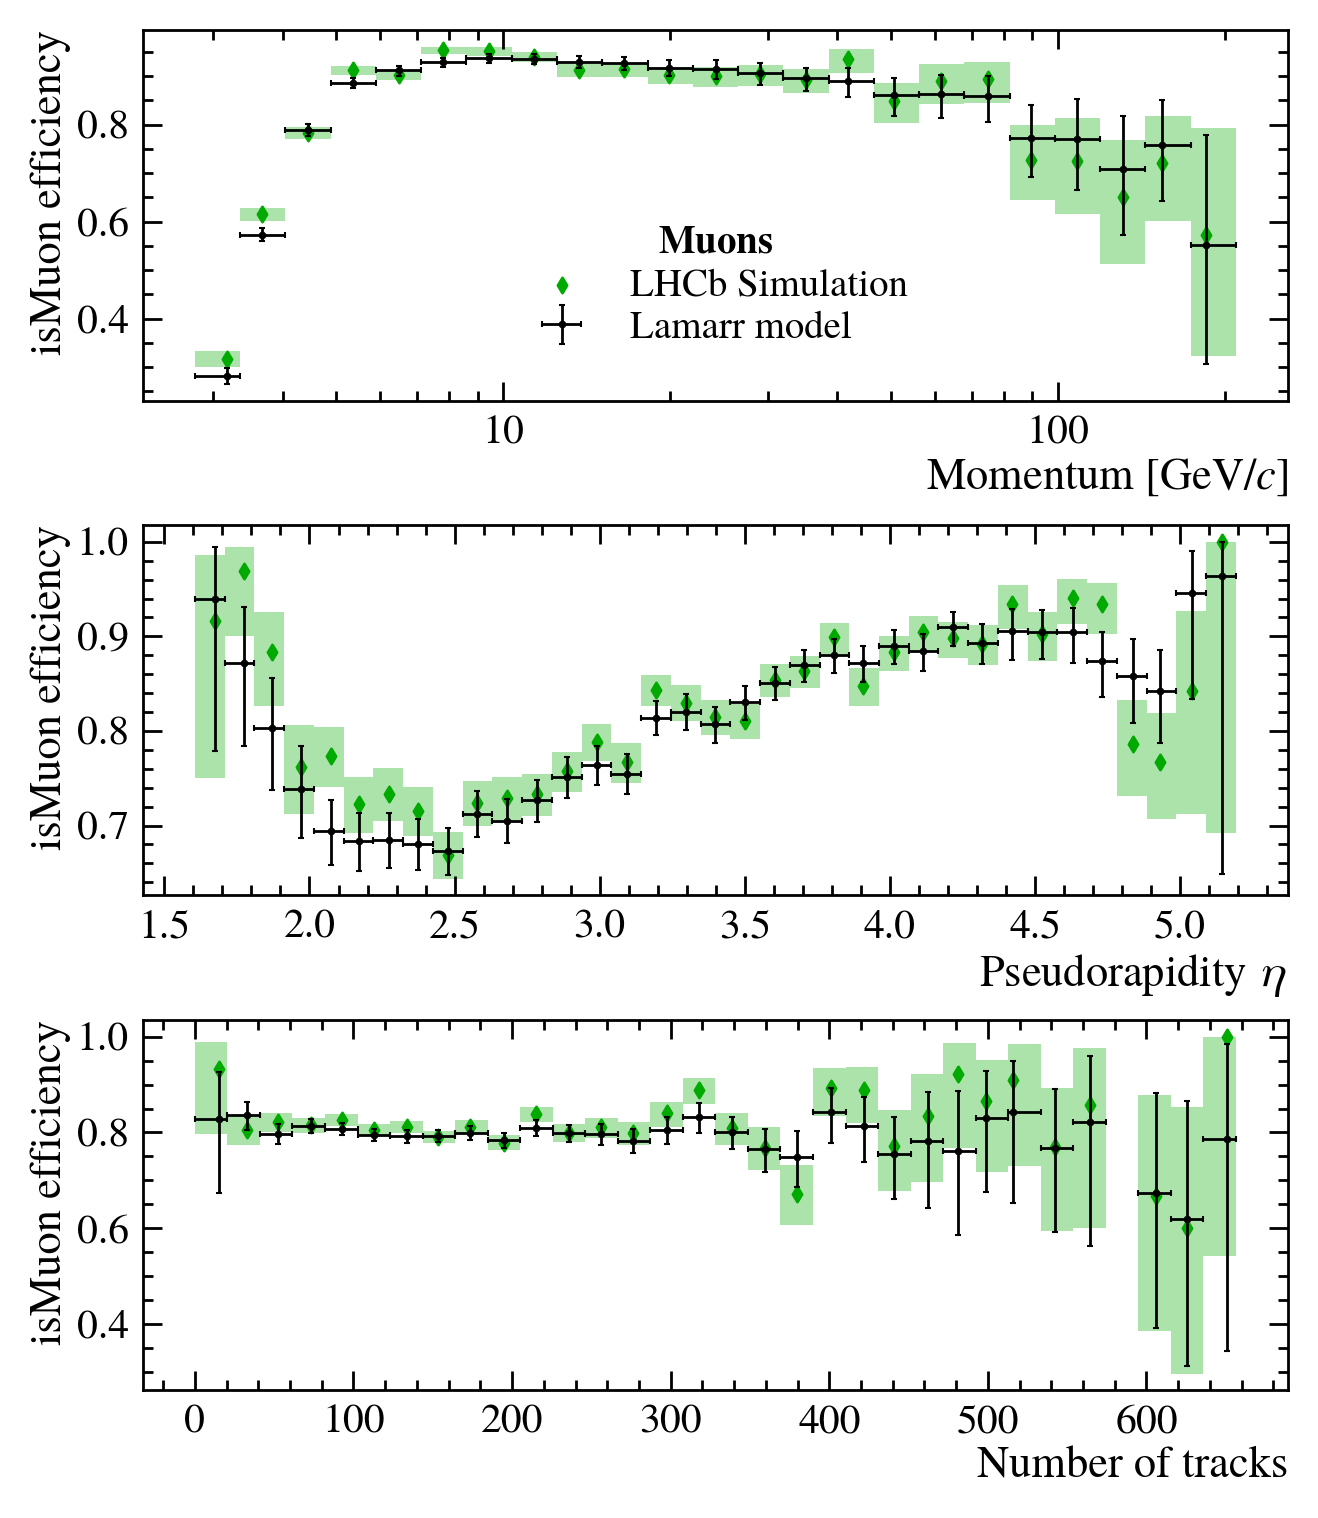

In [11]:
plt.figure(figsize=(13, 15))

bins=np.exp(np.linspace(np.log(0.2), np.log(2e3)))

for i_plot, (title, x_var) in enumerate(x_vars.items(), 1):
    plt.subplot(3, 1, i_plot)
    bins = x_var['bins']
    x = df.eval(x_var['formula'])
        
    plot_efficiency(x, df.probe_Brunel_isMuon > 0.5, bins=bins, plot_type='boxes', label="LHCb Simulation")
    plot_efficiency(x, simulated_isMuon.flatten(), bins=bins, plot_type='errorbars', label='Lamarr model')
    
    plt.xscale(x_var['scale'])
    #plt.ylim(-0.05, 1.05)
    plt.xlabel(title)
    plt.ylabel("isMuon efficiency")
    if i_plot == 1:
        plt.legend(title=rf"$\mathbf{{{PARTICLE.capitalize()}s}}$")

plt.tight_layout()
plt.show()

In [12]:
import yaml

configs = yaml.safe_load(rf"""
  - title: RICH\ {PARTICLE.capitalize()} \to Kaon
    brunel_var: probe_Brunel_RichDLLk
    lamarr_var: Lamarr_RichDLLk
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: RICH\ {PARTICLE.capitalize()} \to Proton
    brunel_var: probe_Brunel_RichDLLp
    lamarr_var: Lamarr_RichDLLp
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: RICH\ {PARTICLE.capitalize()}\ RichDLLpk
    brunel_var: probe_Brunel_RichDLLp - probe_Brunel_RichDLLk
    lamarr_var: Lamarr_RichDLLp - Lamarr_RichDLLk
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: MUON\ {PARTICLE.capitalize()} \to Muon
    brunel_var: probe_Brunel_MuonMuLL - probe_Brunel_MuonBgLL
    lamarr_var: Lamarr_MuonMuLL - Lamarr_MuonBgLL
    brunel_presel: probe_Brunel_isMuon > 0.5
    lamarr_presel: Lamarr_isMuon > 0.5
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: {PARTICLE.capitalize()} \to Kaon
    brunel_var: probe_Brunel_PIDK
    lamarr_var: Lamarr_PIDK
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: {PARTICLE.capitalize()} \to Proton
    brunel_var: probe_Brunel_PIDp
    lamarr_var: Lamarr_PIDp
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: {PARTICLE.capitalize()} \to Kaon\ (on\ isMuon)
    brunel_var: probe_Brunel_PIDK
    lamarr_var: Lamarr_PIDK
    brunel_presel: probe_Brunel_isMuon > 0.5
    lamarr_presel: Lamarr_isMuon > 0.5
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: {PARTICLE.capitalize()} \to Proton\ (on\ isMuon)
    brunel_var: probe_Brunel_PIDp 
    lamarr_var: Lamarr_PIDp
    brunel_presel: probe_Brunel_isMuon > 0.5
    lamarr_presel: Lamarr_isMuon > 0.5
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: {PARTICLE.capitalize()} \to Kaon\ (on\ !isMuon)
    brunel_var: probe_Brunel_PIDK
    lamarr_var: Lamarr_PIDK
    brunel_presel: probe_Brunel_isMuon < 0.5
    lamarr_presel: Lamarr_isMuon < 0.5
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: {PARTICLE.capitalize()} \to Proton\ (on\ !isMuon)
    brunel_var: probe_Brunel_PIDp 
    lamarr_var: Lamarr_PIDp
    brunel_presel: probe_Brunel_isMuon < 0.5
    lamarr_presel: Lamarr_isMuon < 0.5
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95


  - title: {PARTICLE.capitalize()} PIDpK
    brunel_var: probe_Brunel_PIDp - probe_Brunel_PIDK
    lamarr_var: Lamarr_PIDp - Lamarr_PIDK
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: {PARTICLE.capitalize()} \to Electron
    brunel_var: probe_Brunel_PIDe
    lamarr_var: Lamarr_PIDe
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: ANN\ {PARTICLE.capitalize()} \to Pion
    brunel_var: probe_Brunel_MC15TuneV1_ProbNNpi
    lamarr_var: Lamarr_ProbNNpi
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: ANN\ {PARTICLE.capitalize()} \to Kaon
    brunel_var: probe_Brunel_MC15TuneV1_ProbNNk
    lamarr_var: Lamarr_ProbNNk
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: ANN\ {PARTICLE.capitalize()} \to Proton
    brunel_var: probe_Brunel_MC15TuneV1_ProbNNp
    lamarr_var: Lamarr_ProbNNp
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: ANN\ {PARTICLE.capitalize()} \to Muon
    brunel_var: probe_Brunel_MC15TuneV1_ProbNNmu
    lamarr_var: Lamarr_ProbNNmu
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

  - title: ANN\ {PARTICLE.capitalize()} \to Electron
    brunel_var: probe_Brunel_MC15TuneV1_ProbNNe
    lamarr_var: Lamarr_ProbNNe
    thresholds:
        Tight selection: 0.1
        Mild selection: 0.5
        Loose selection: 0.95

""")


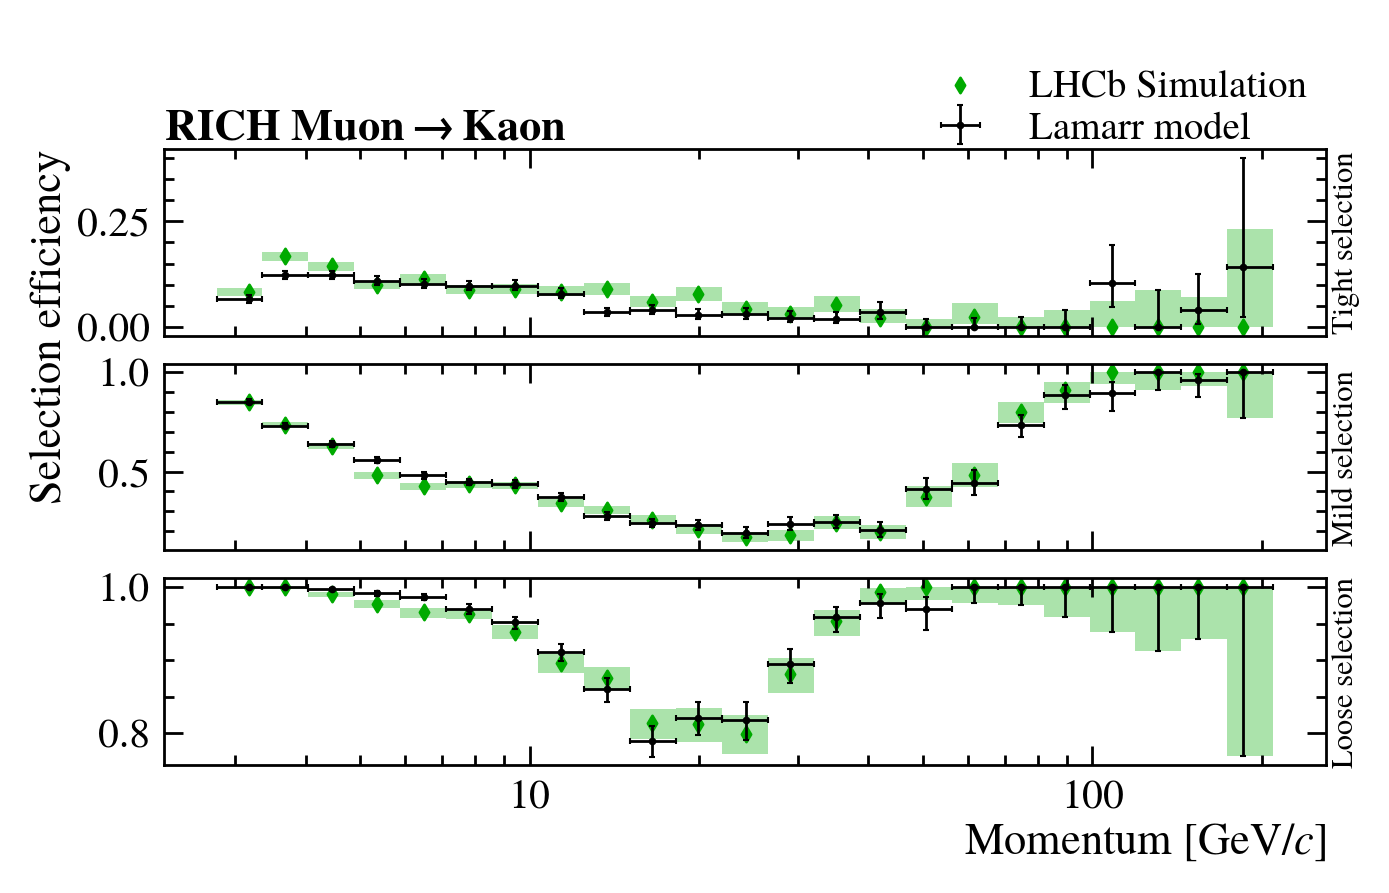

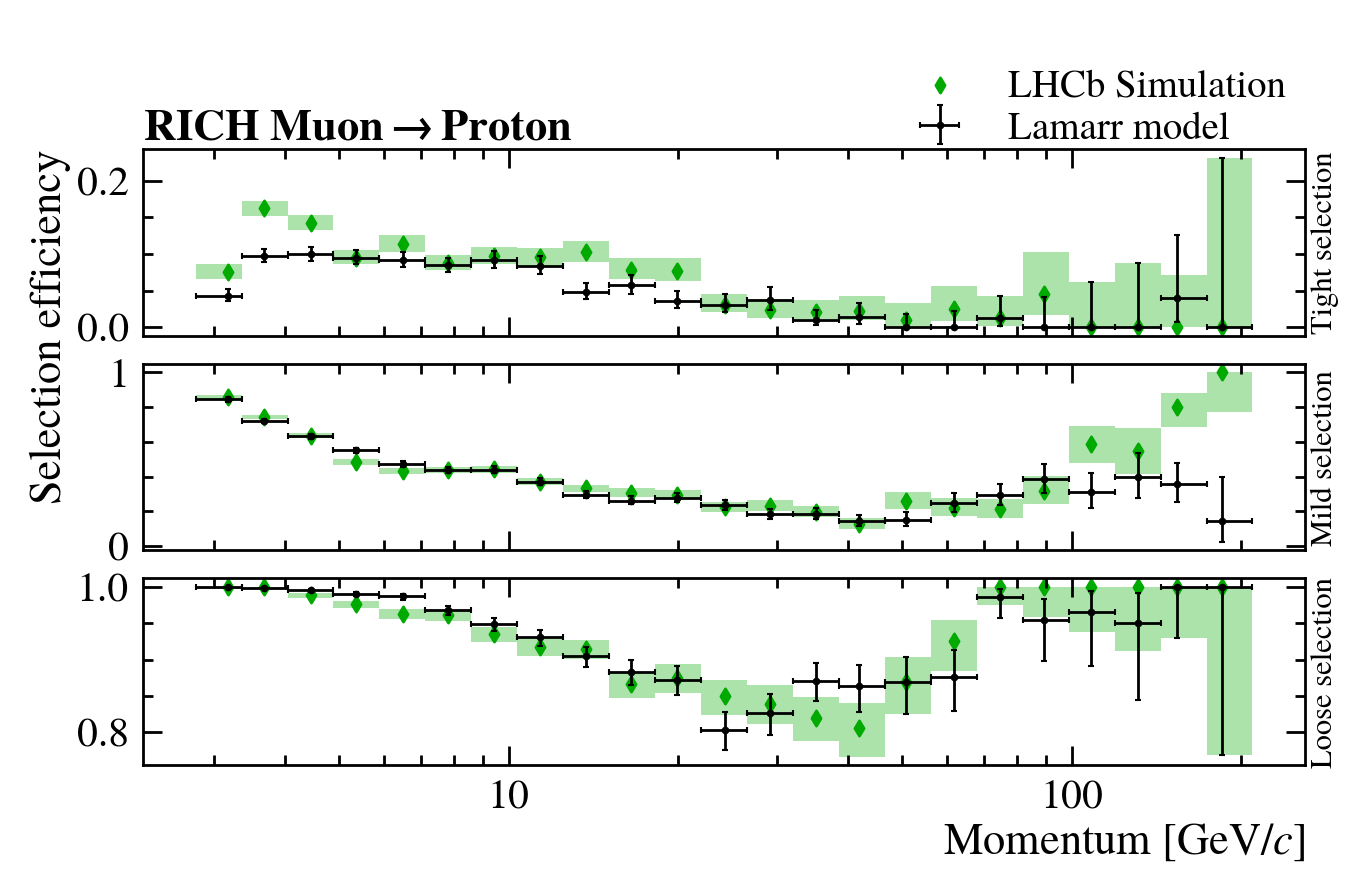

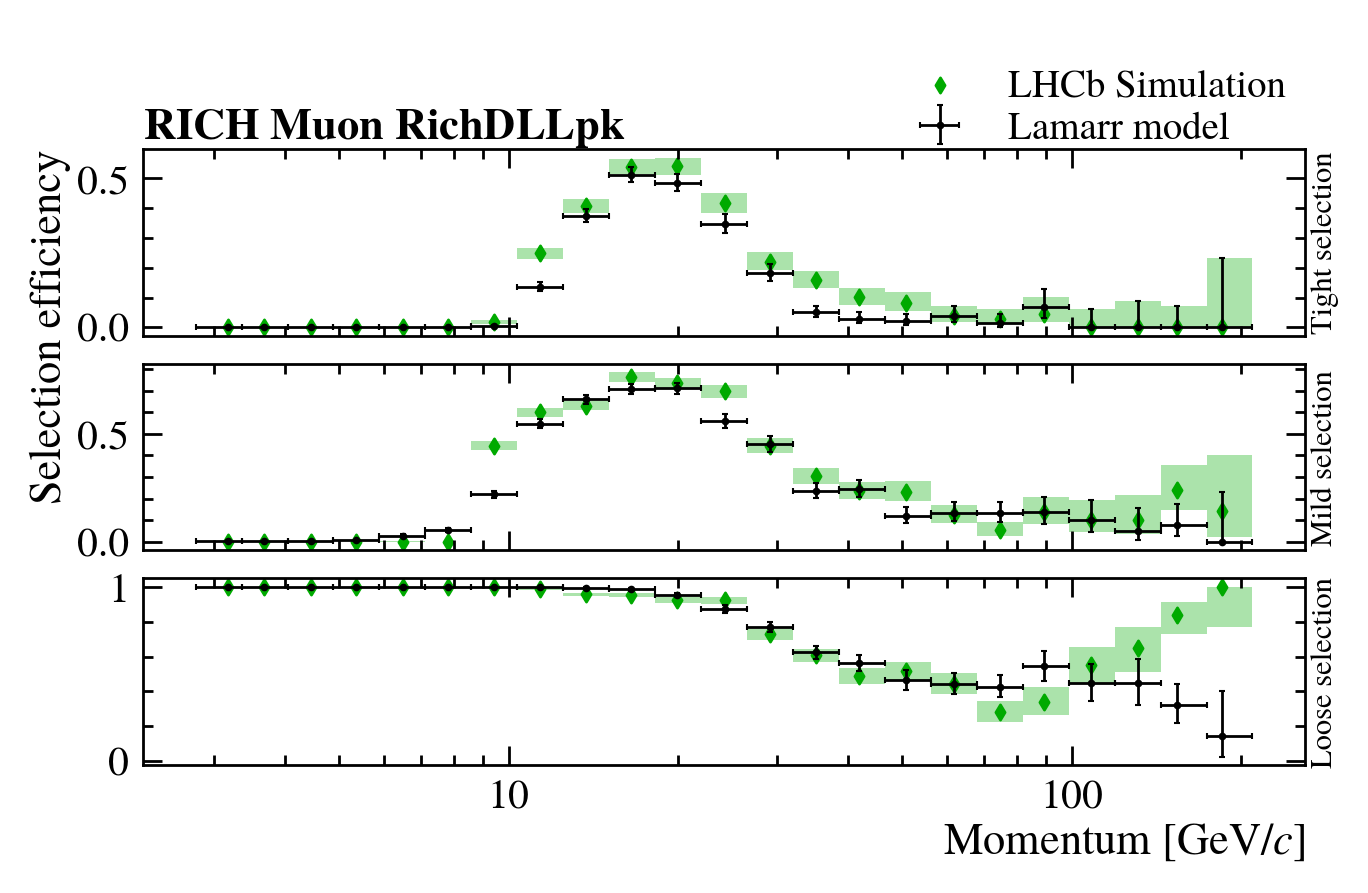

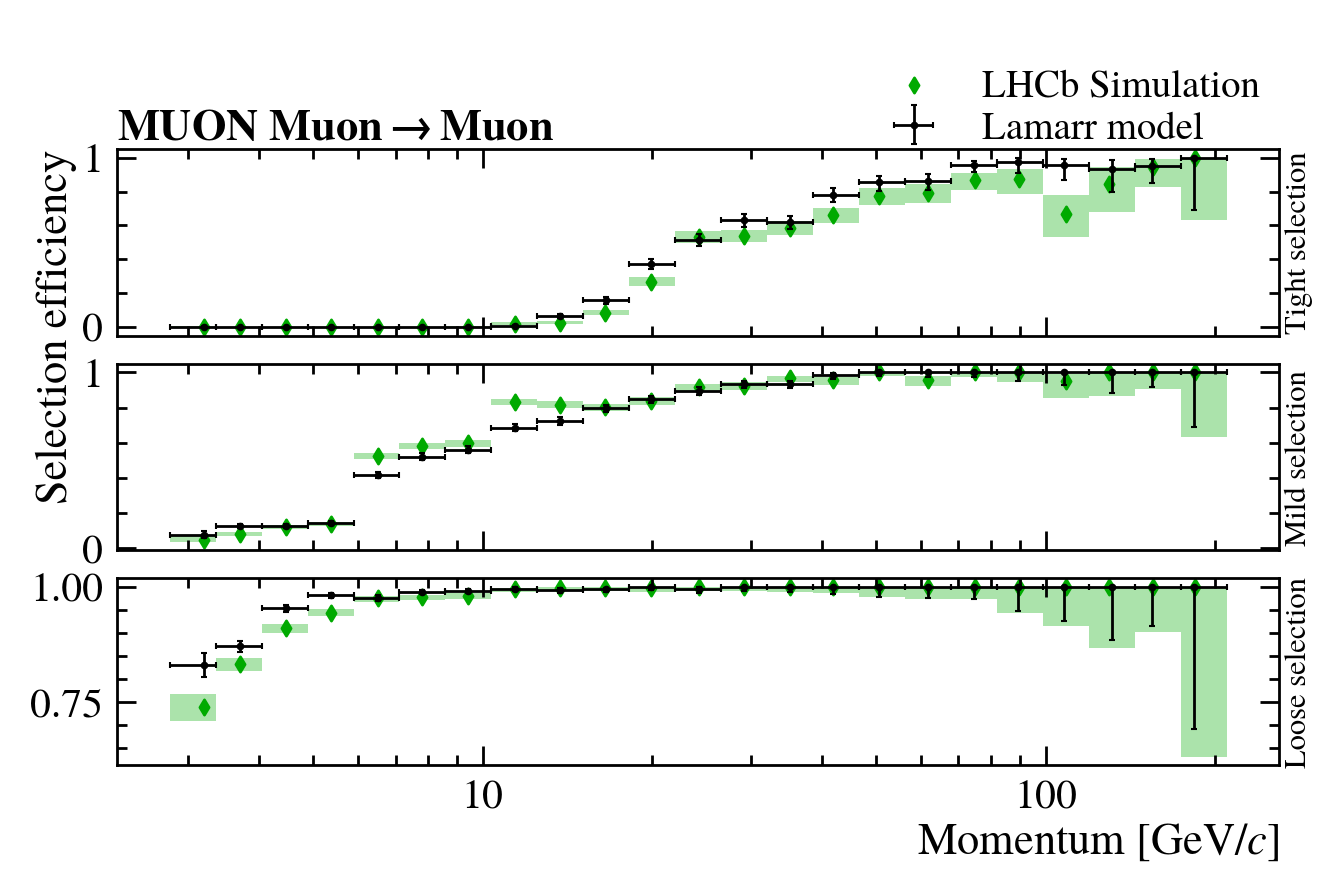

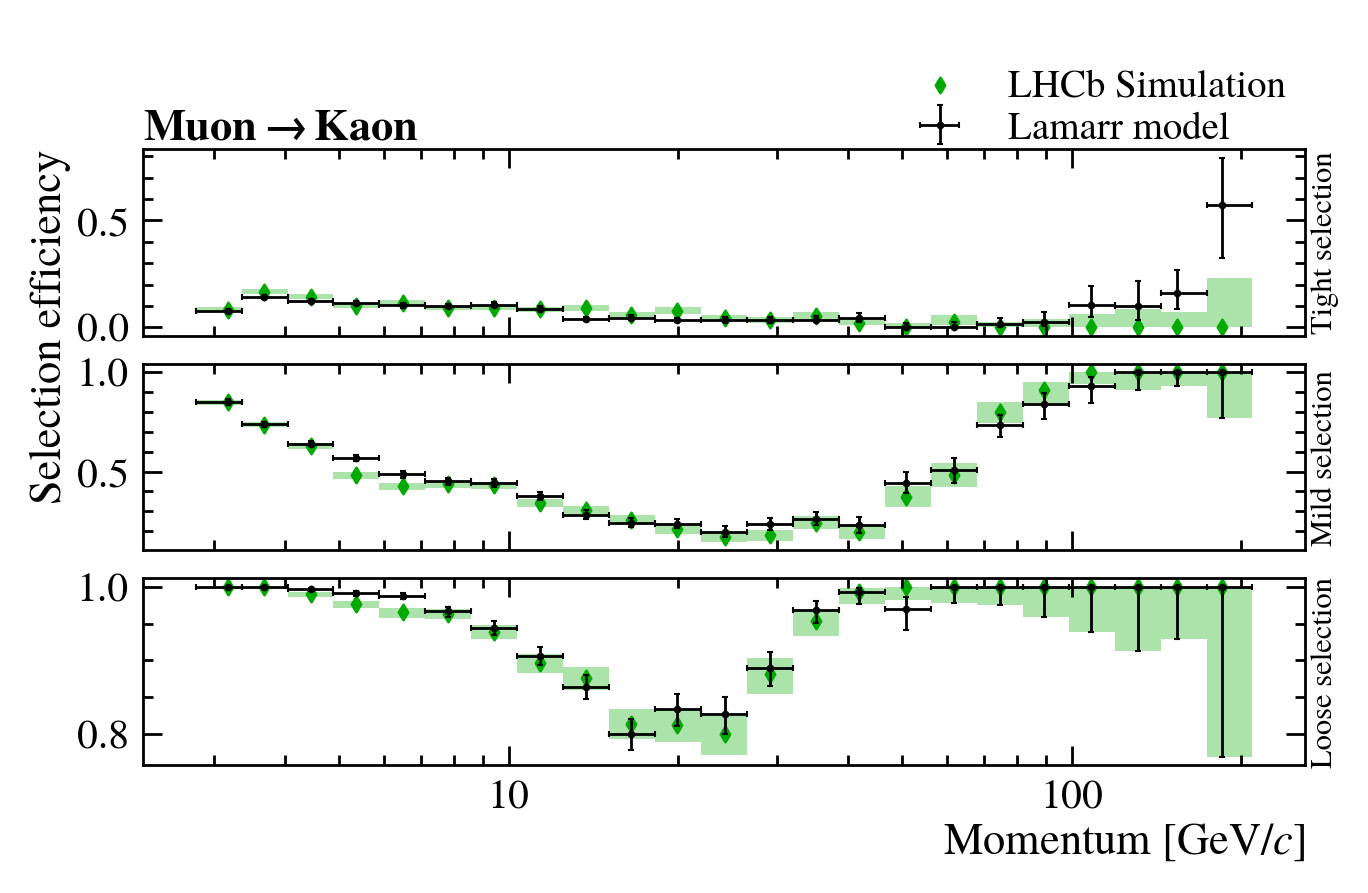

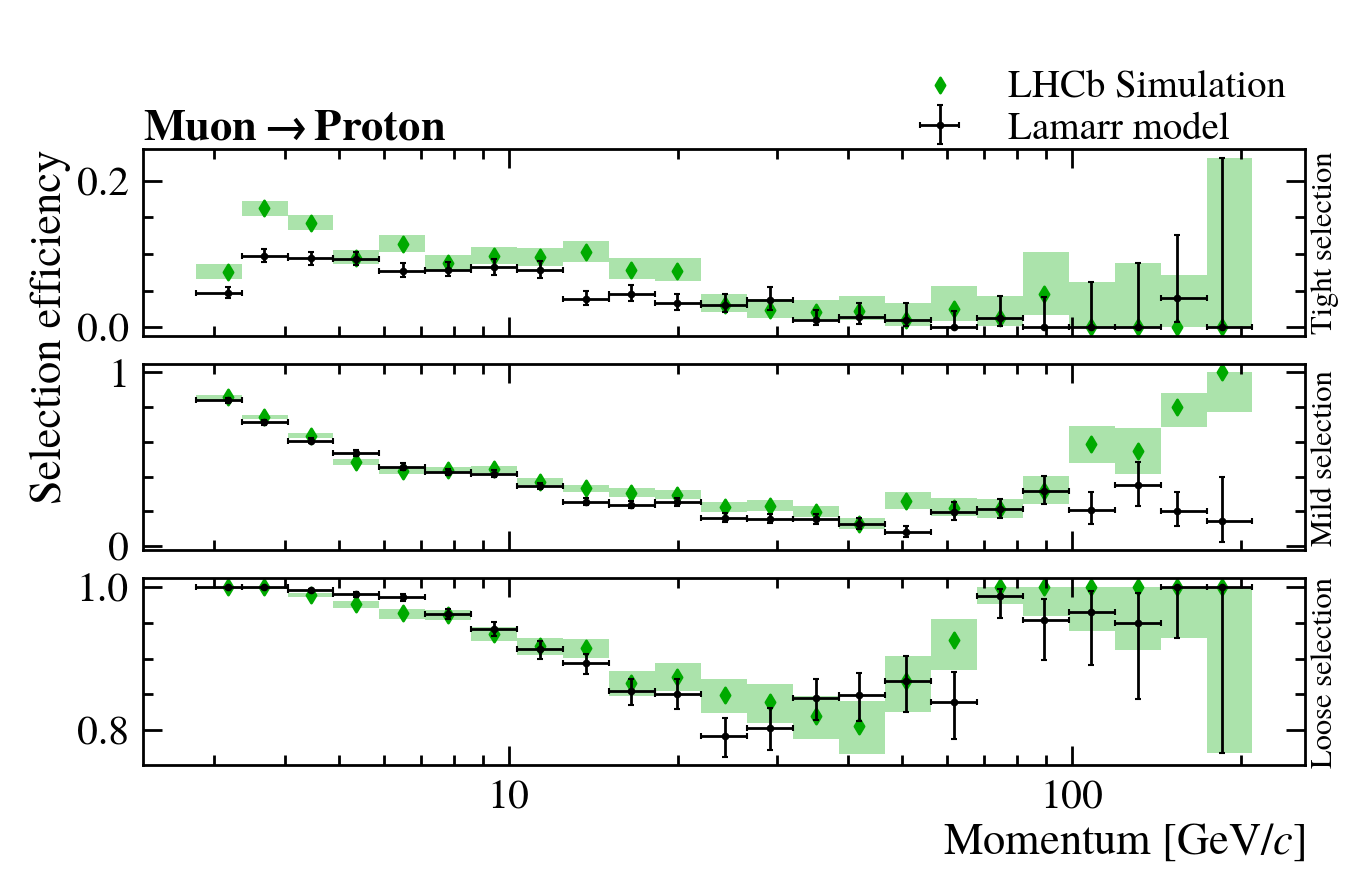

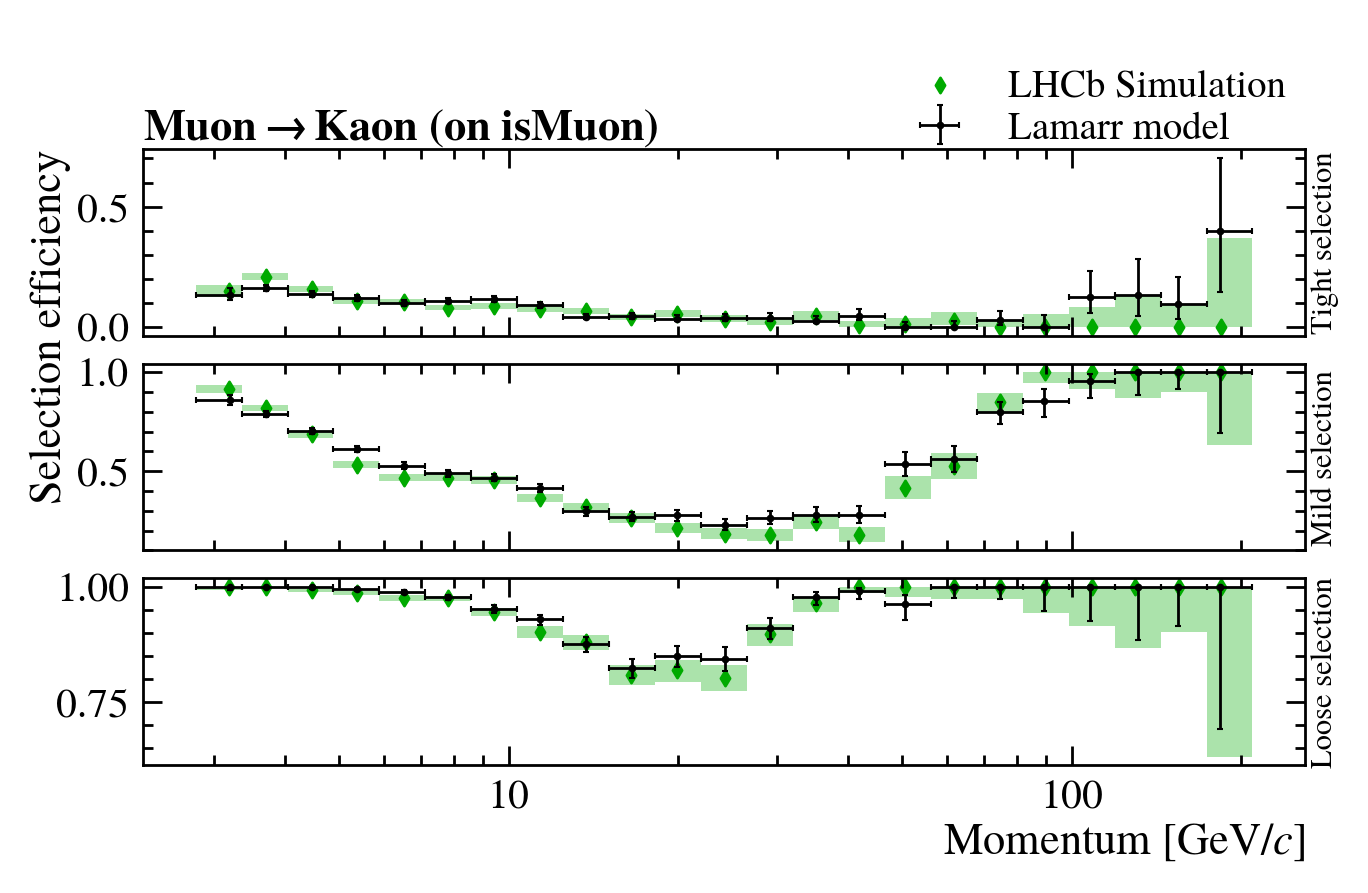

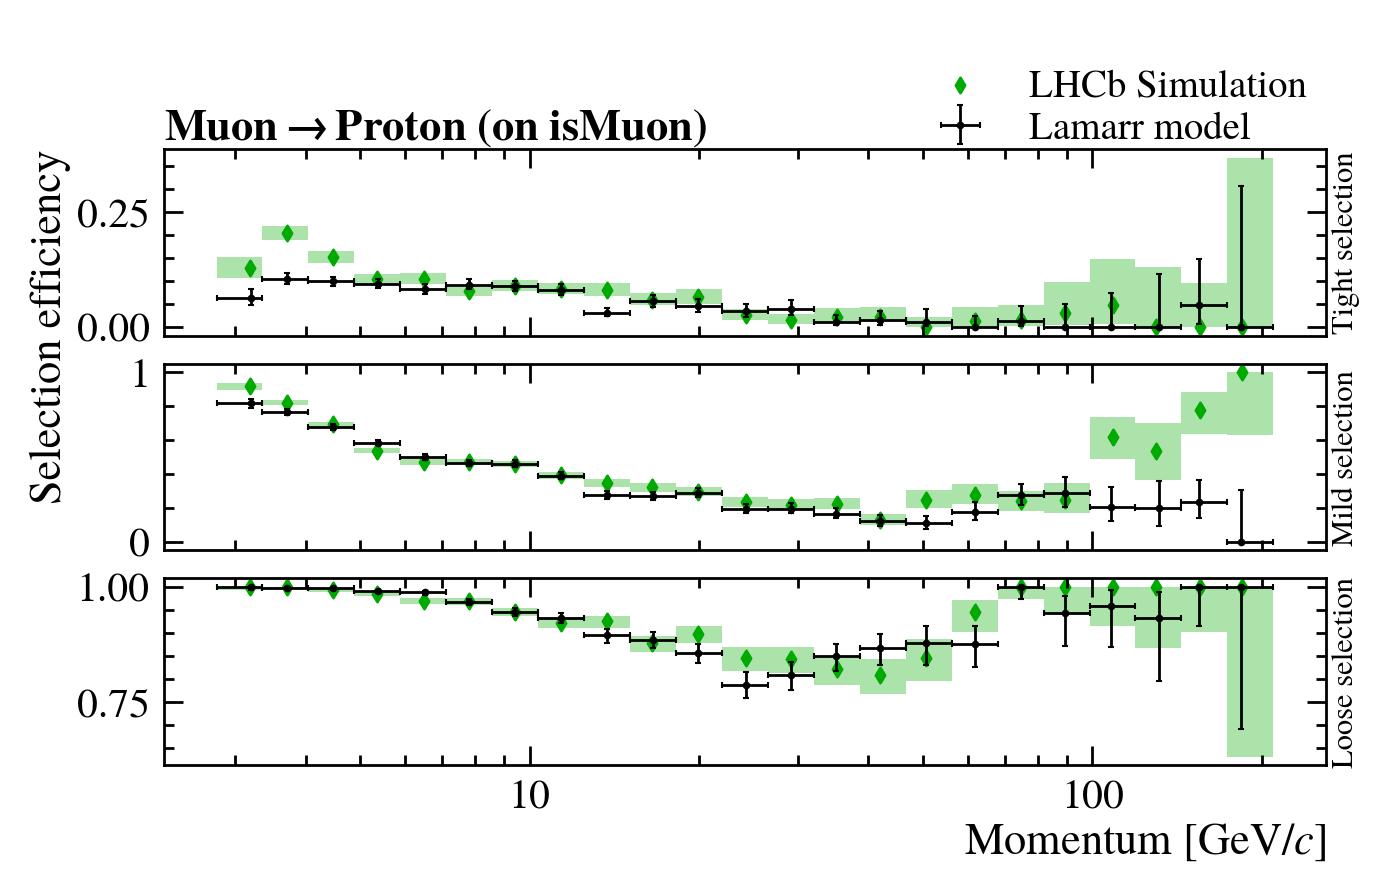

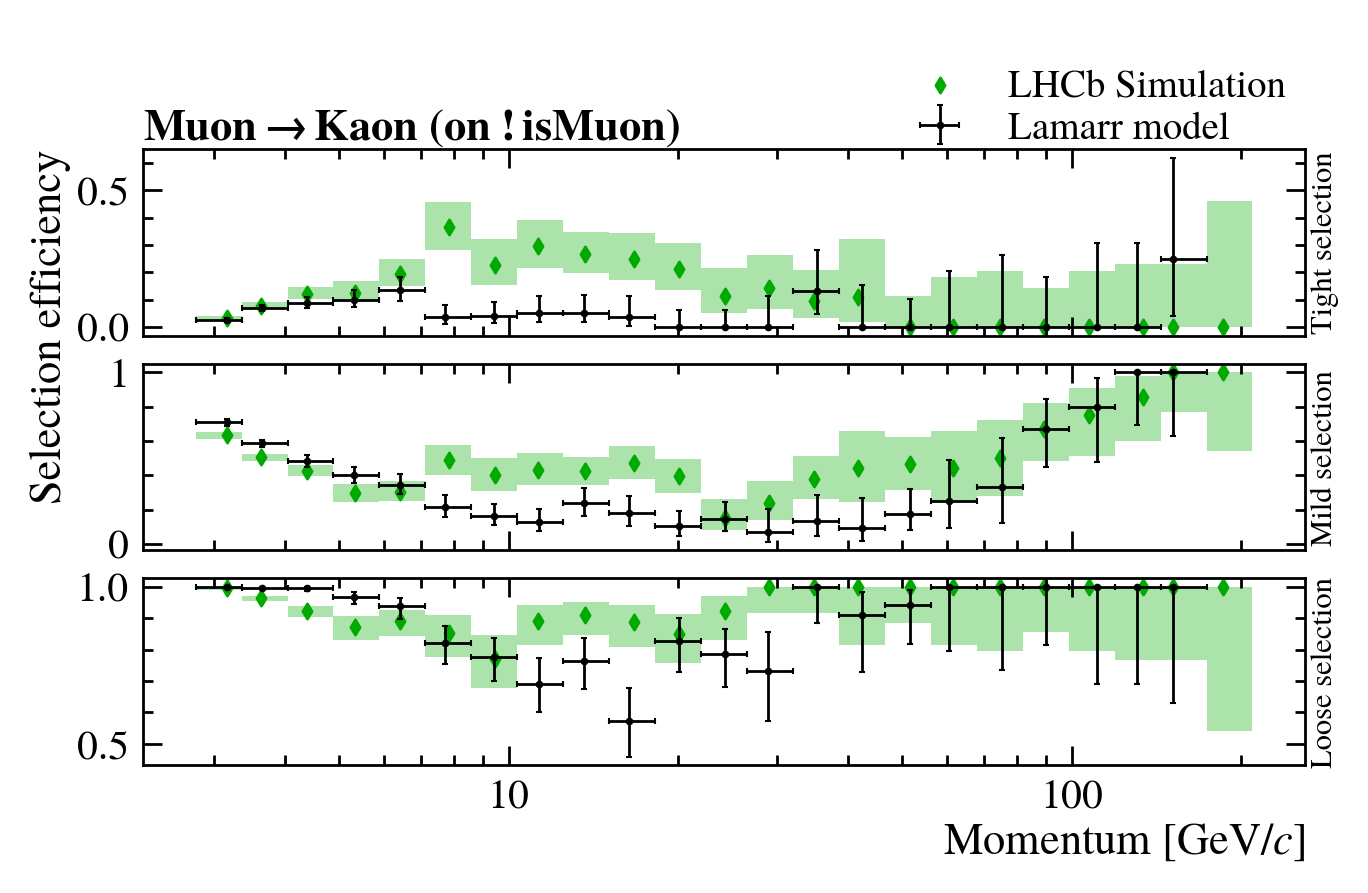

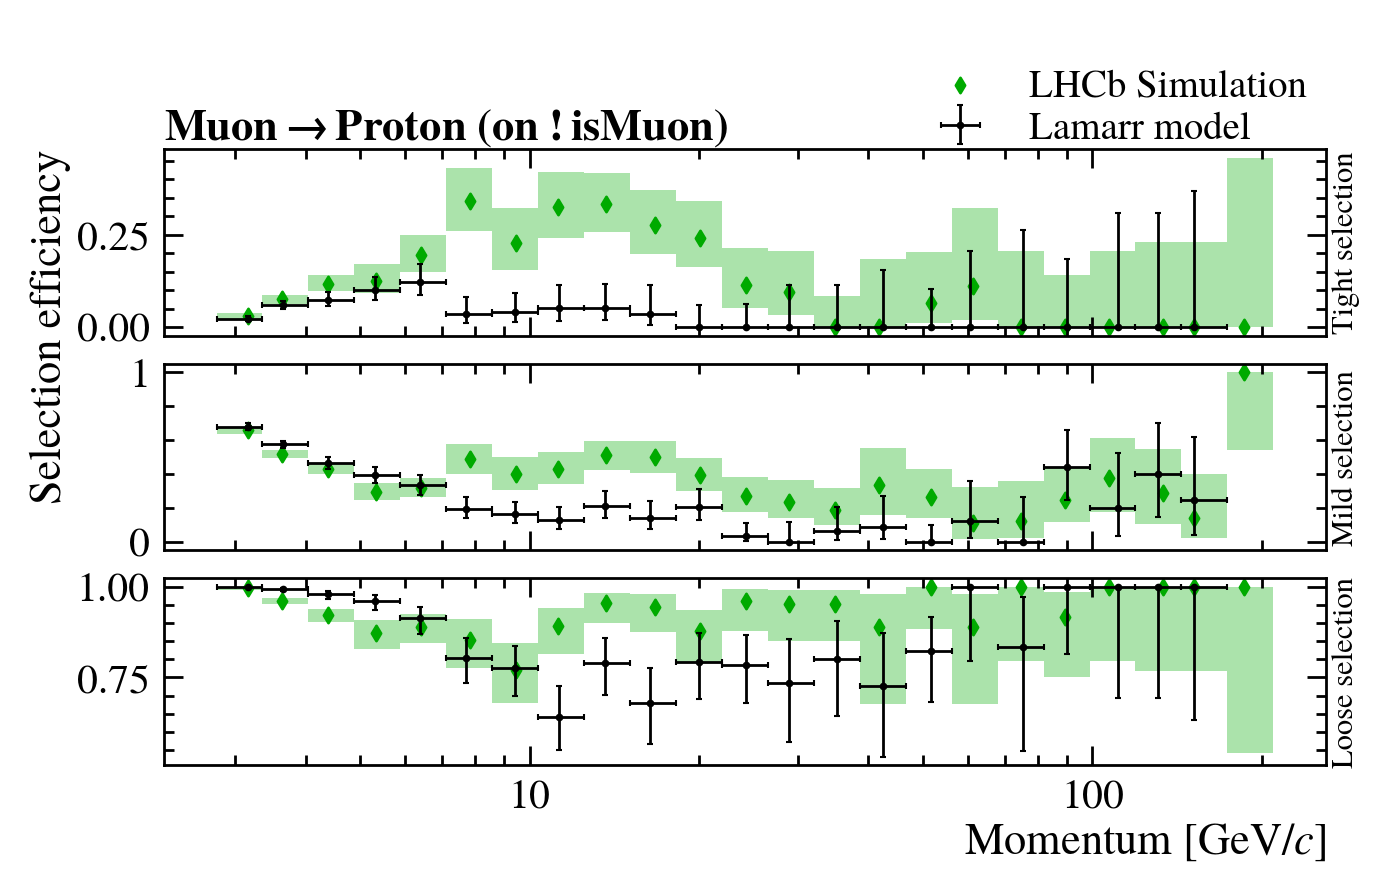

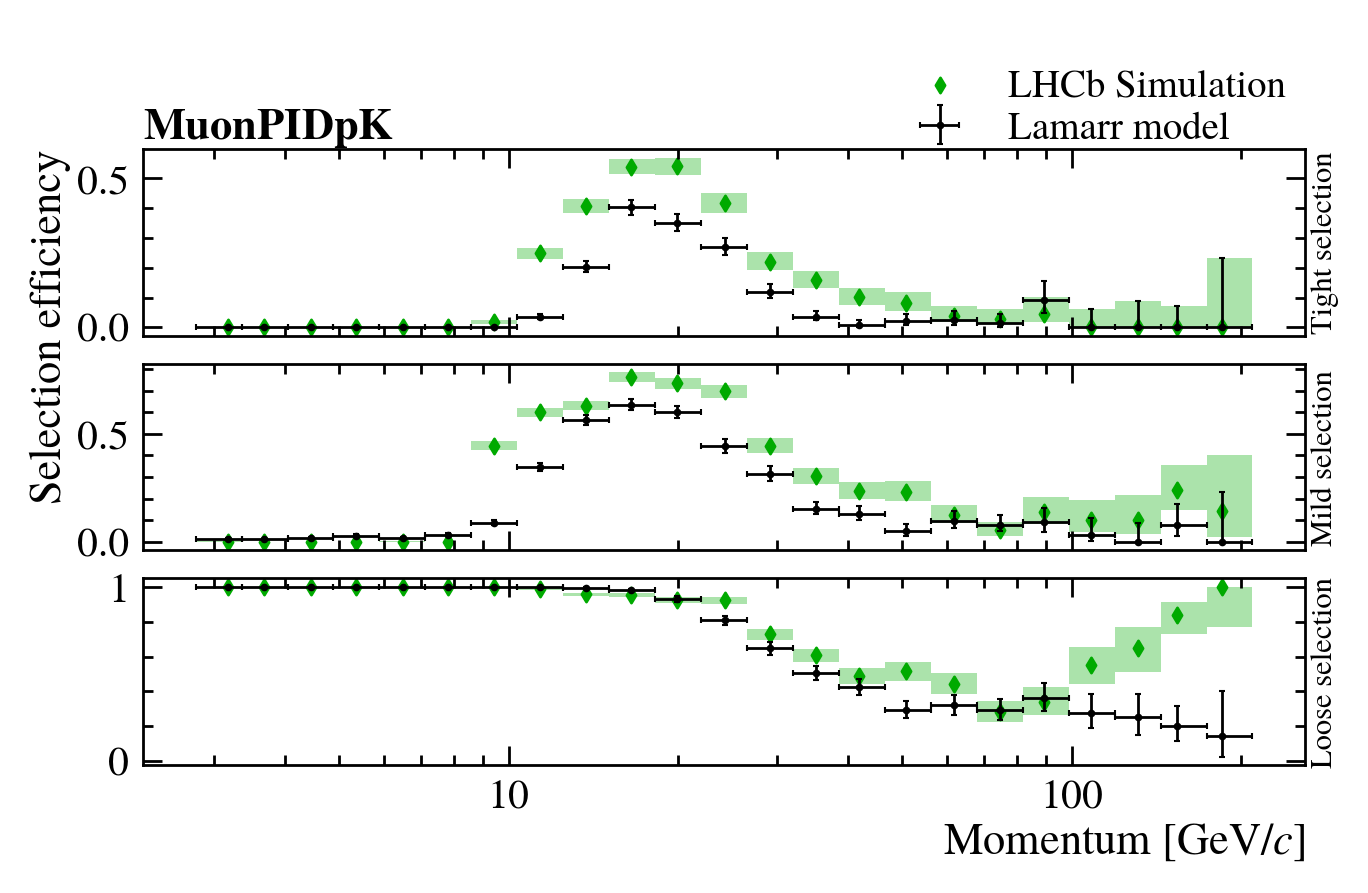

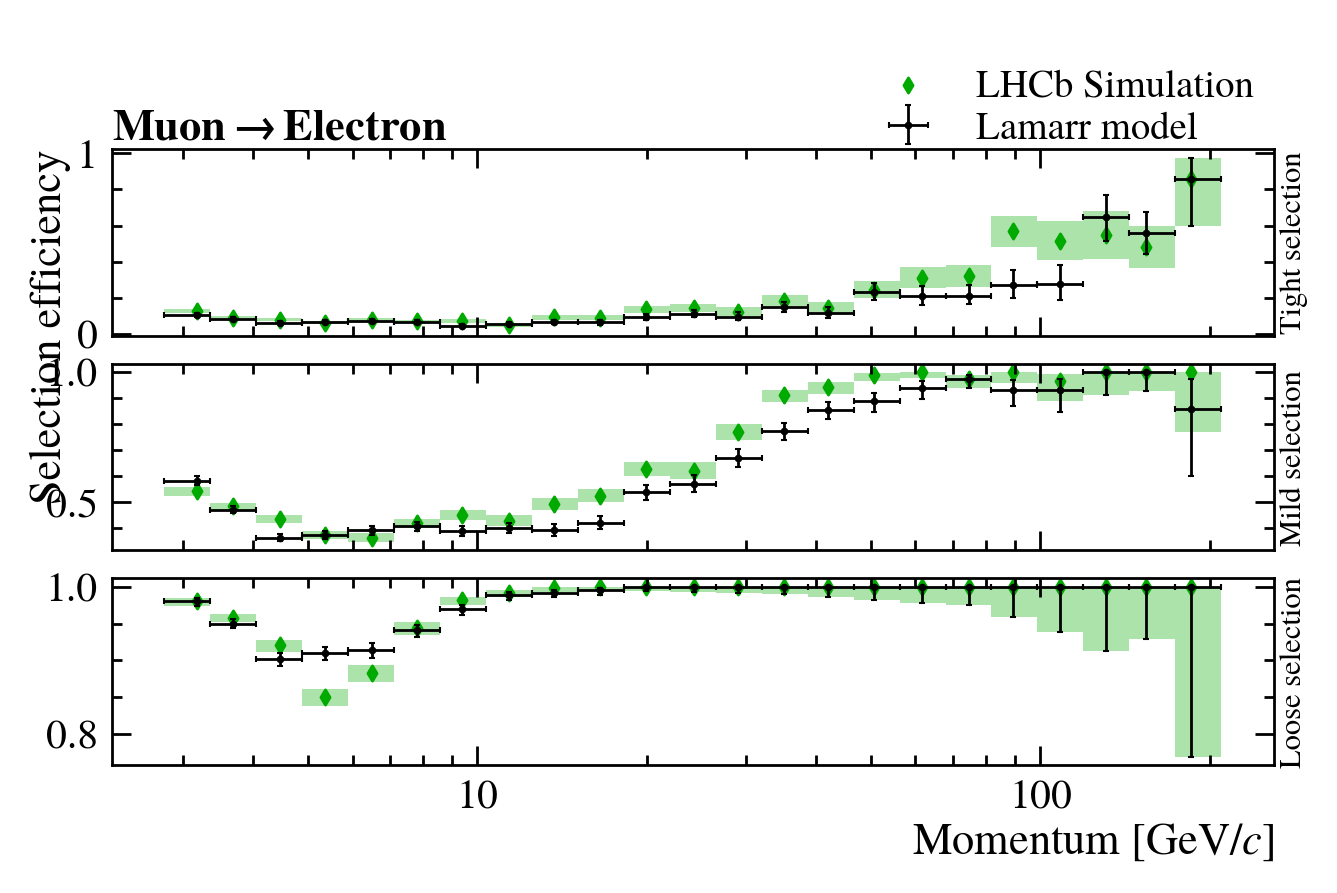

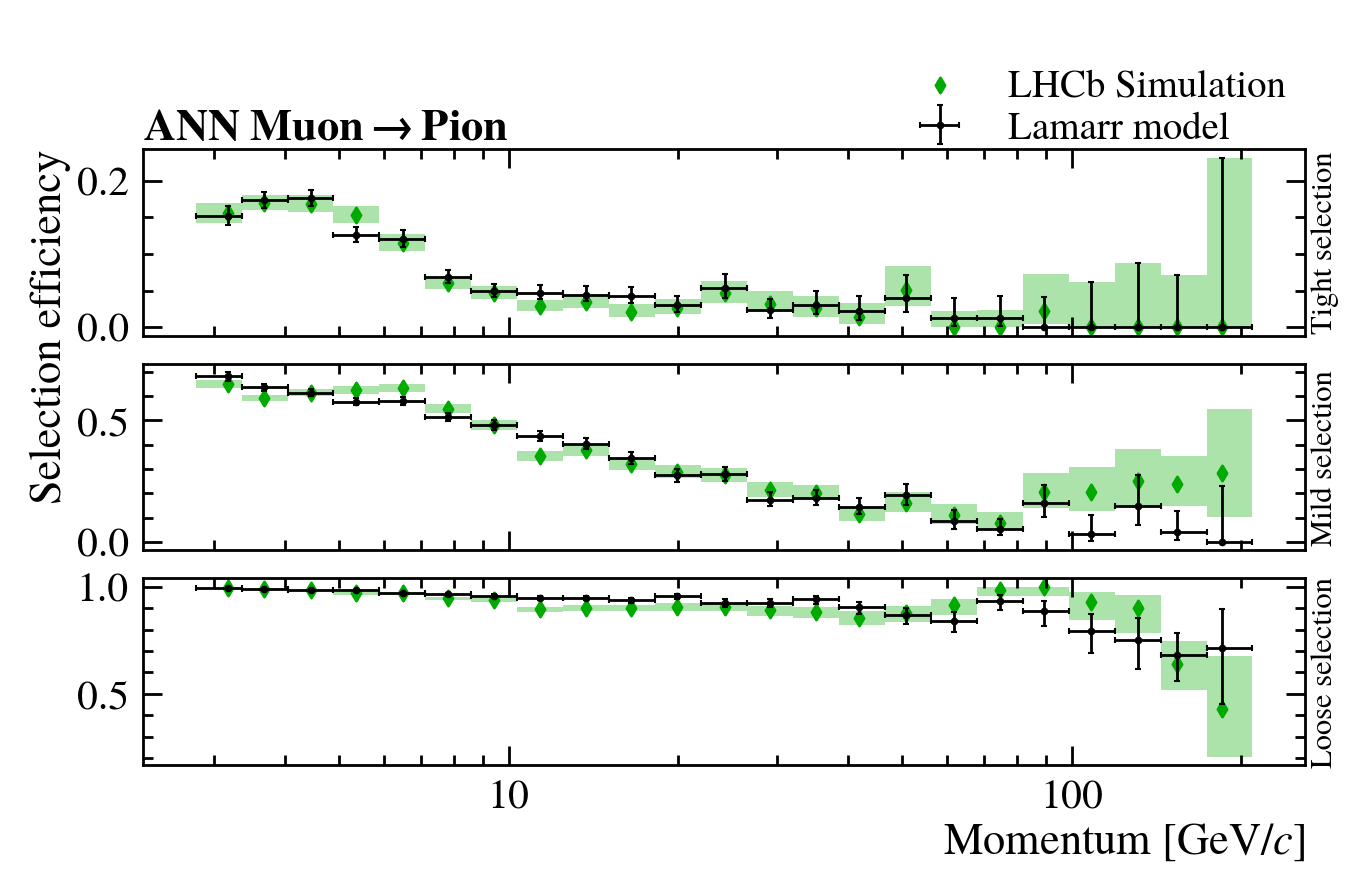

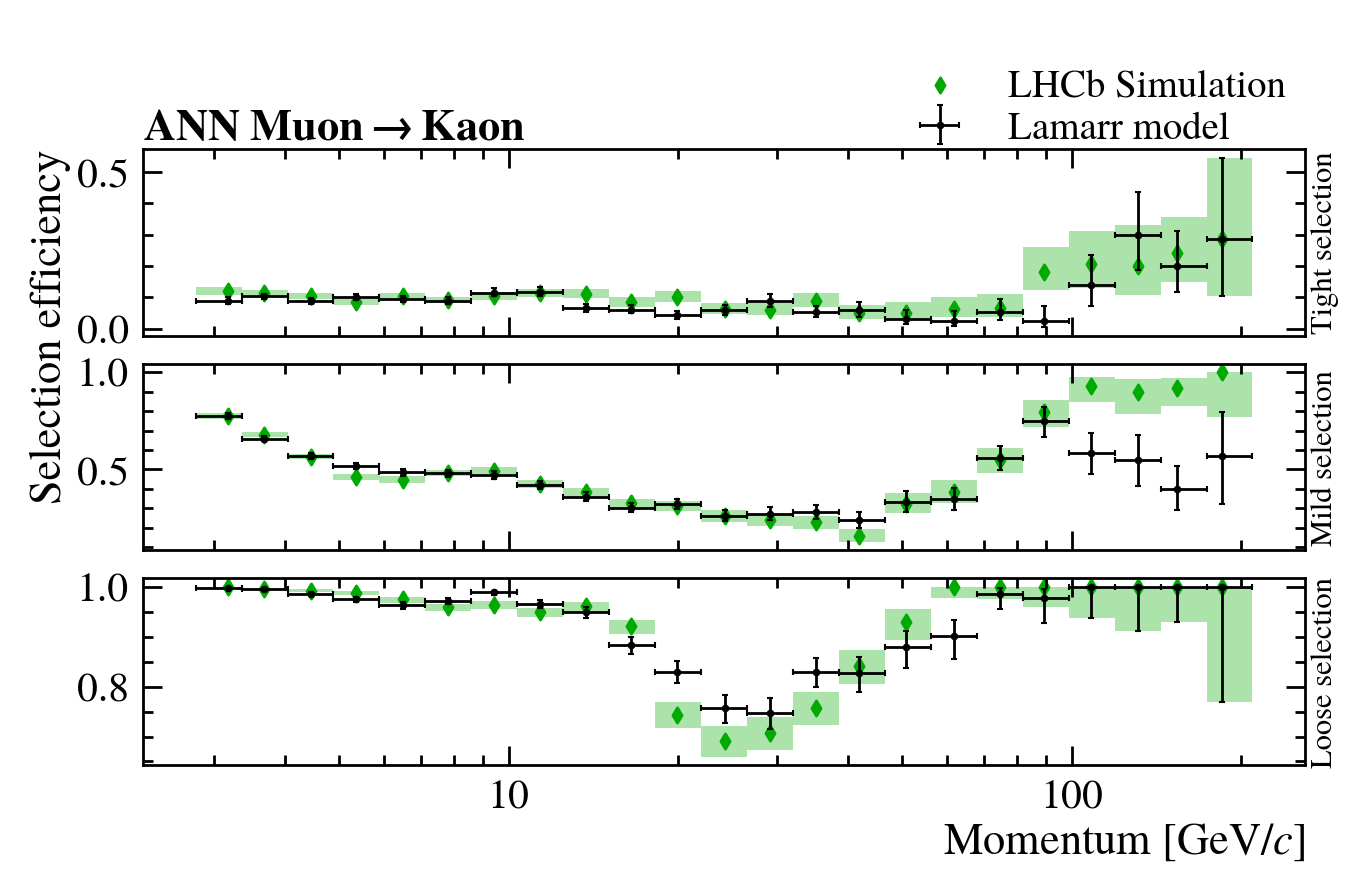

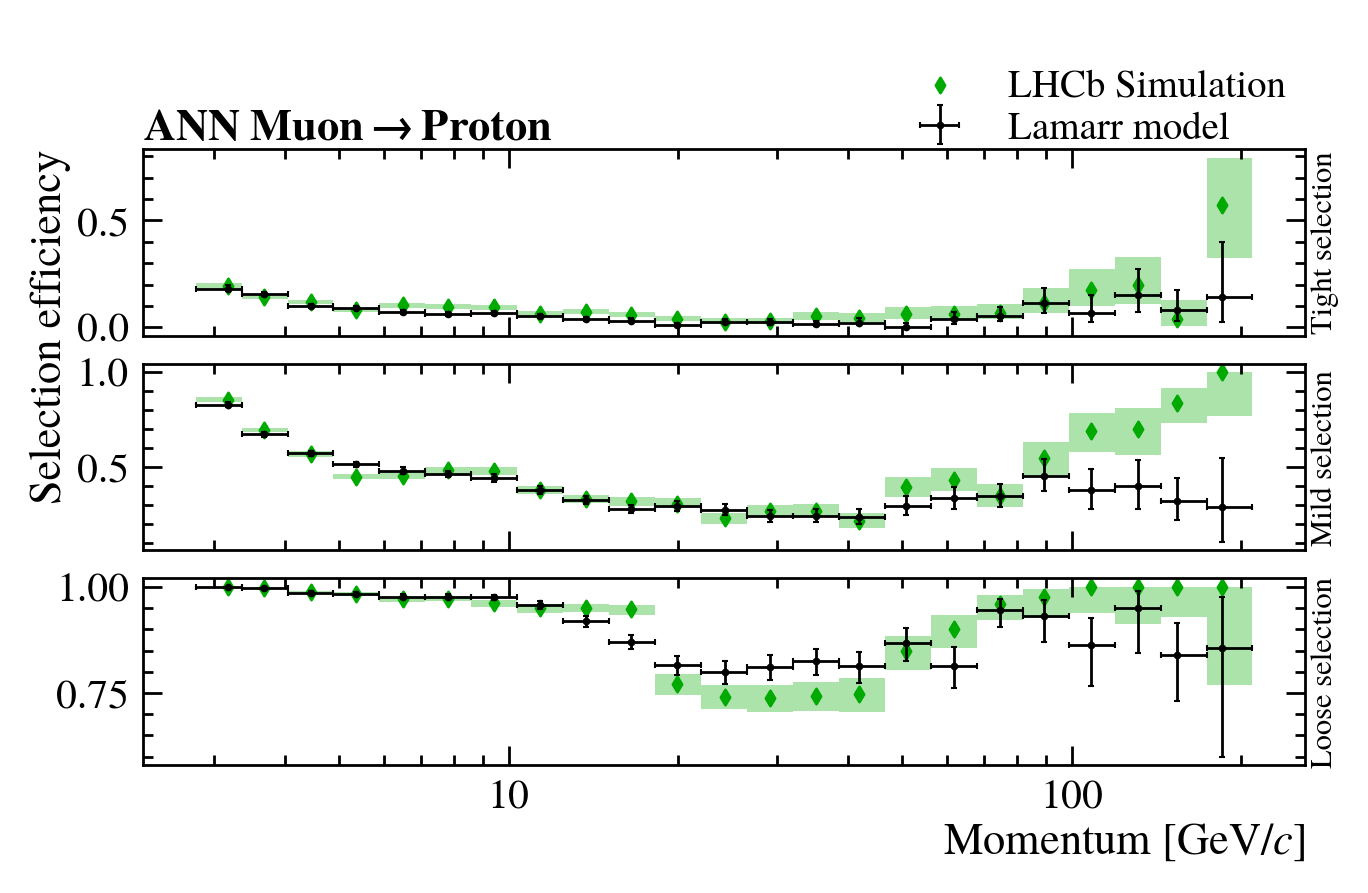

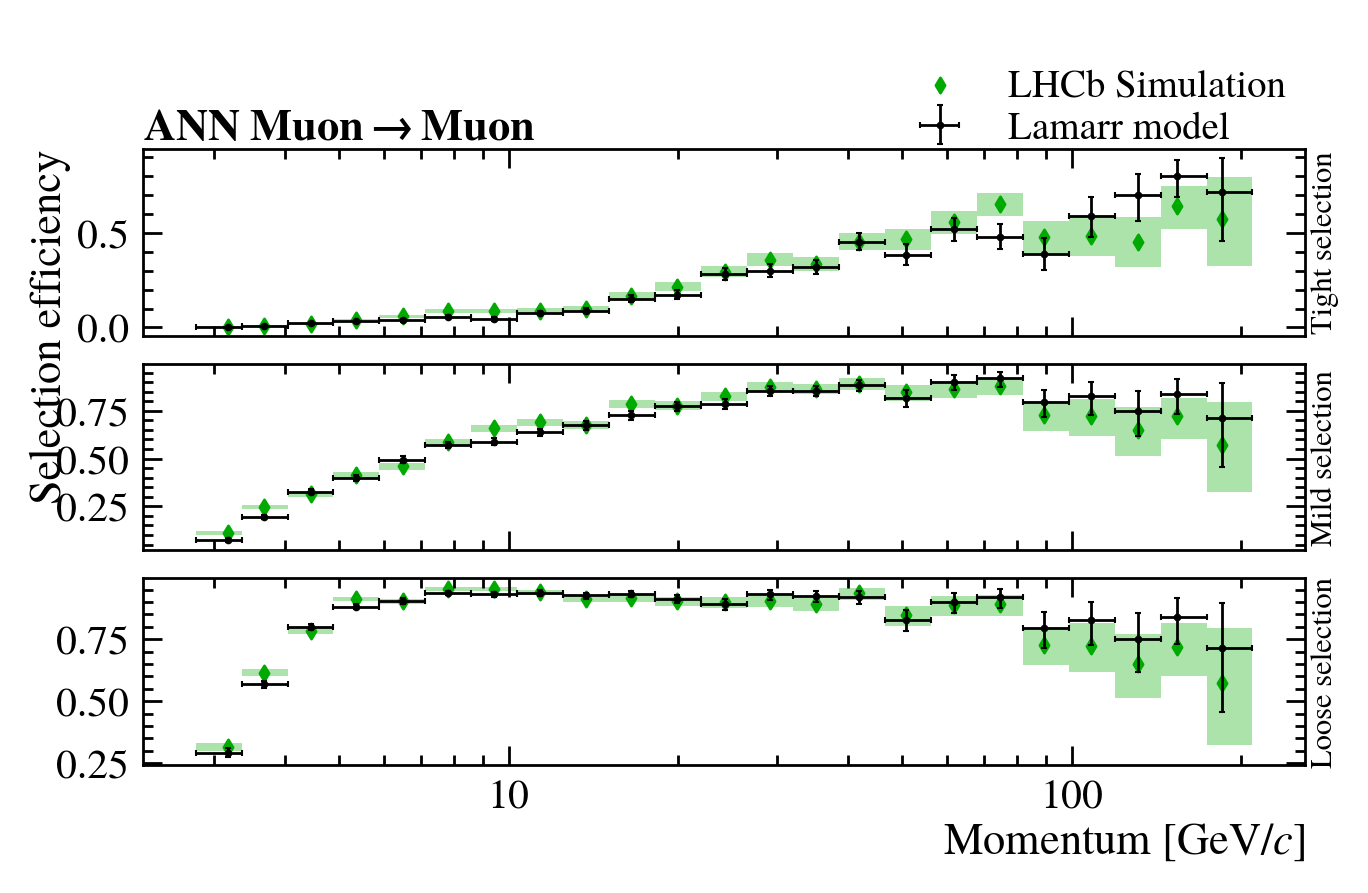

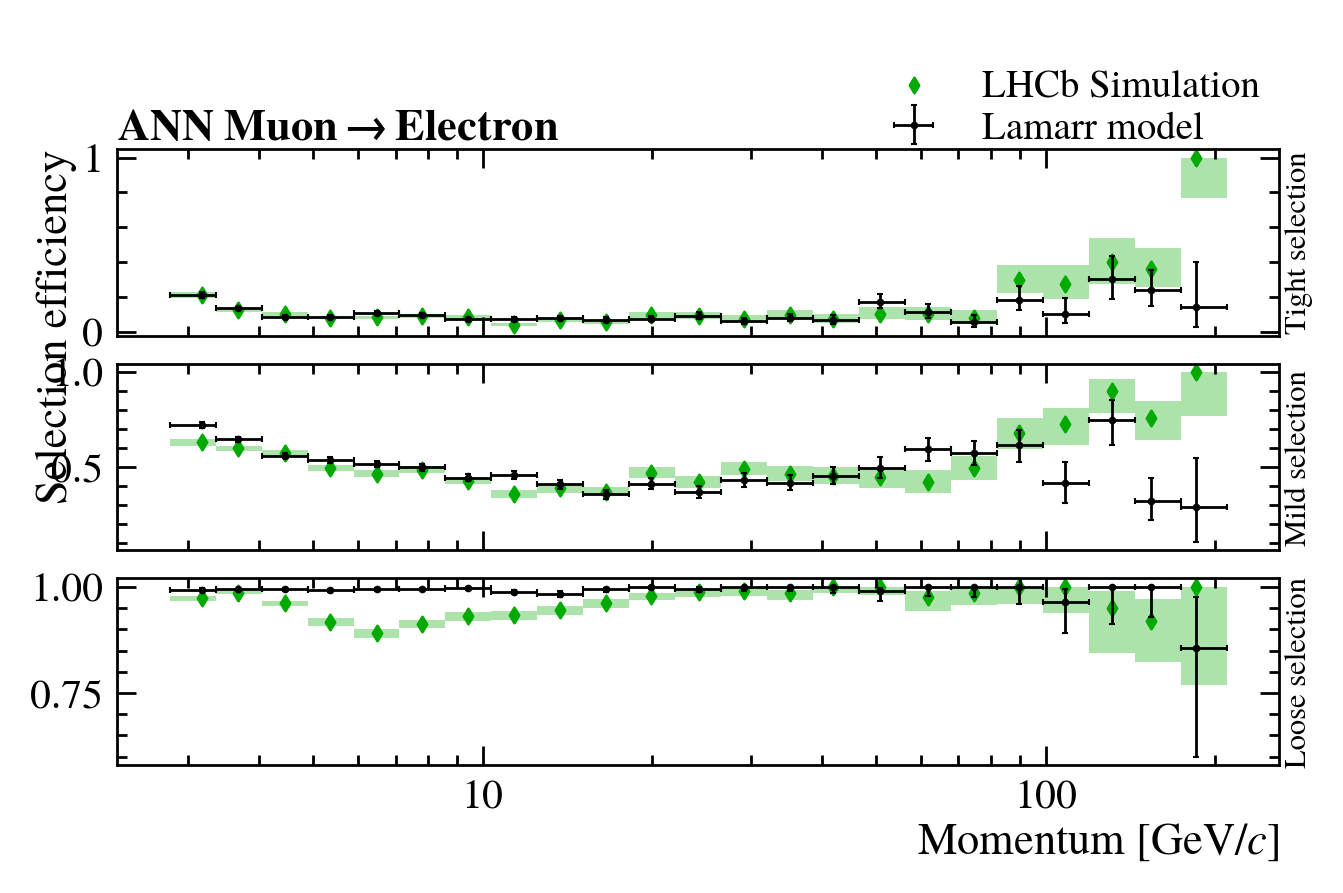

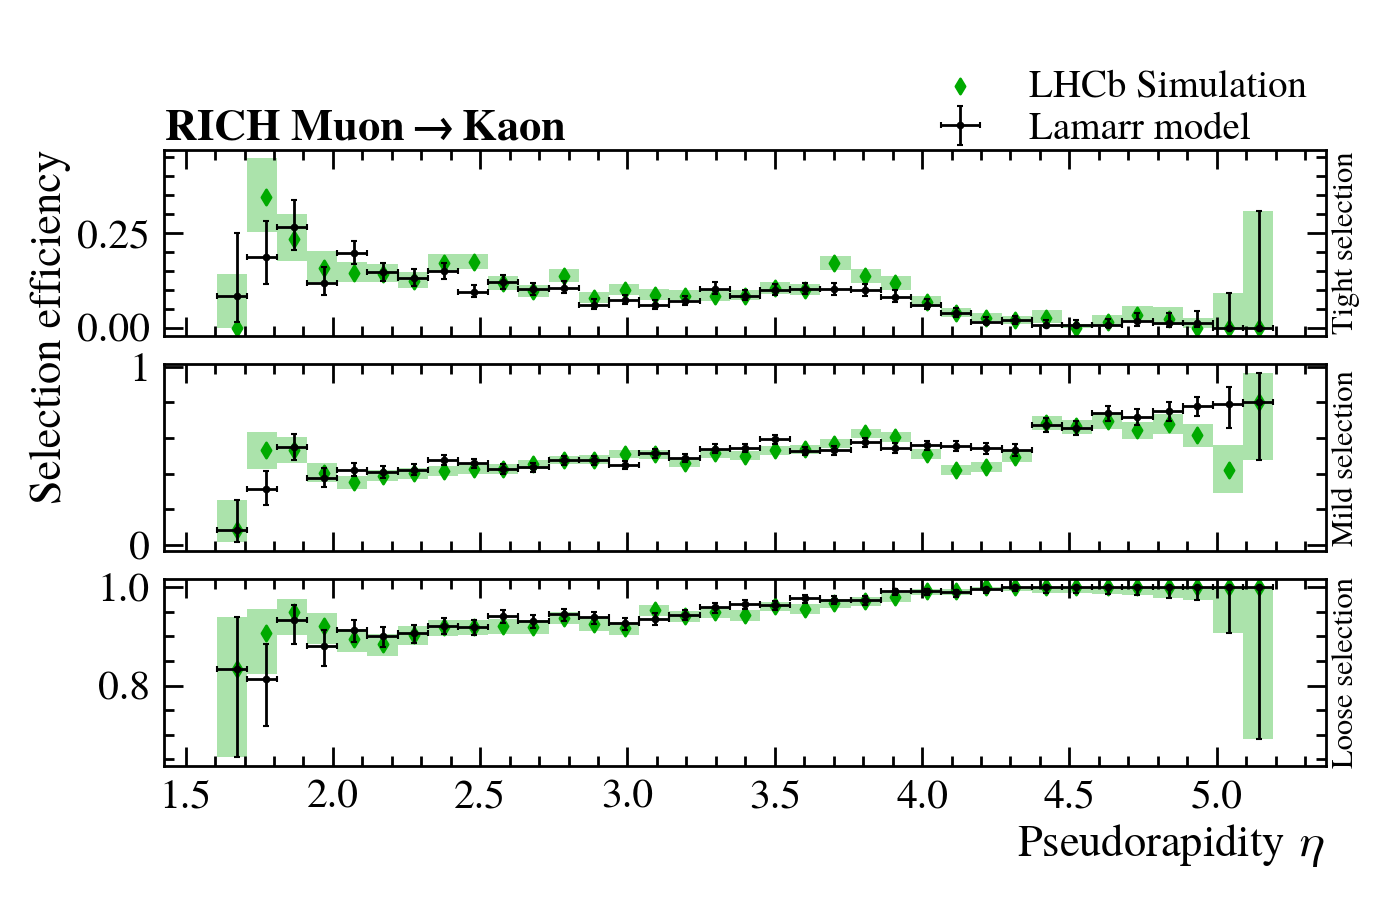

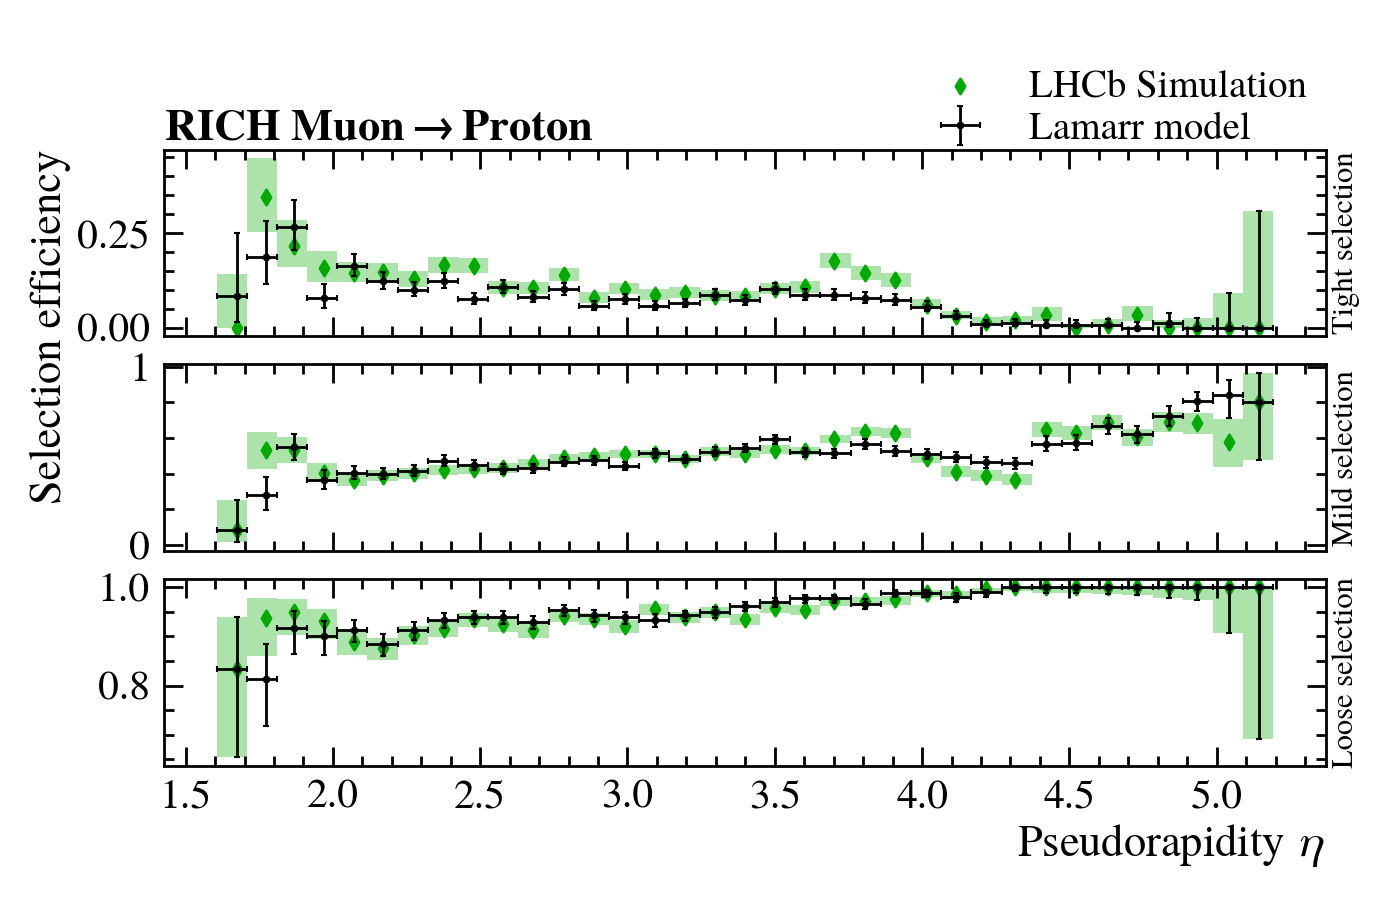

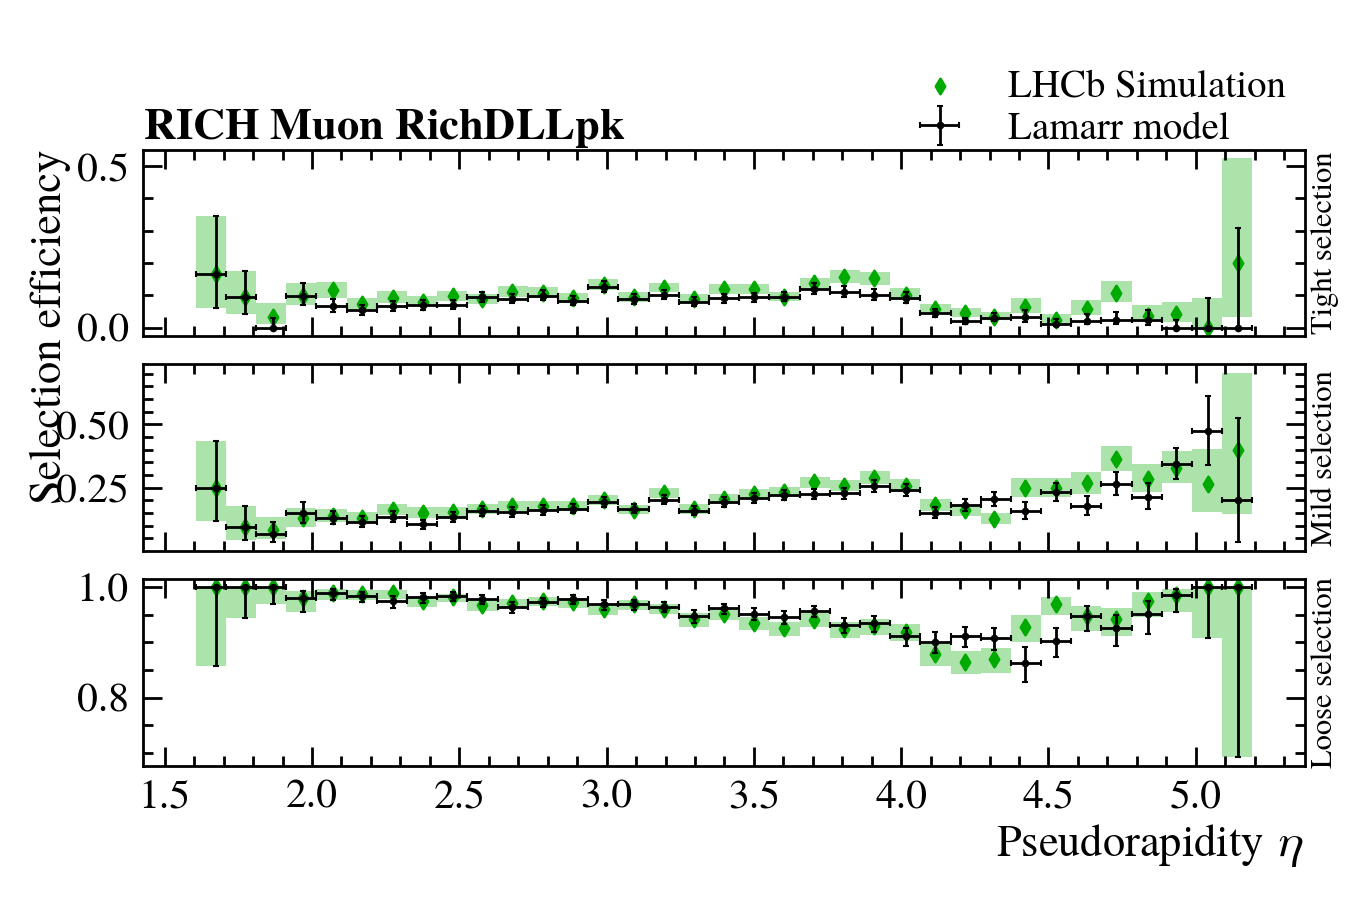

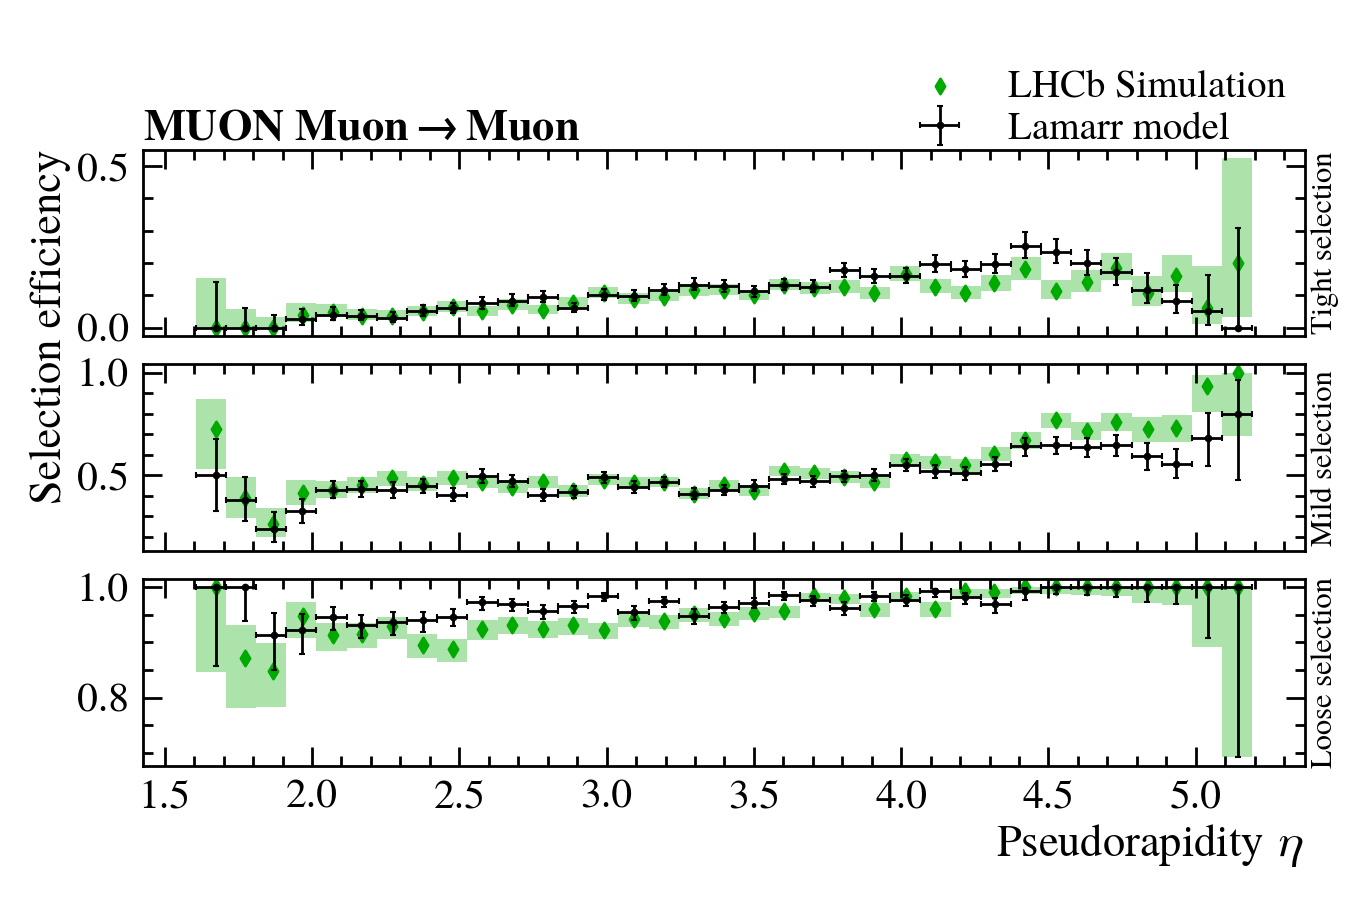

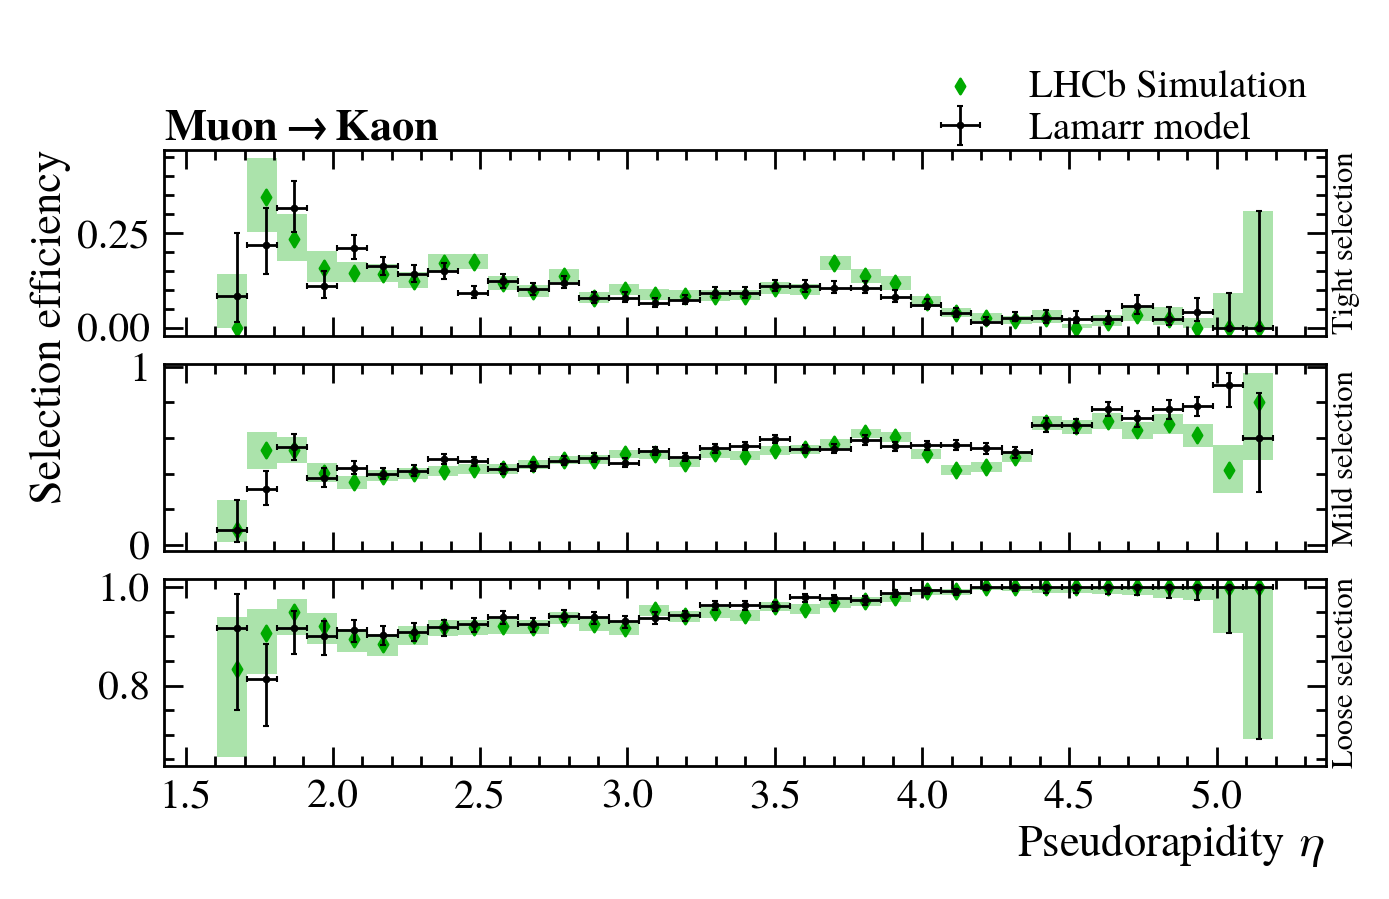

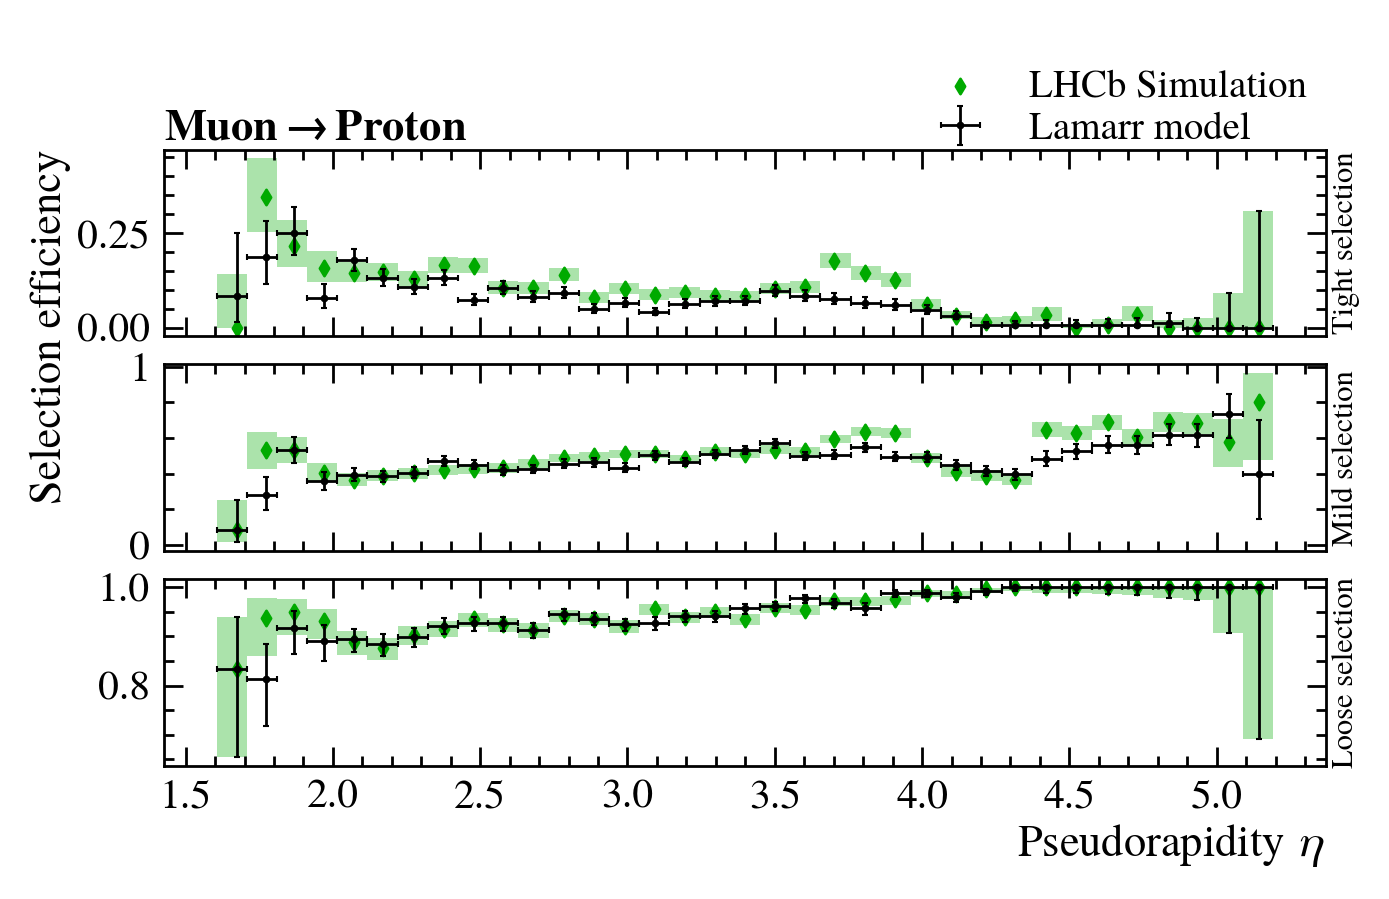

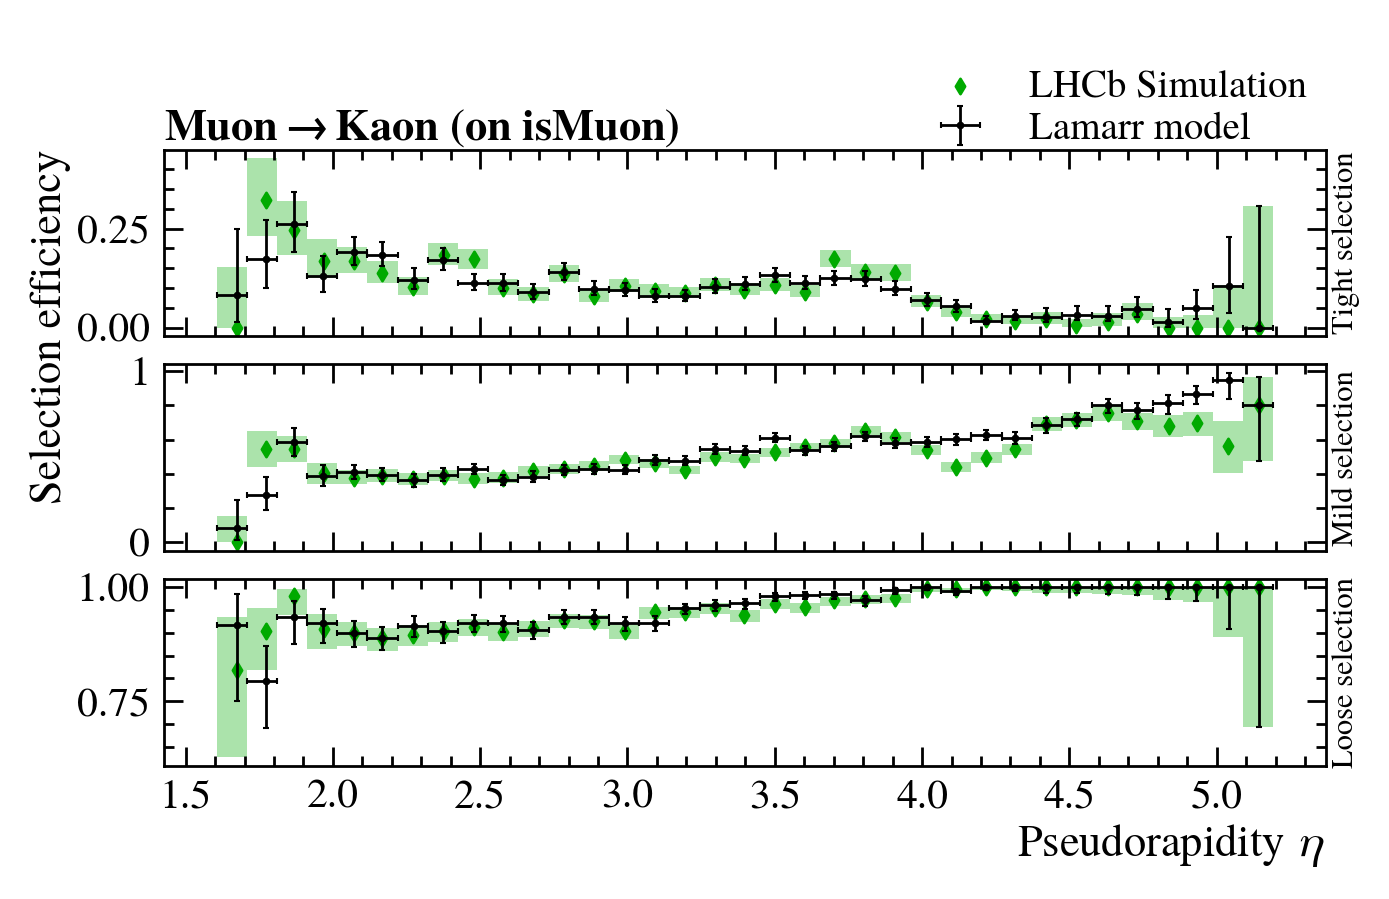

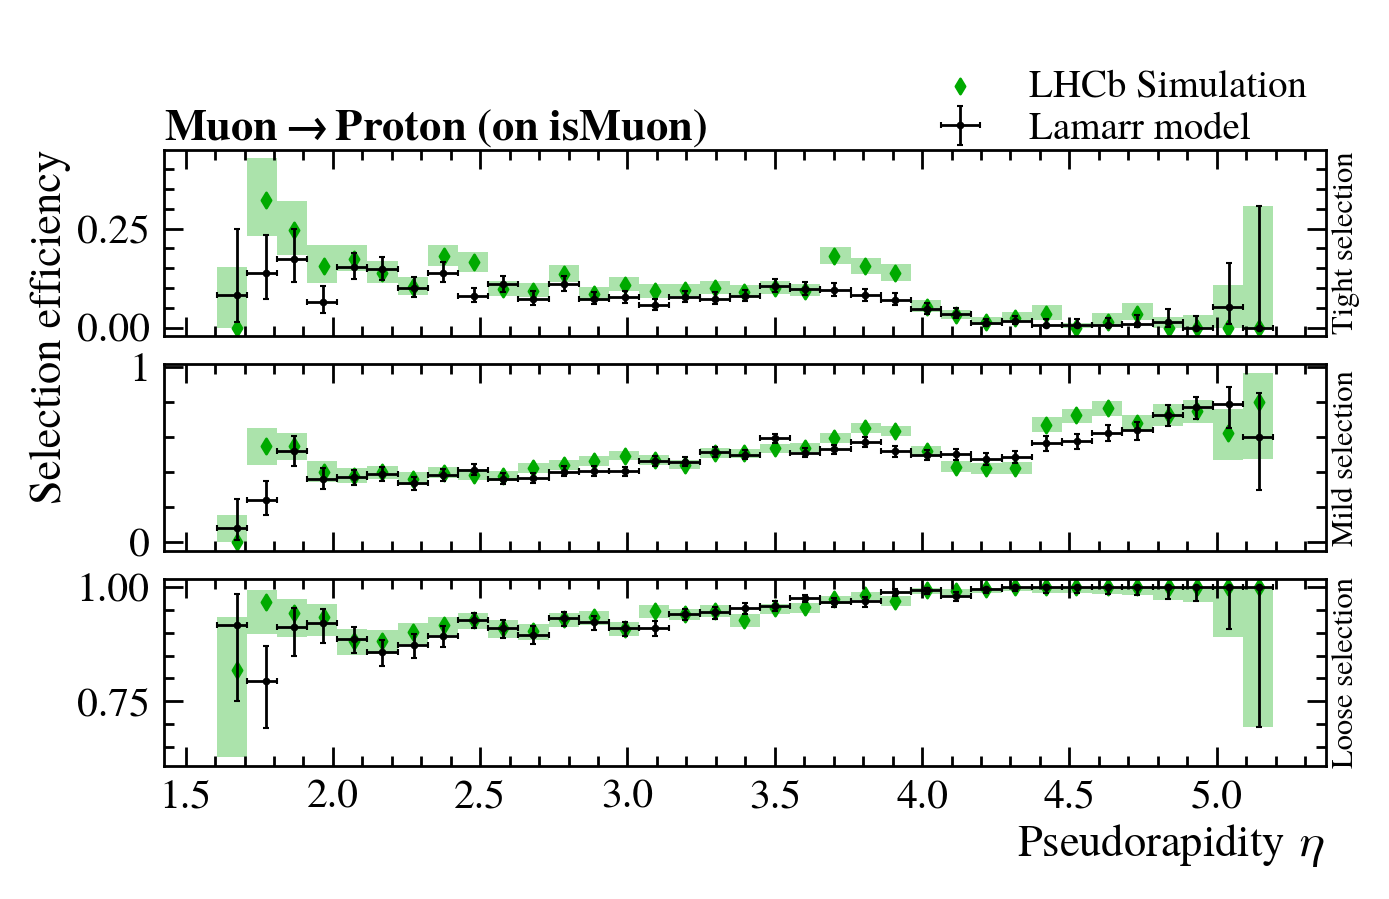

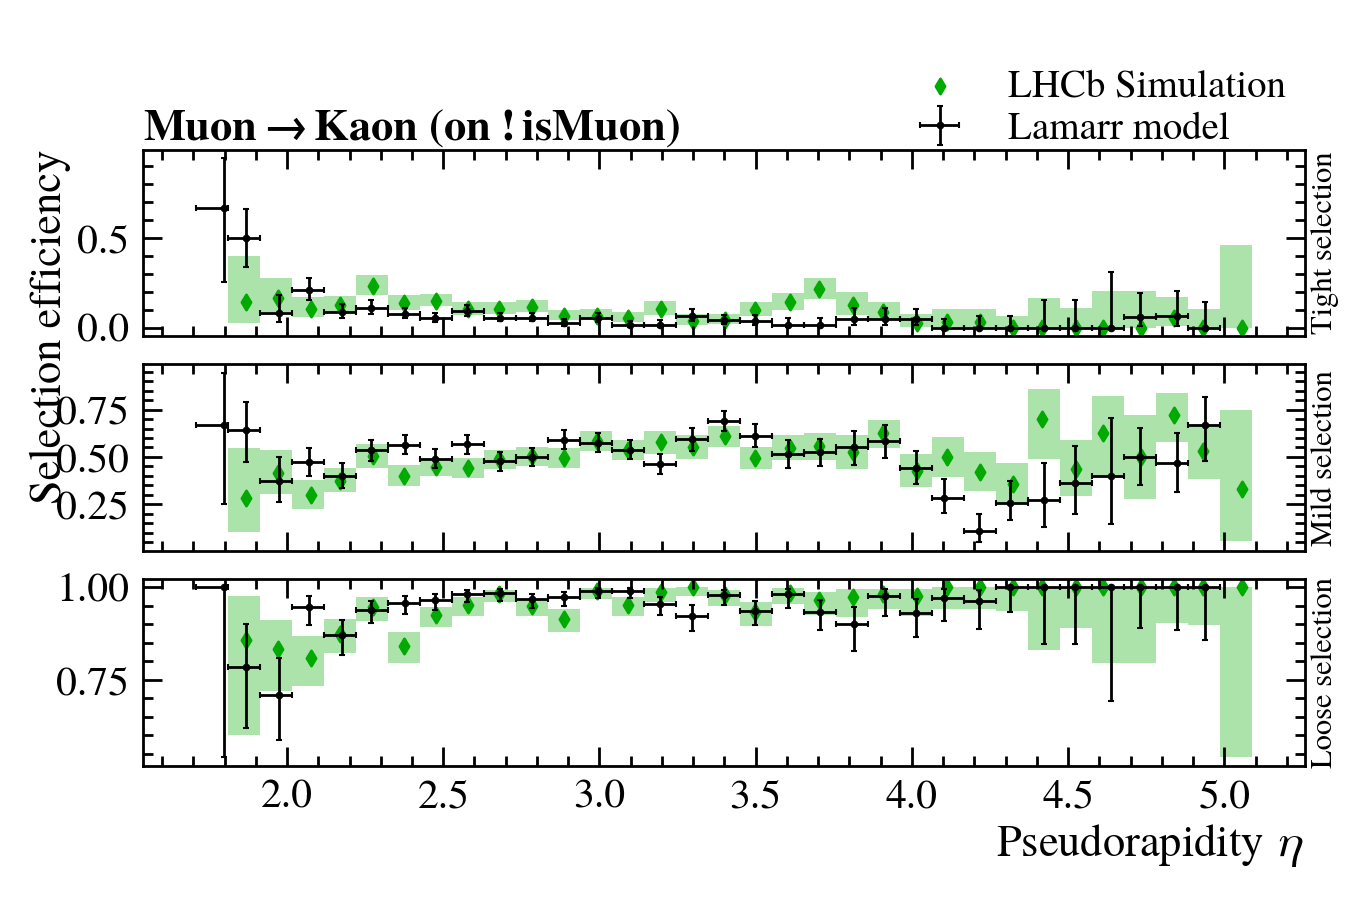

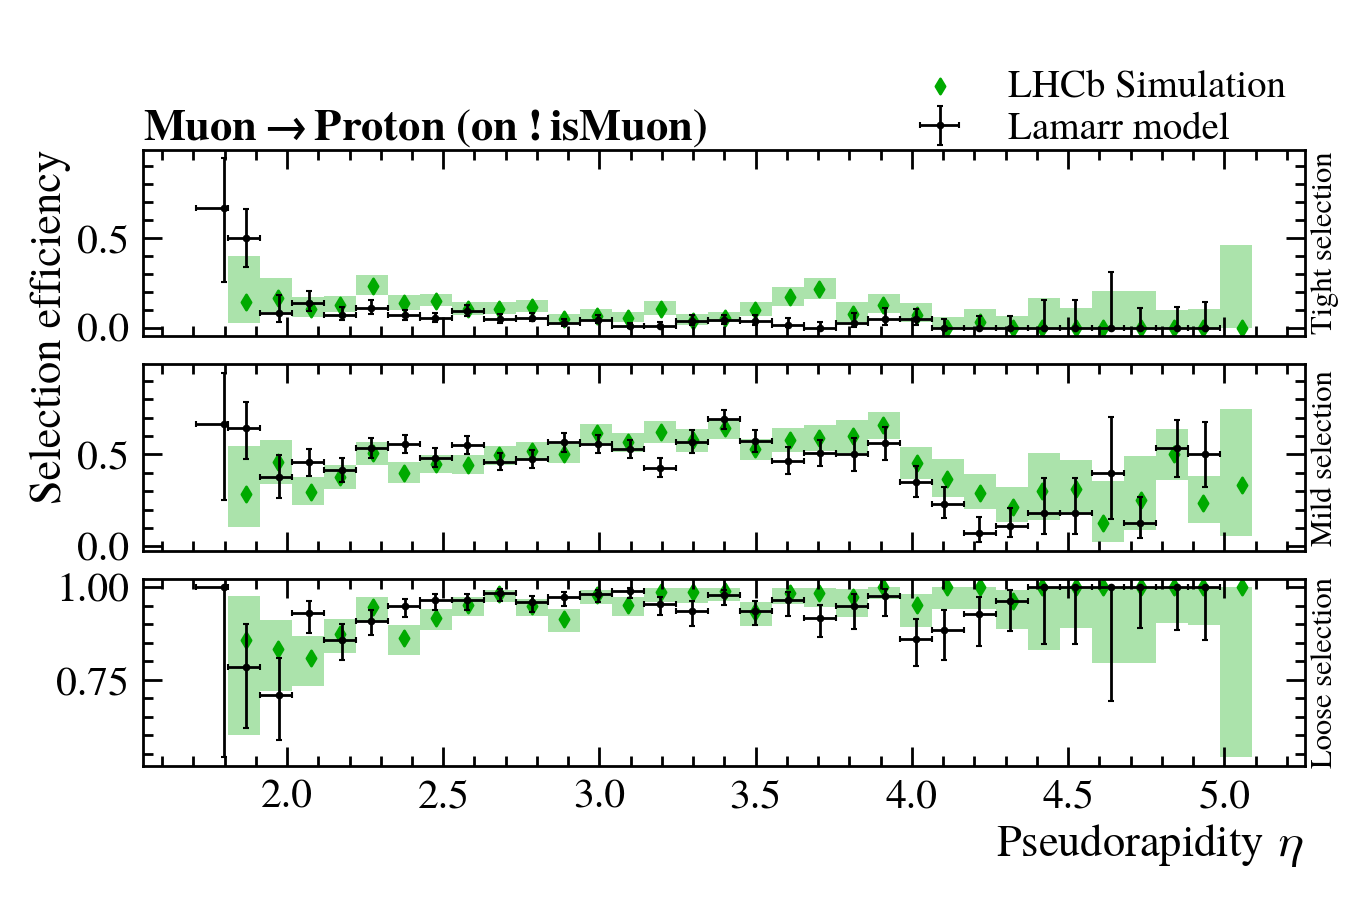

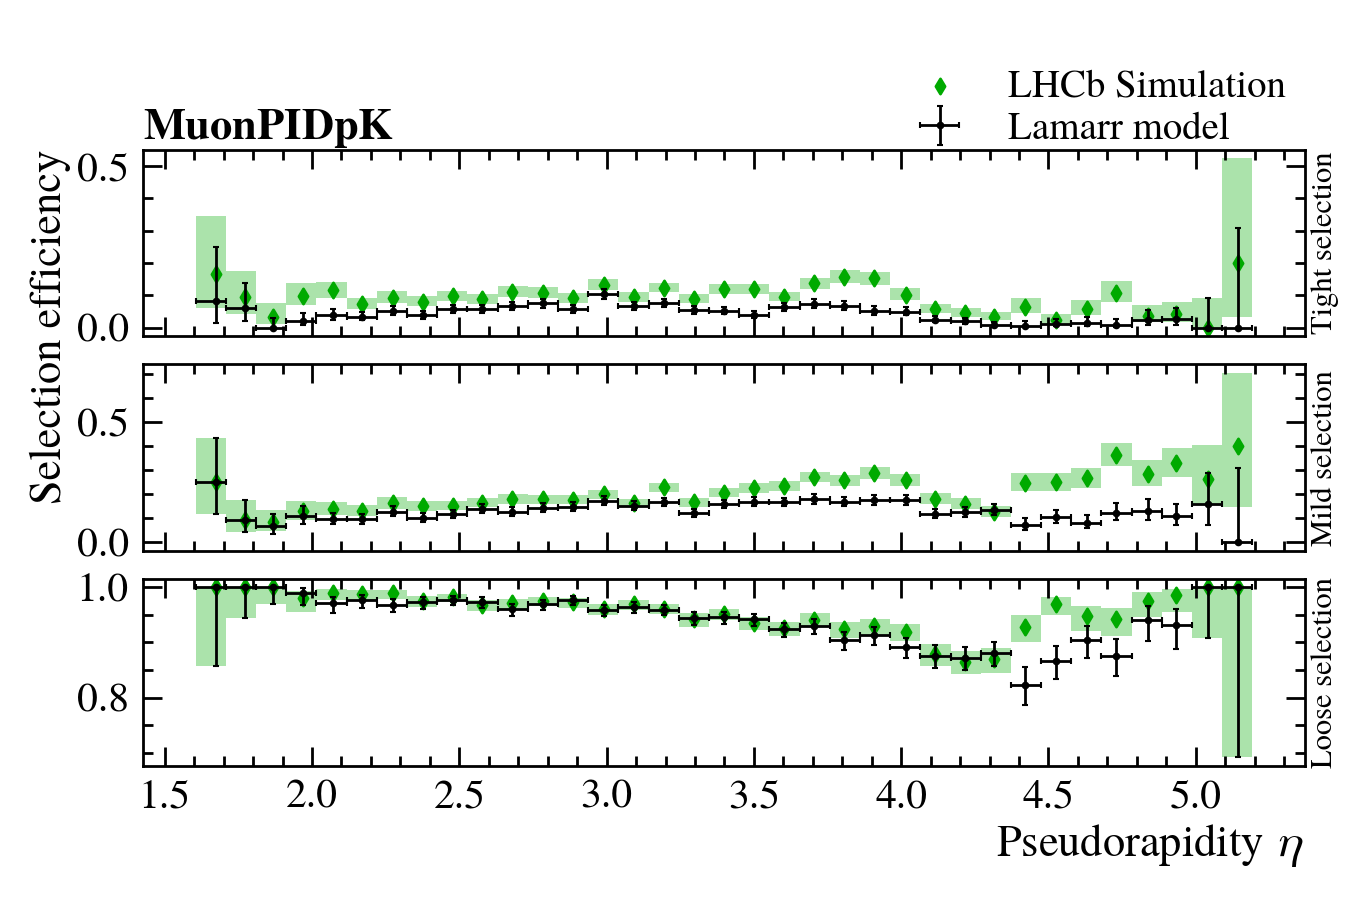

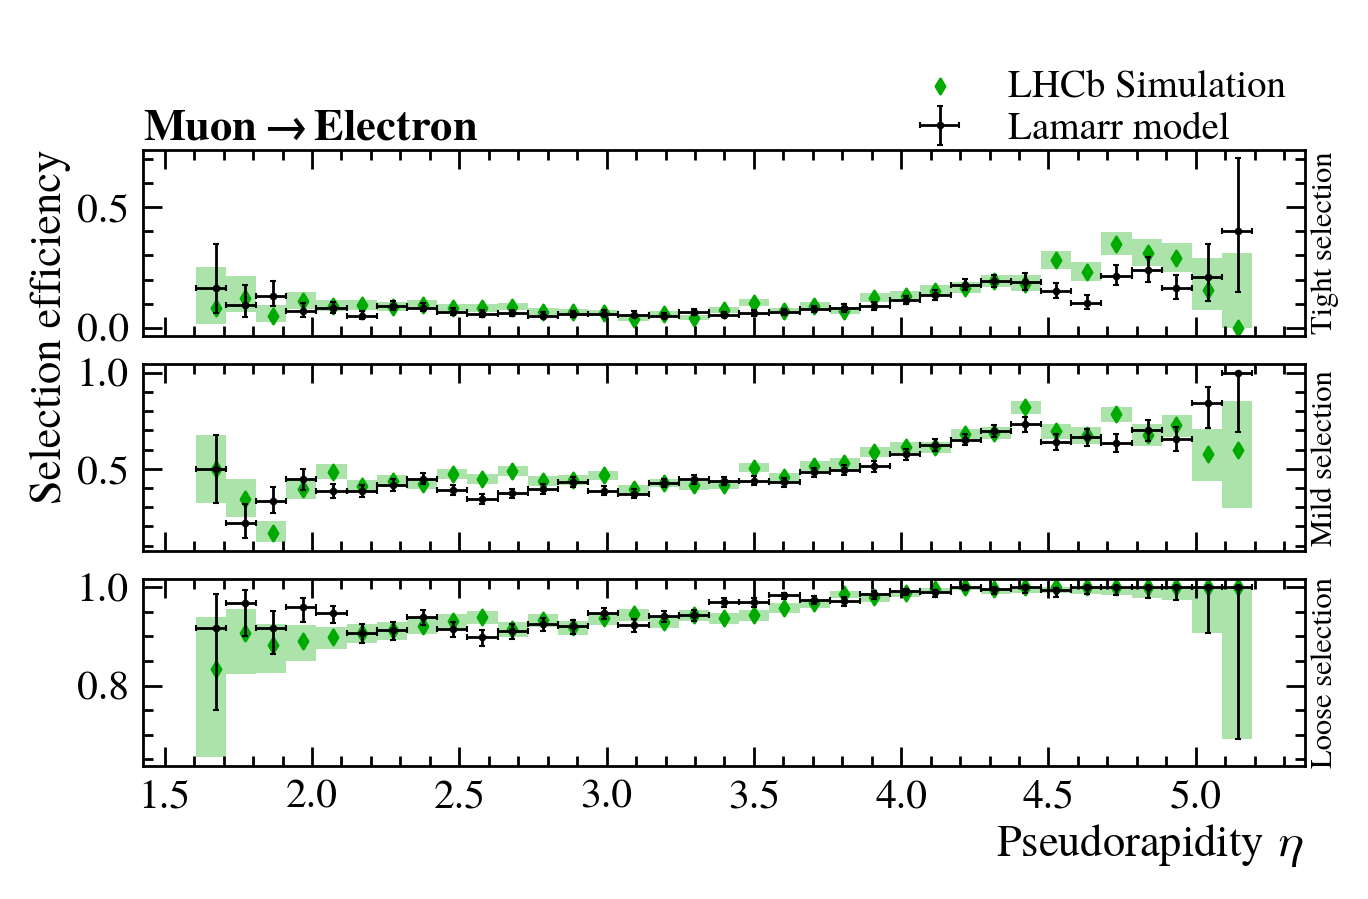

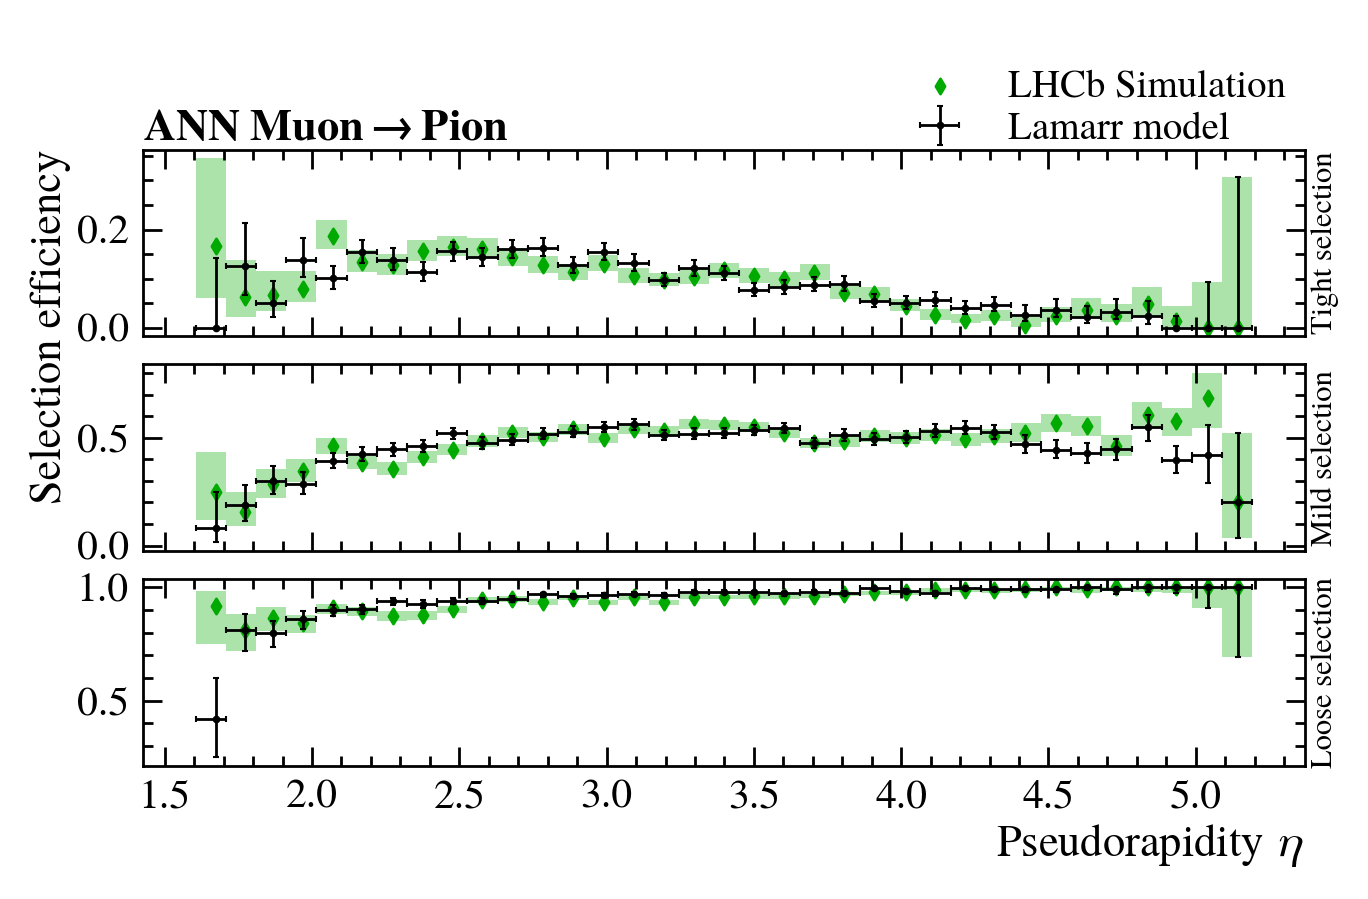

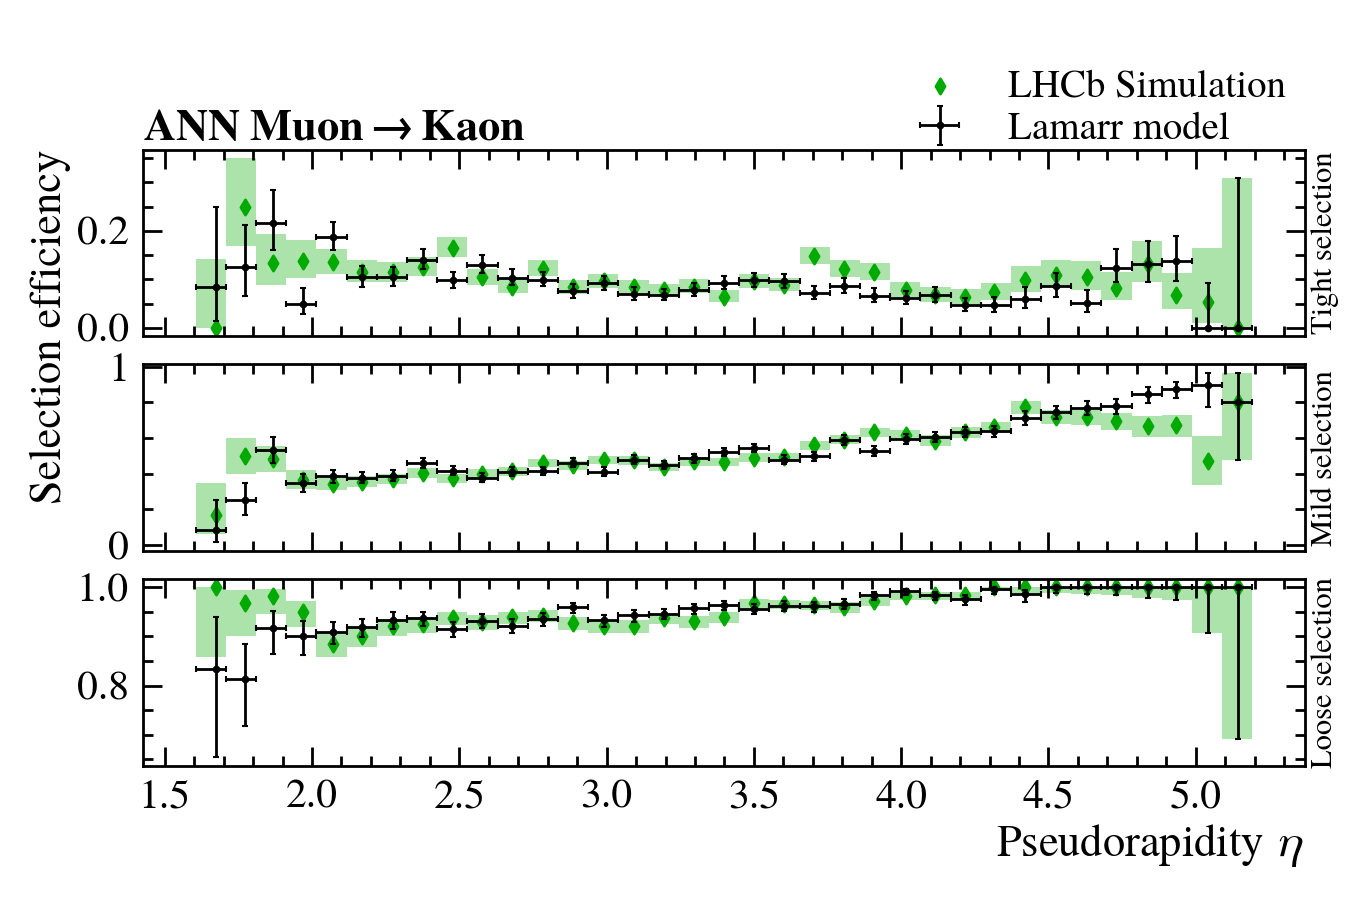

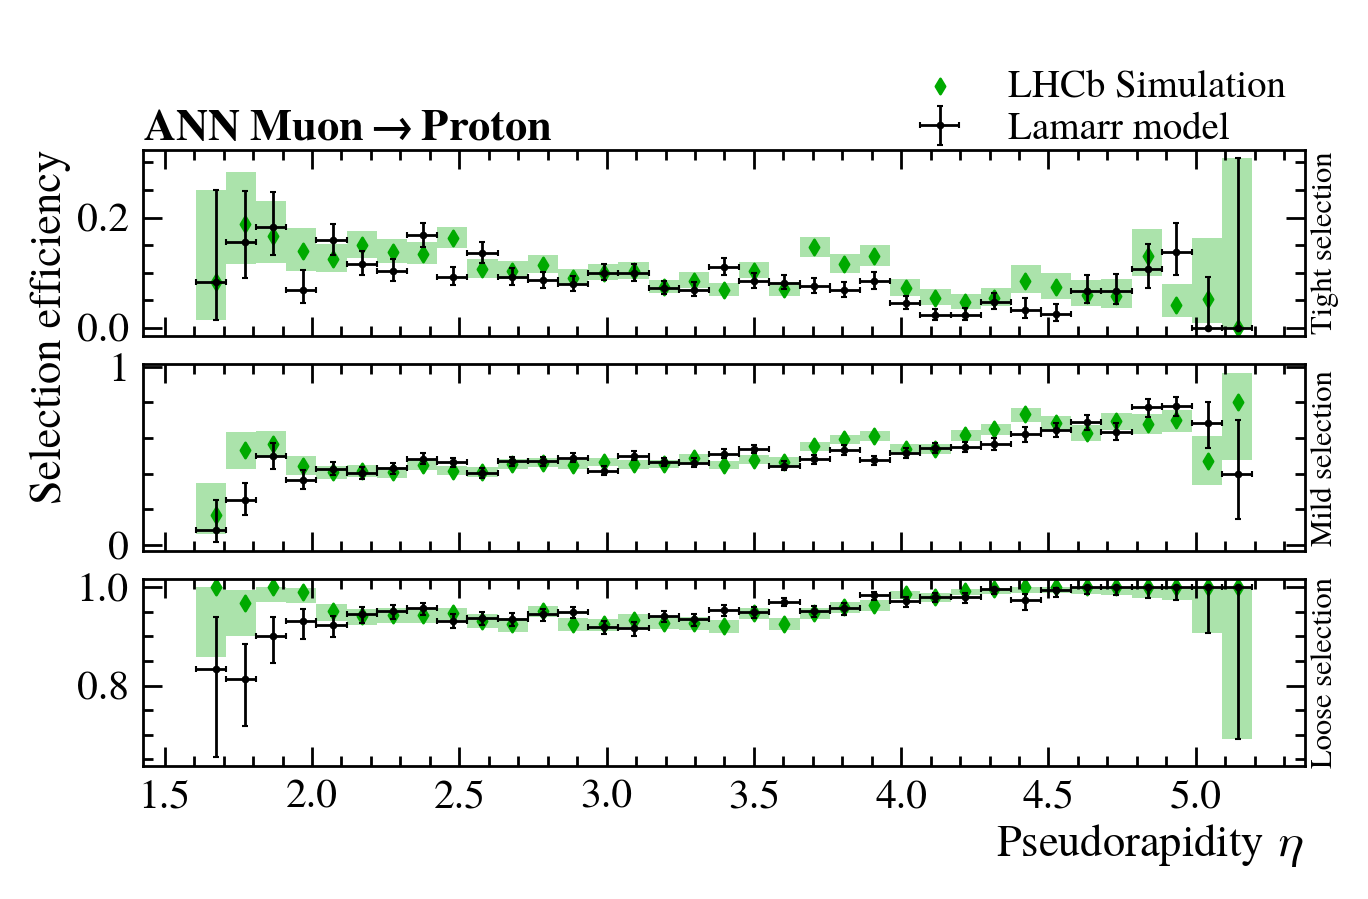

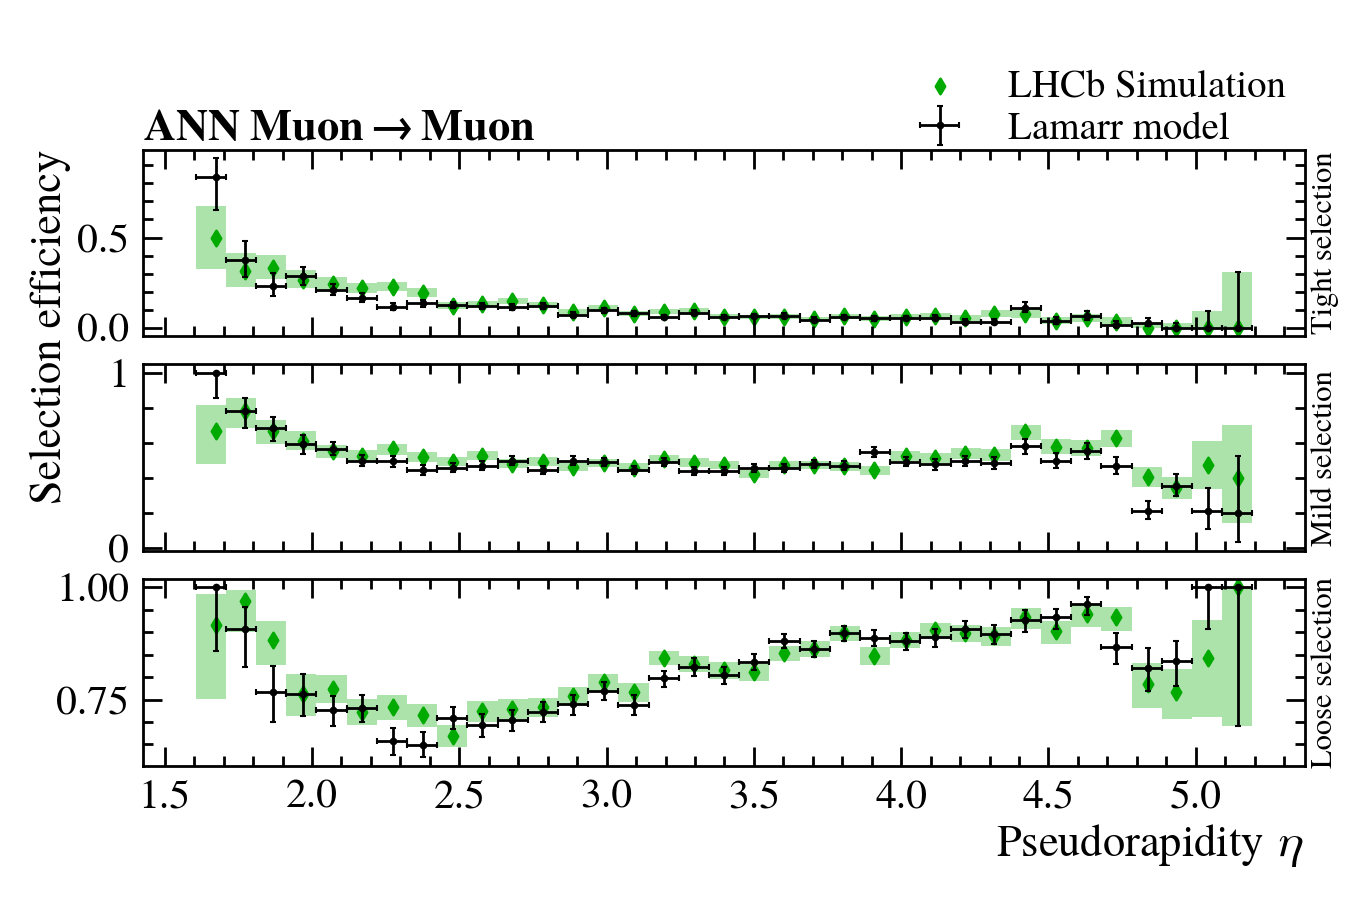

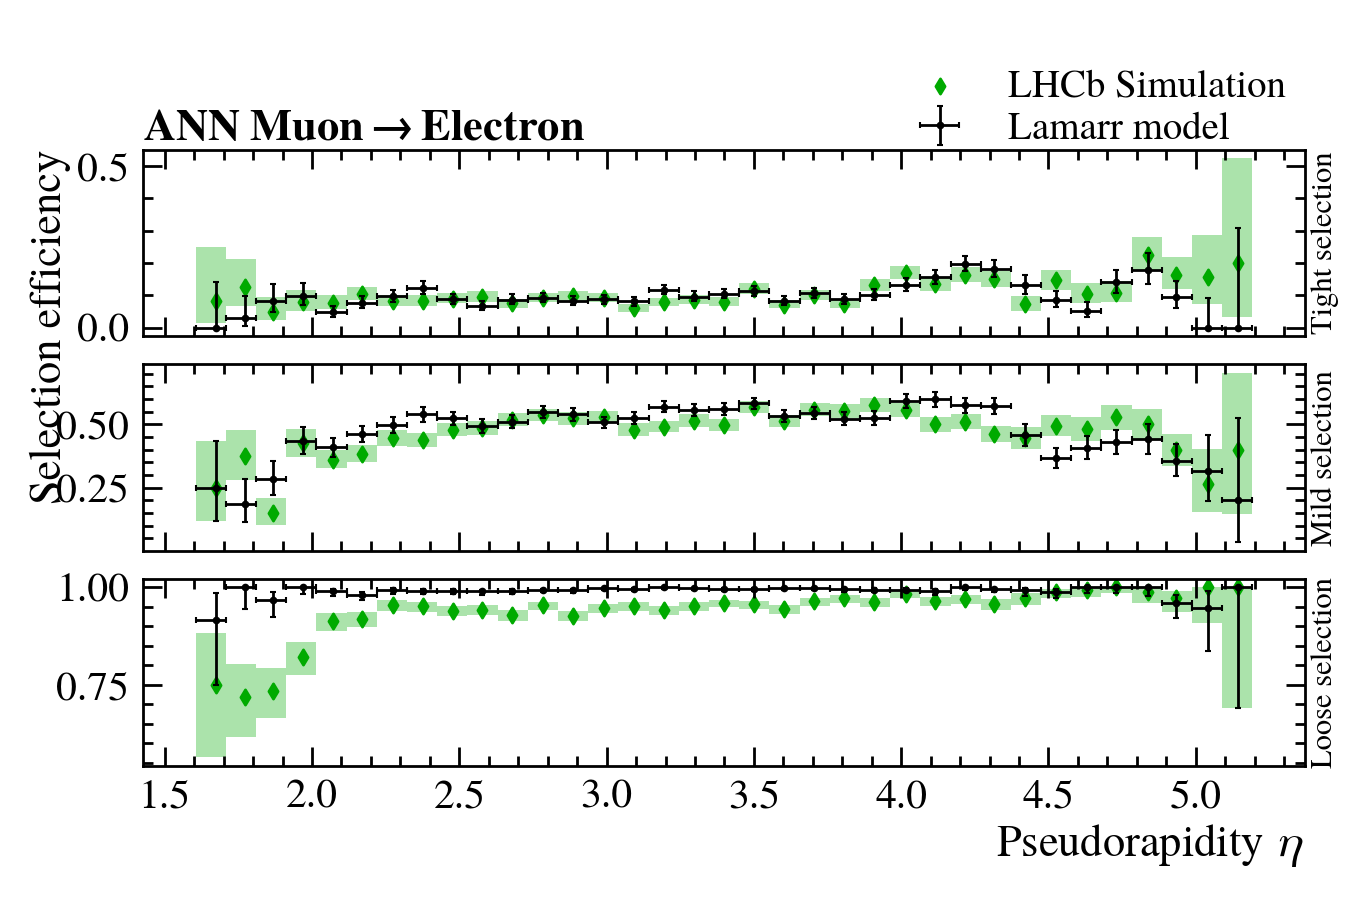

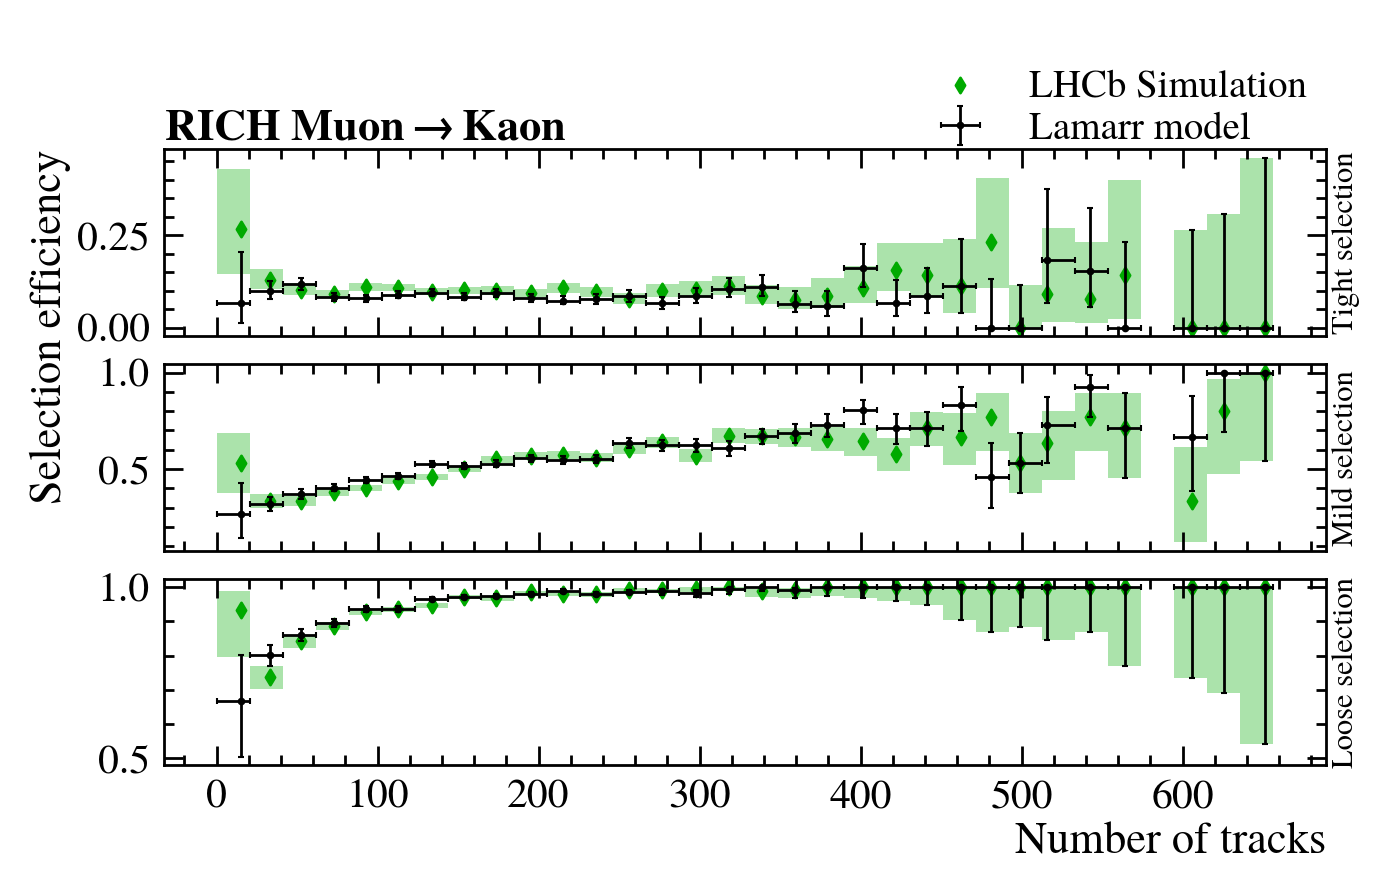

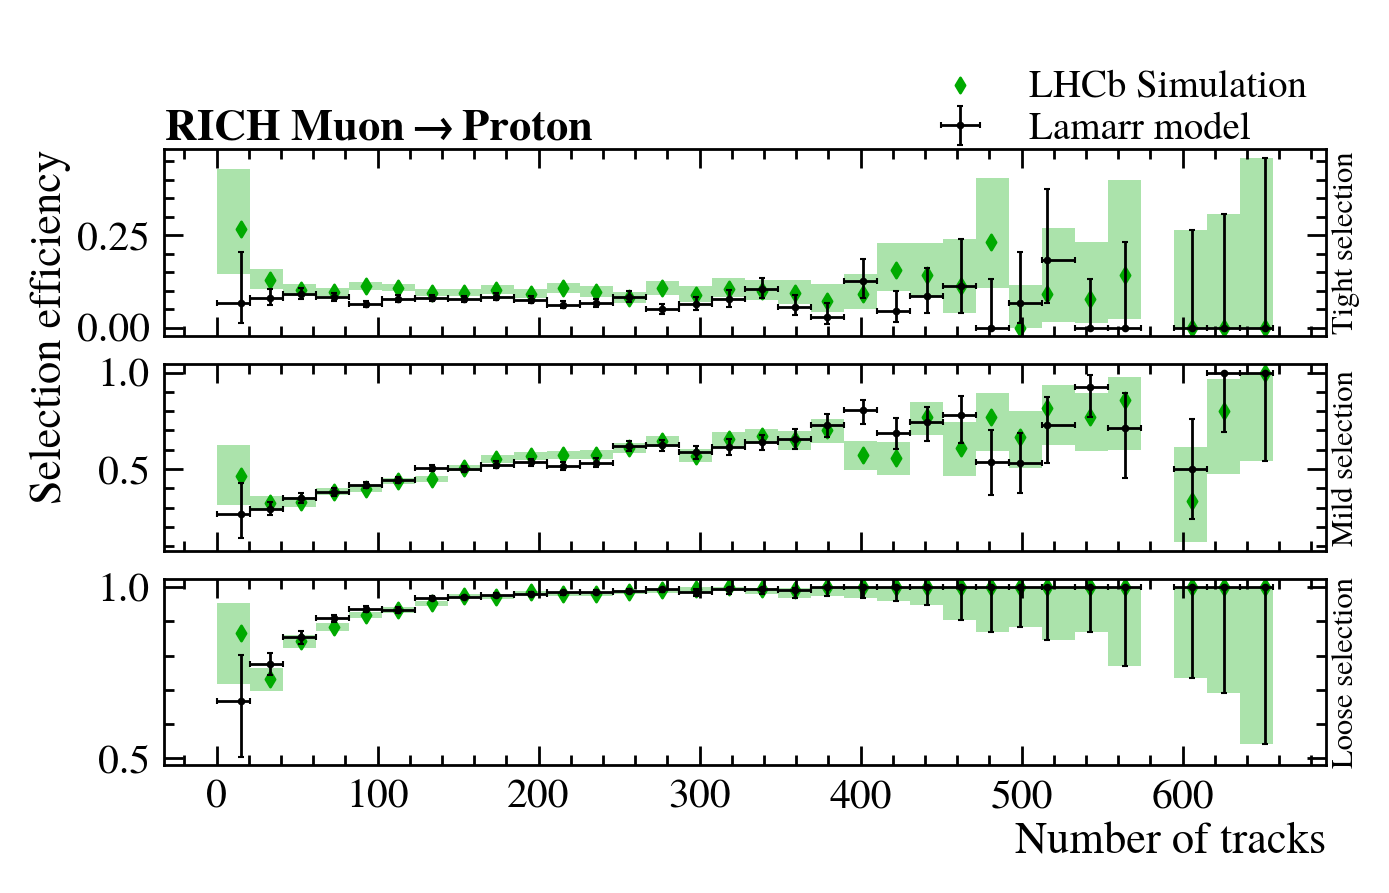

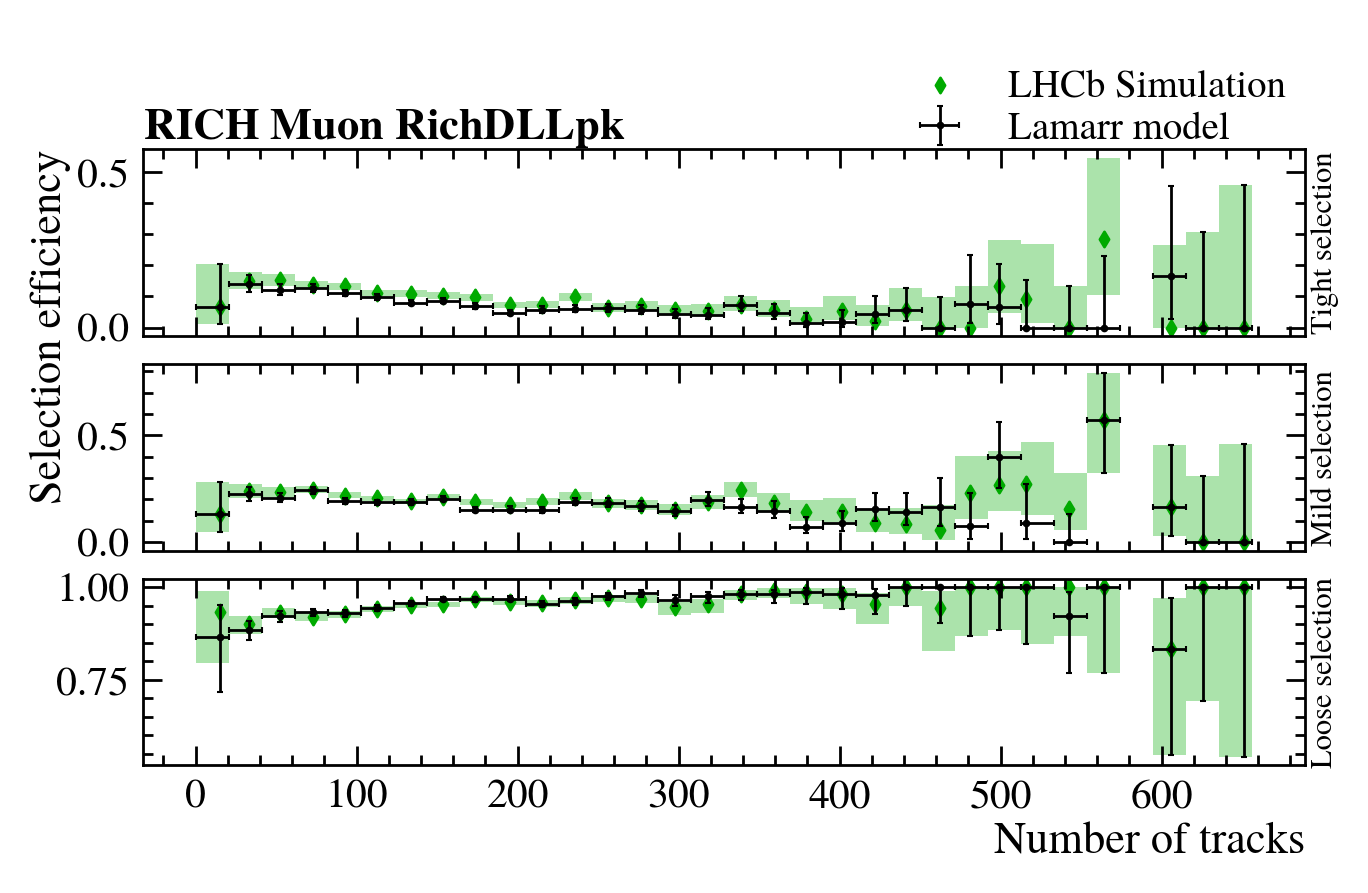

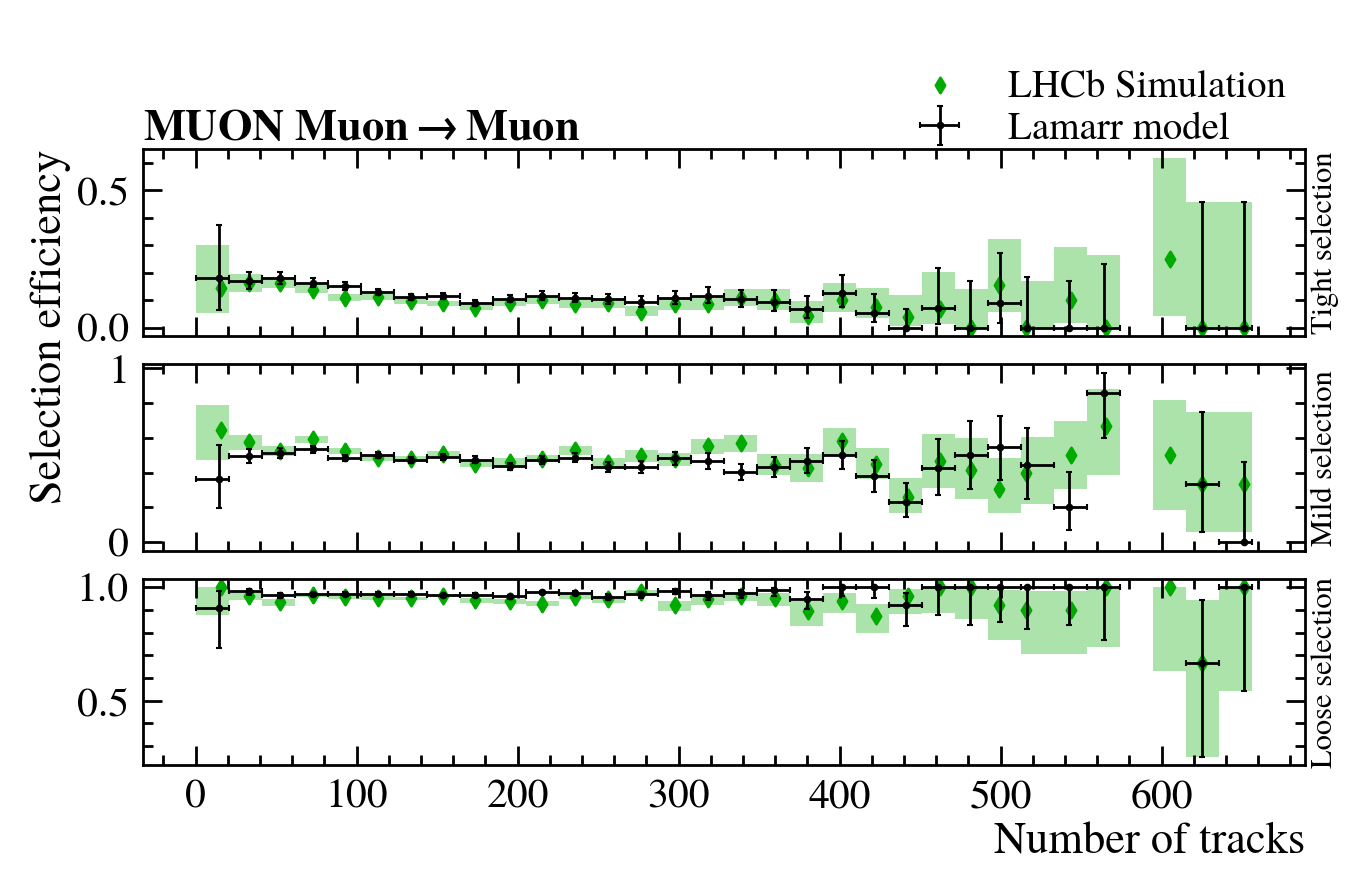

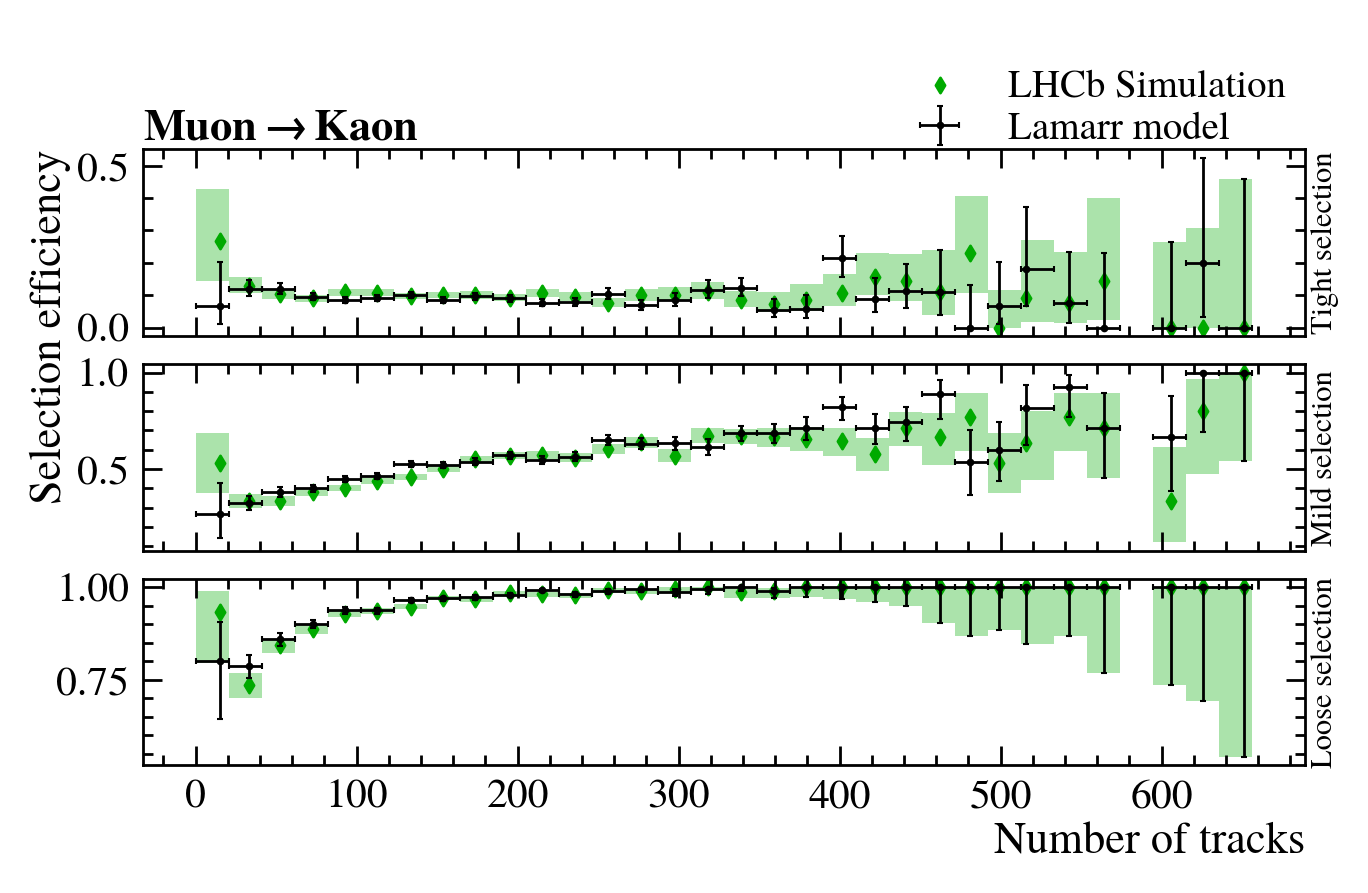

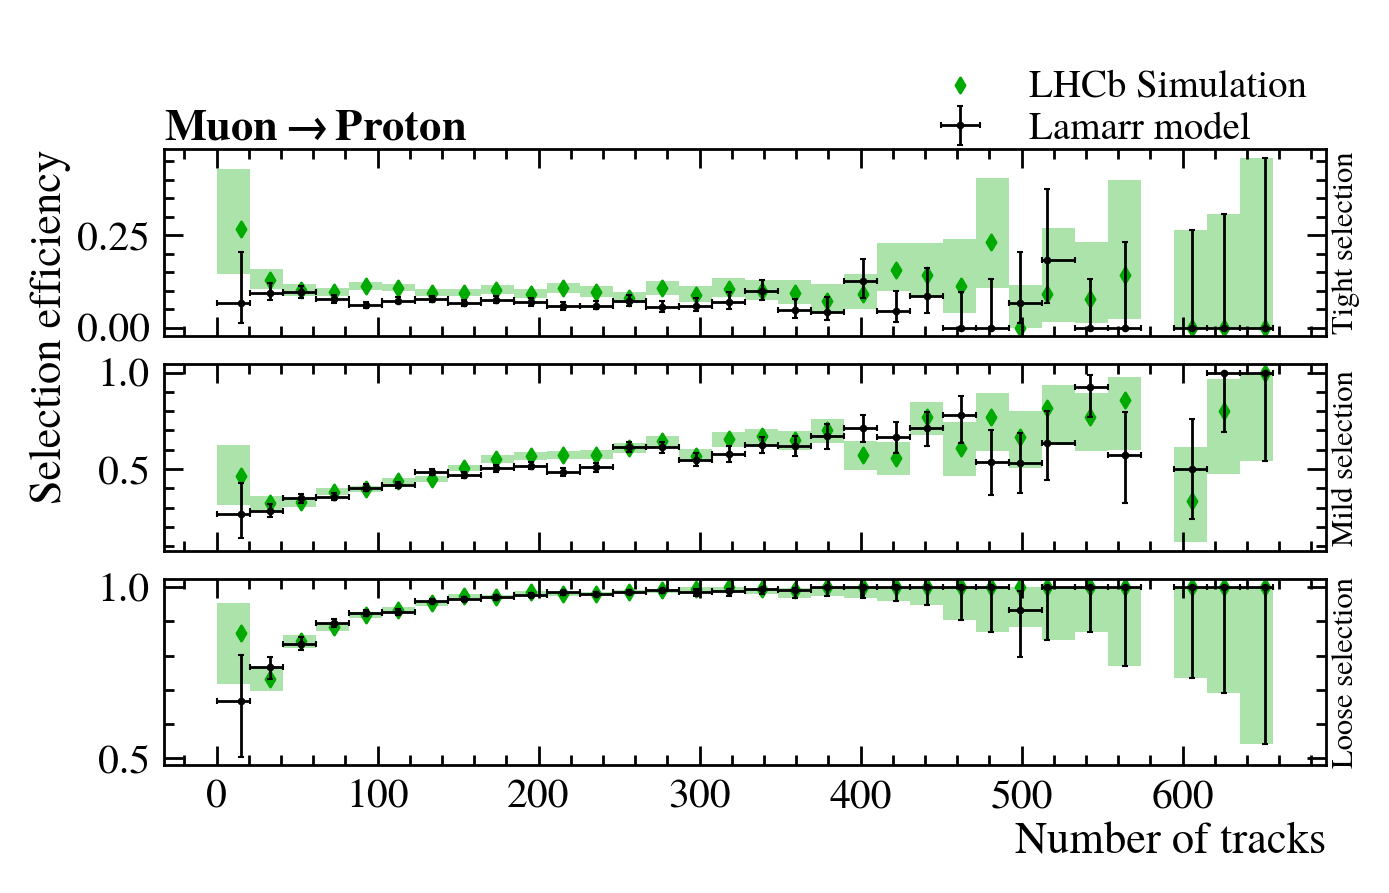

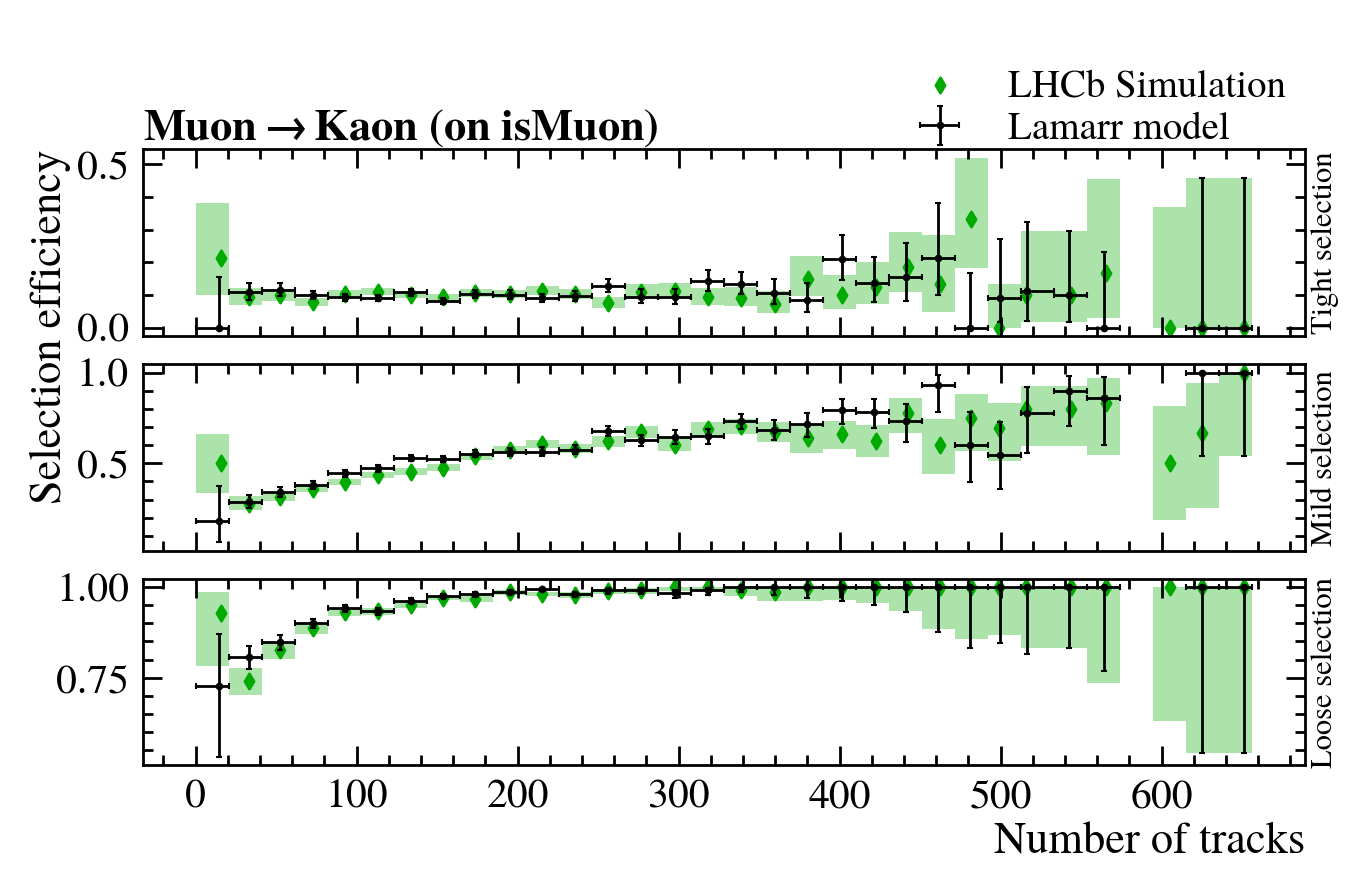

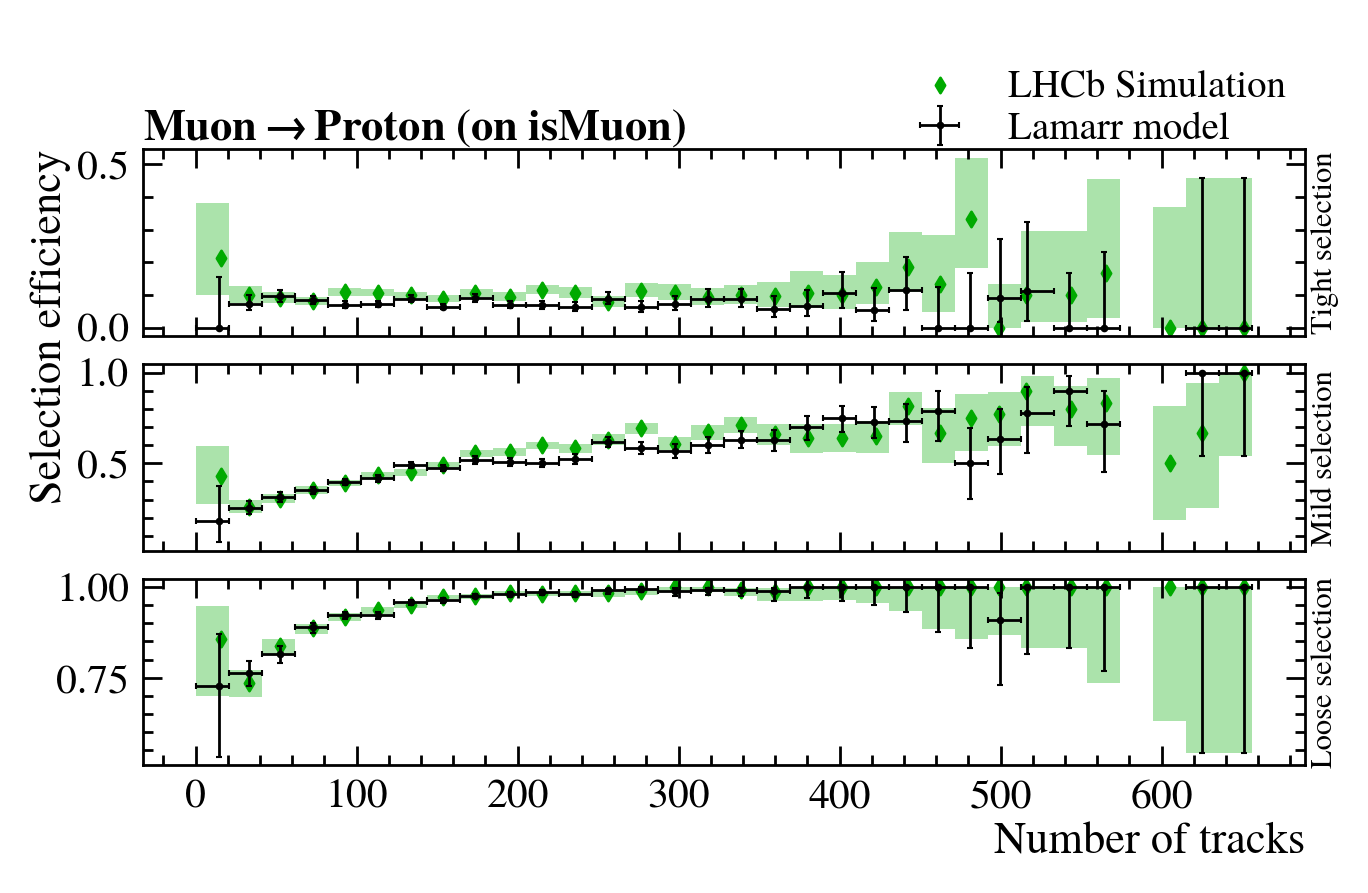

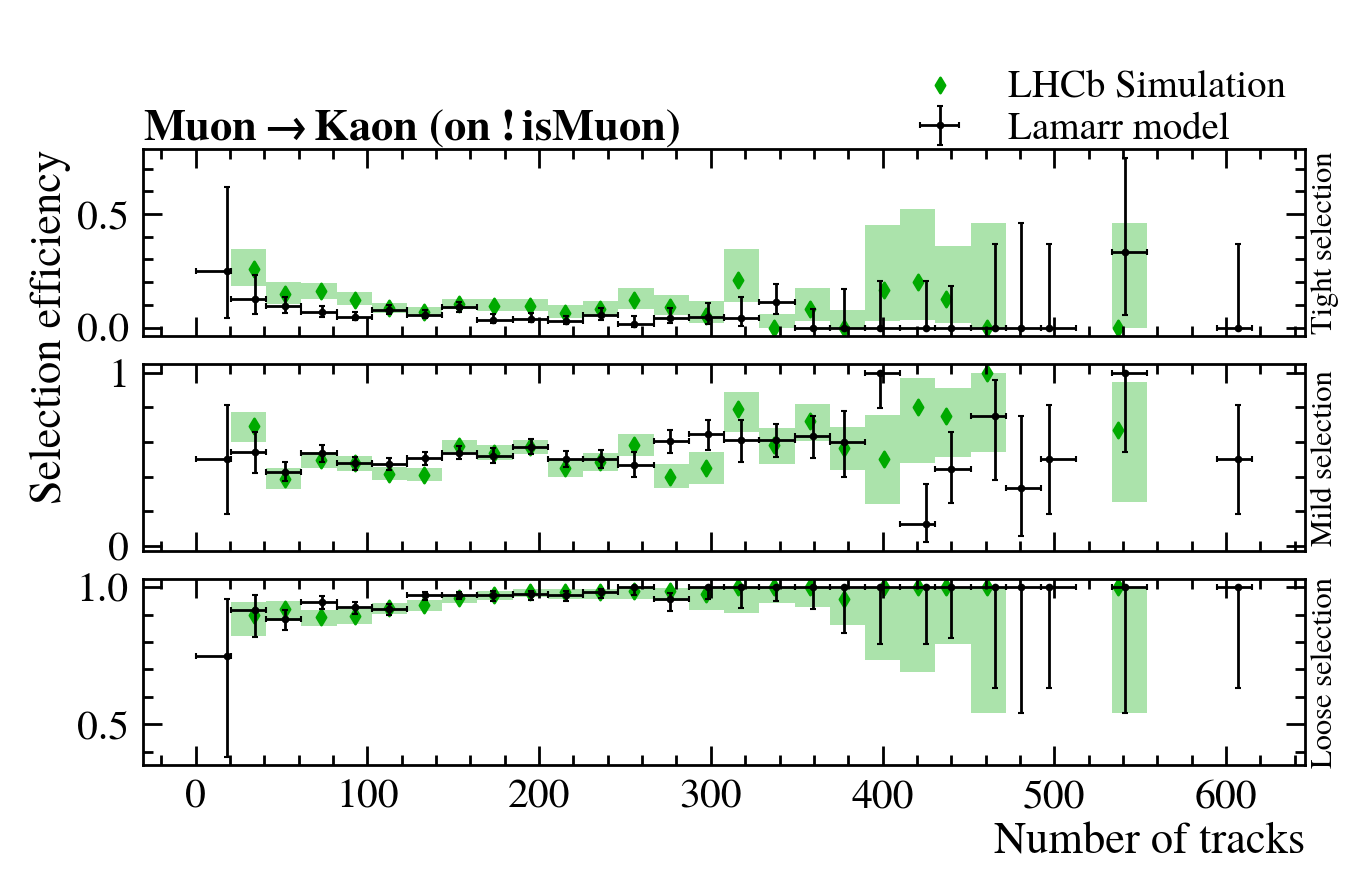

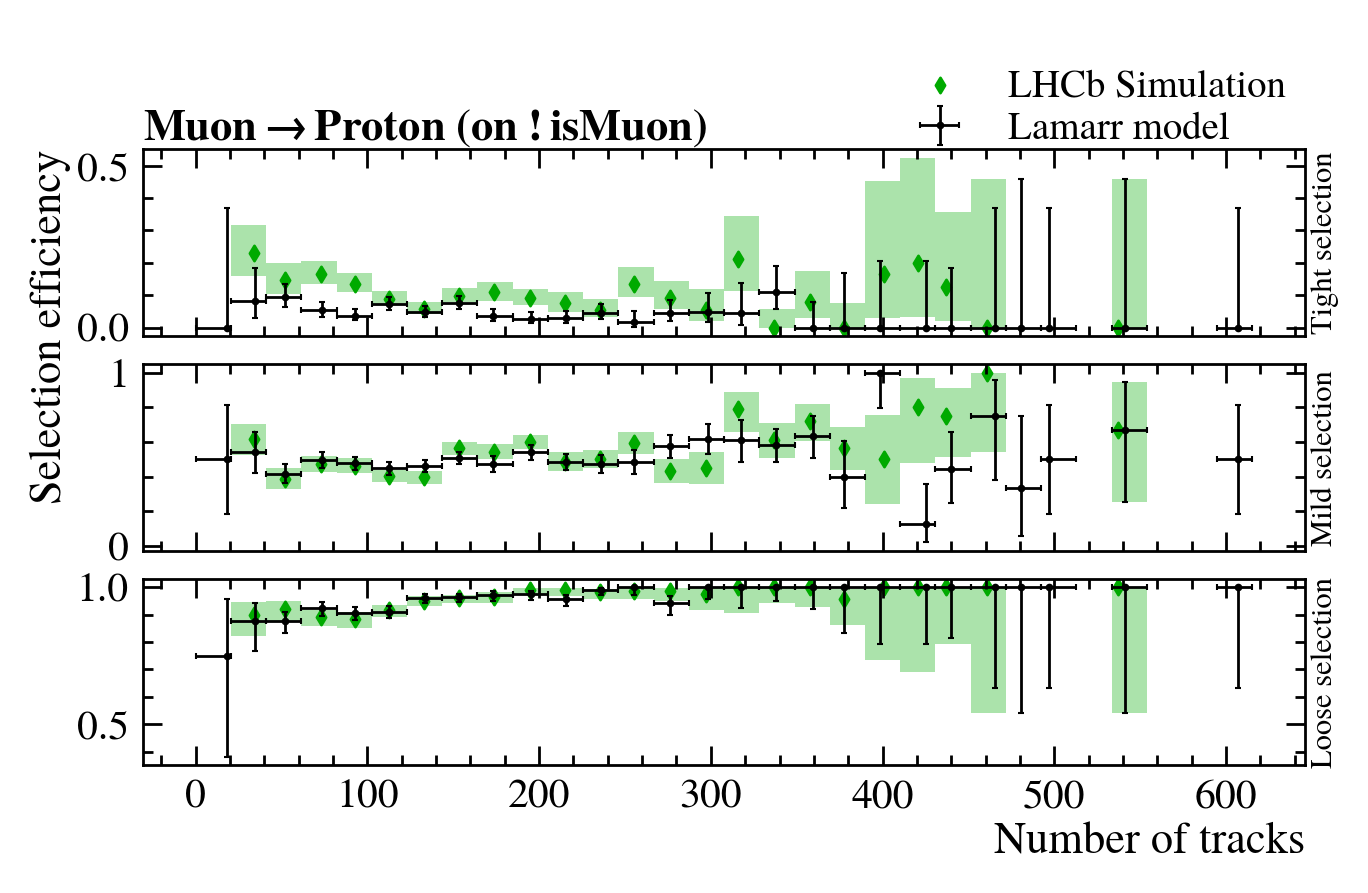

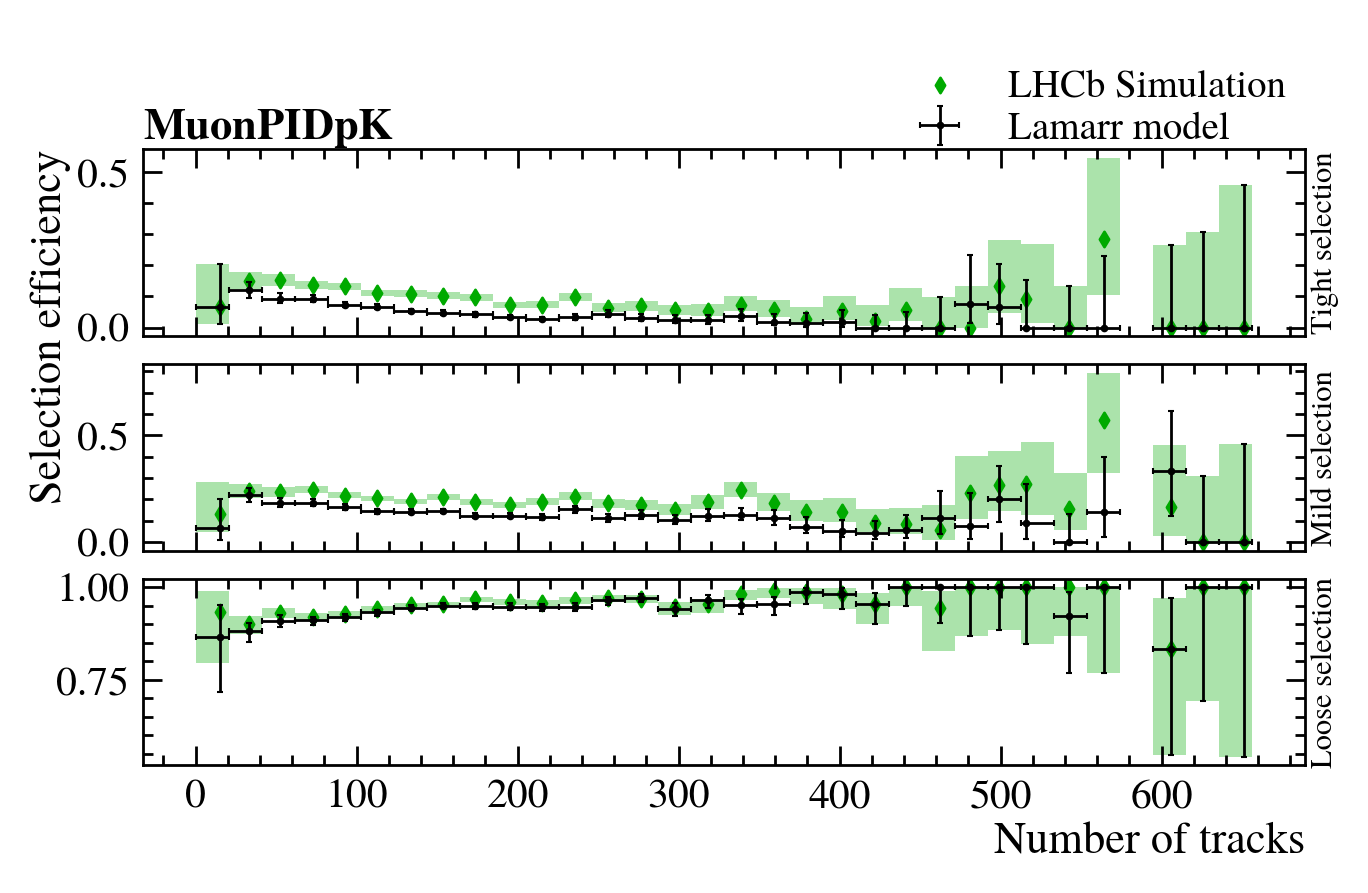

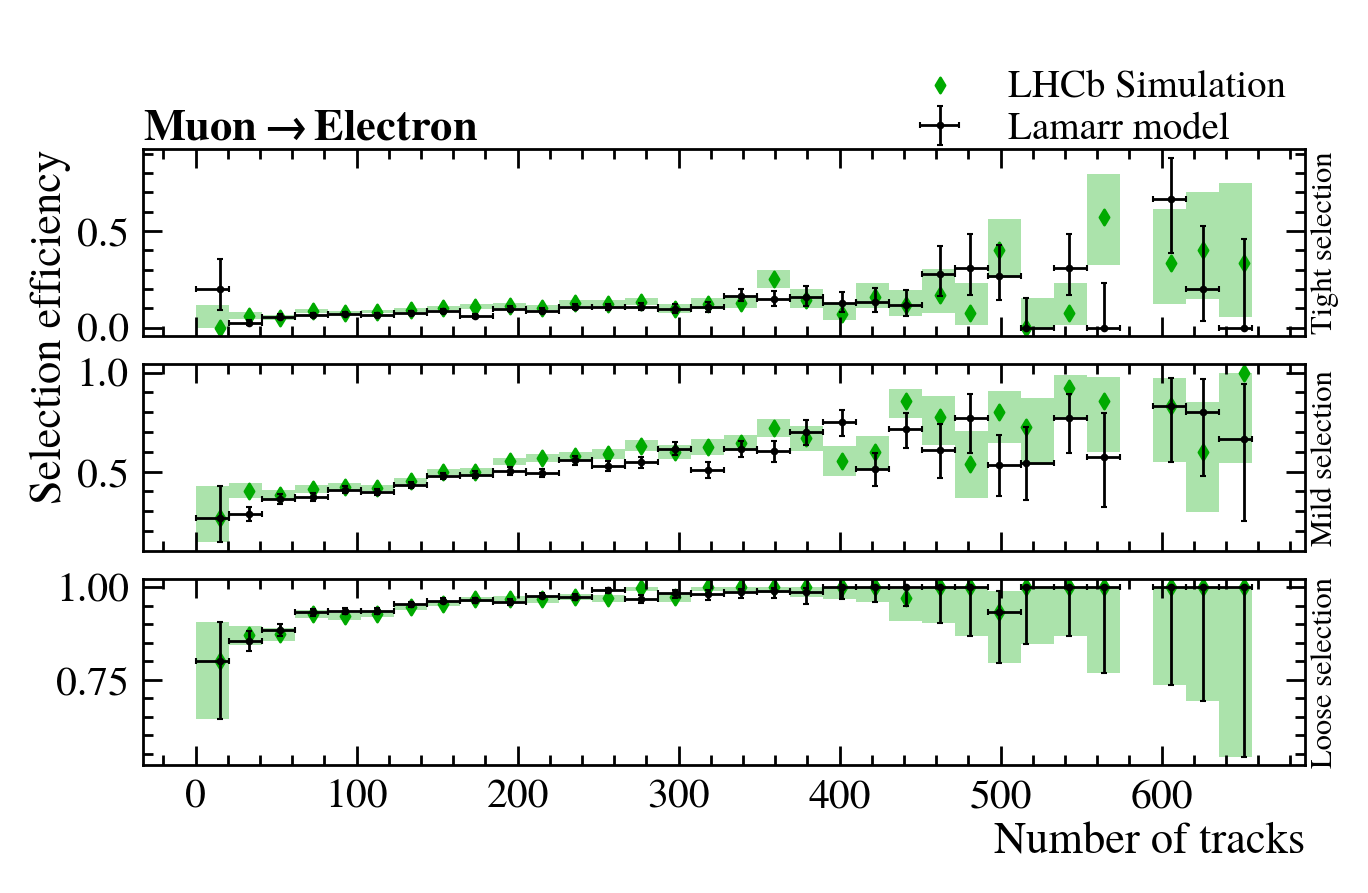

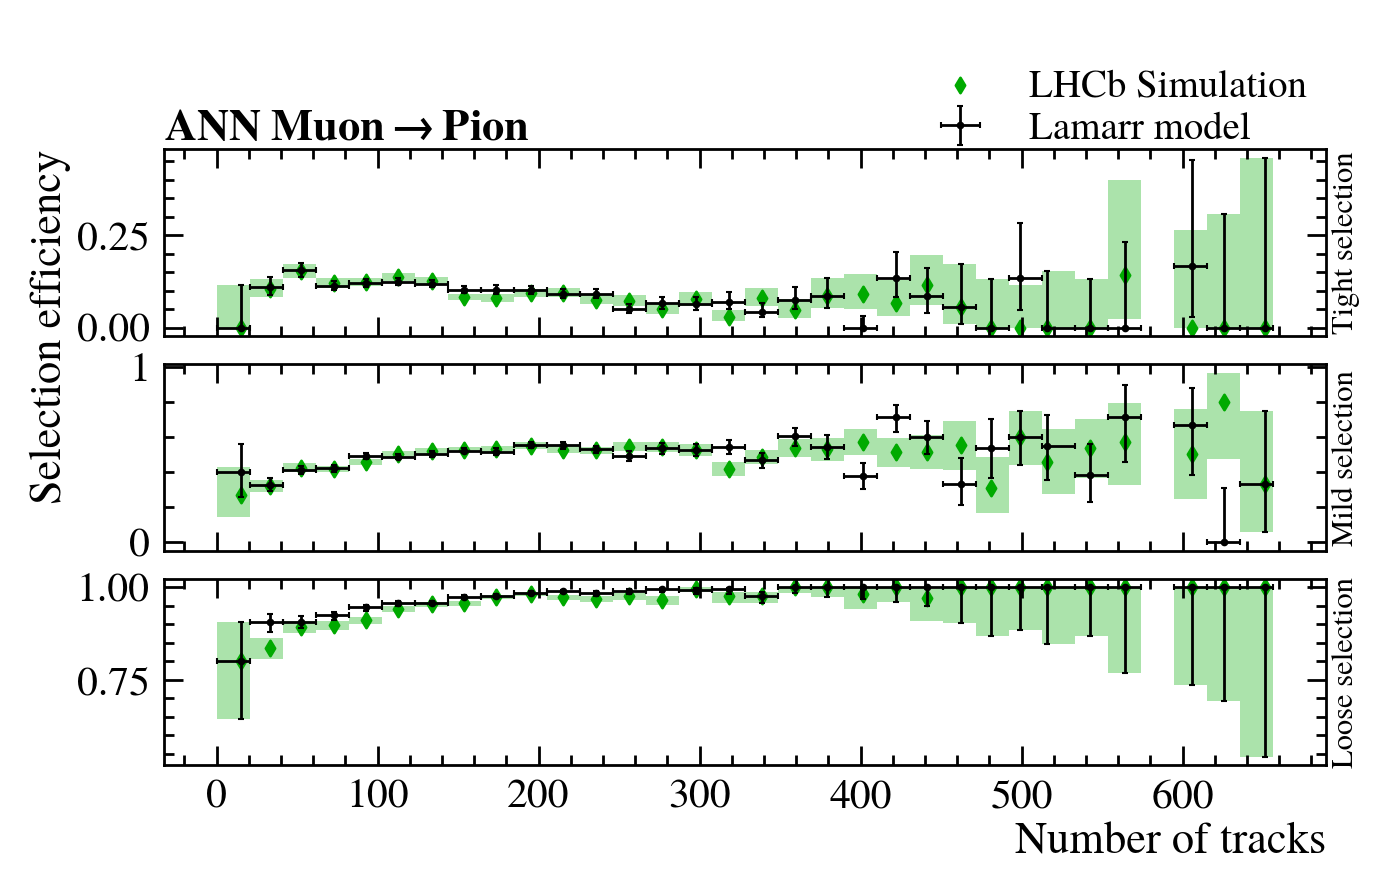

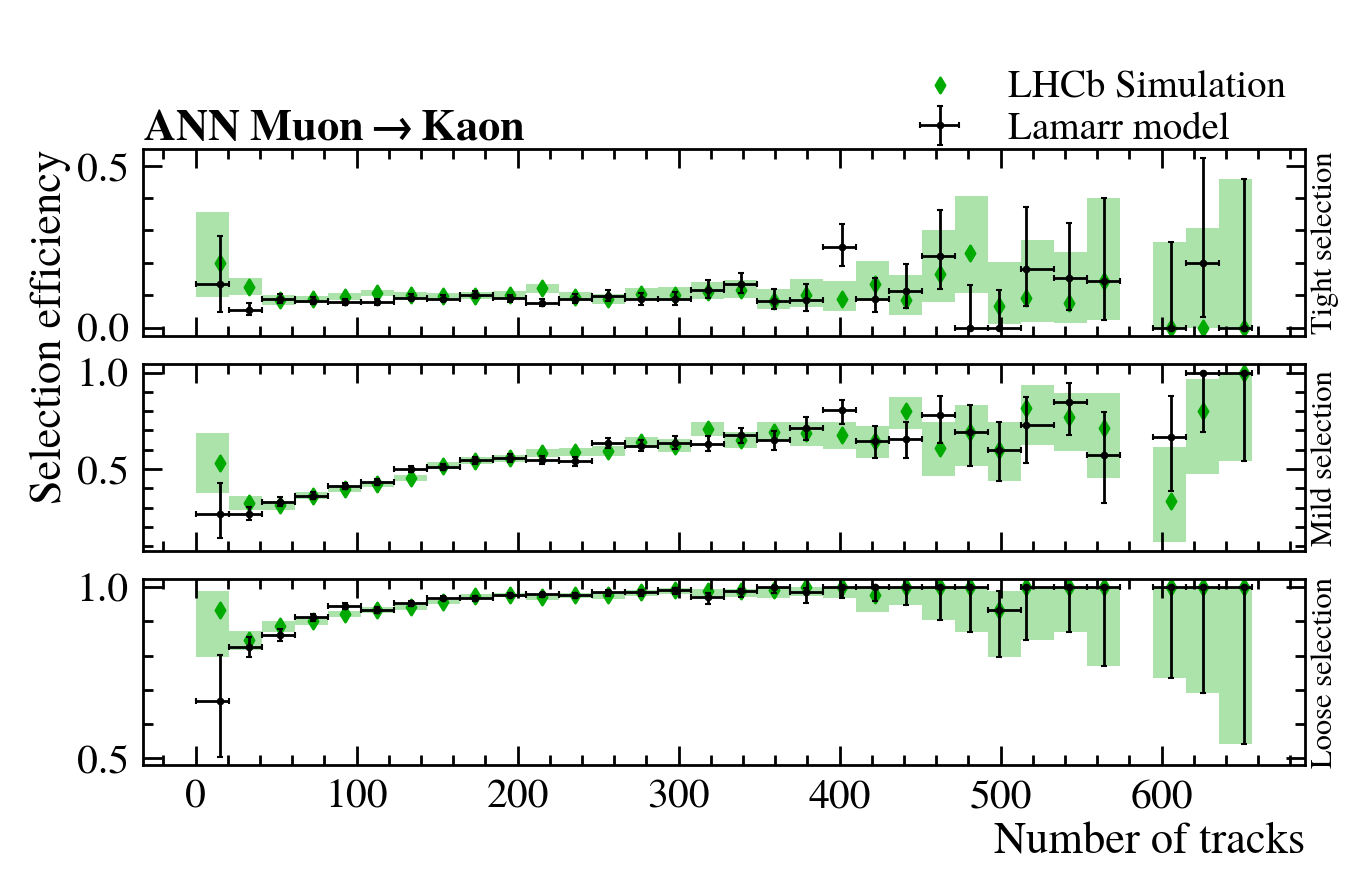

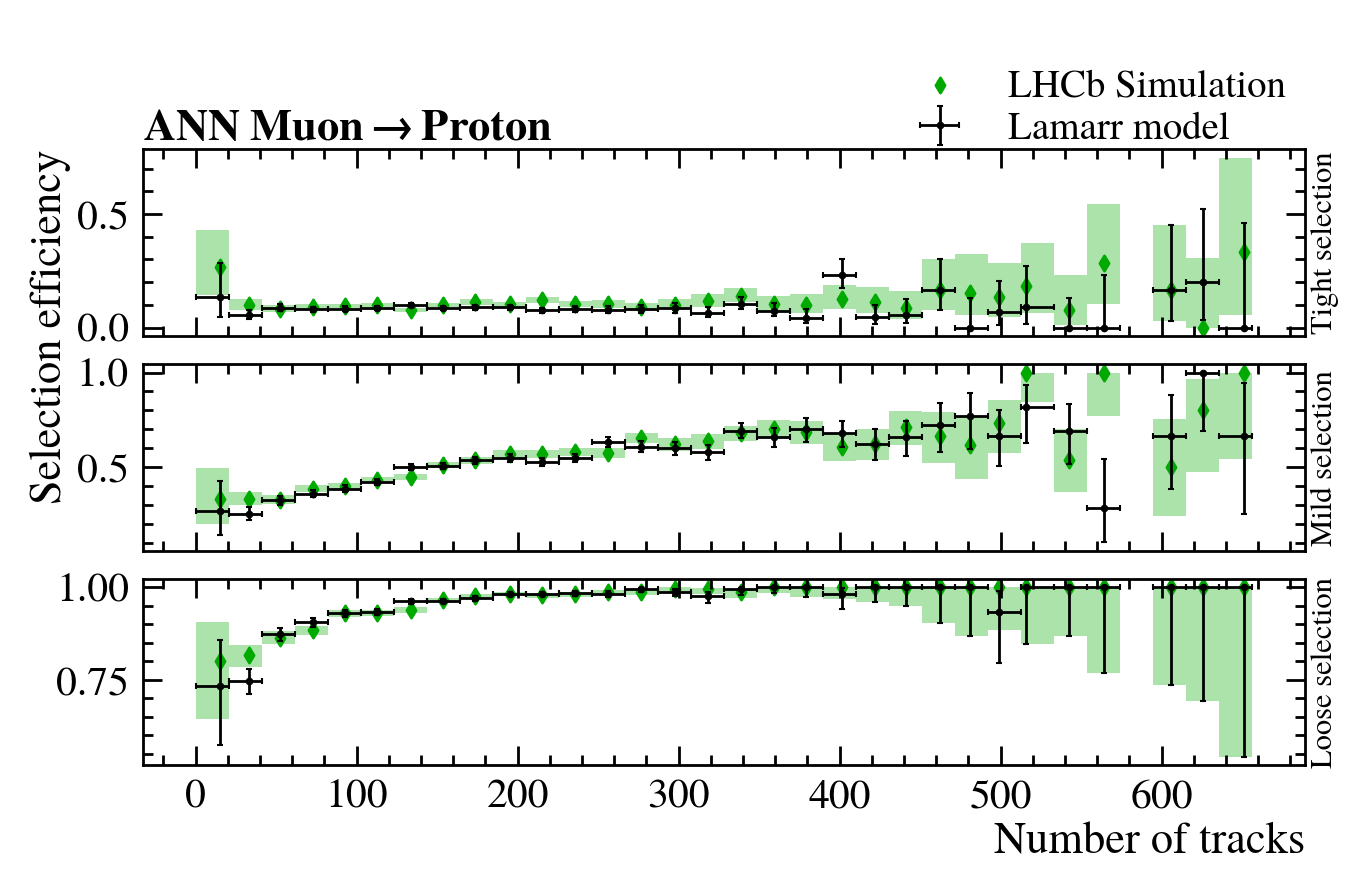

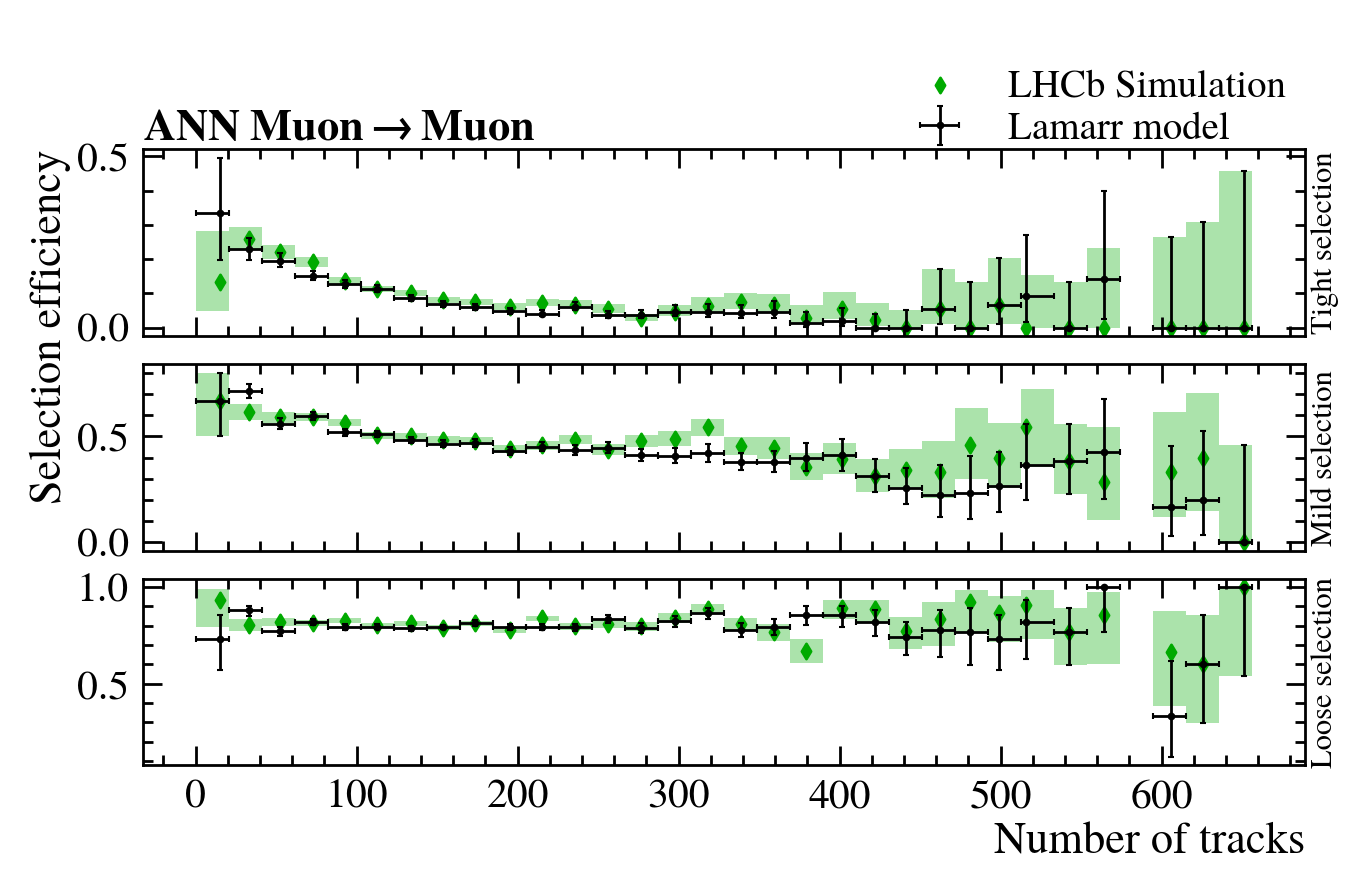

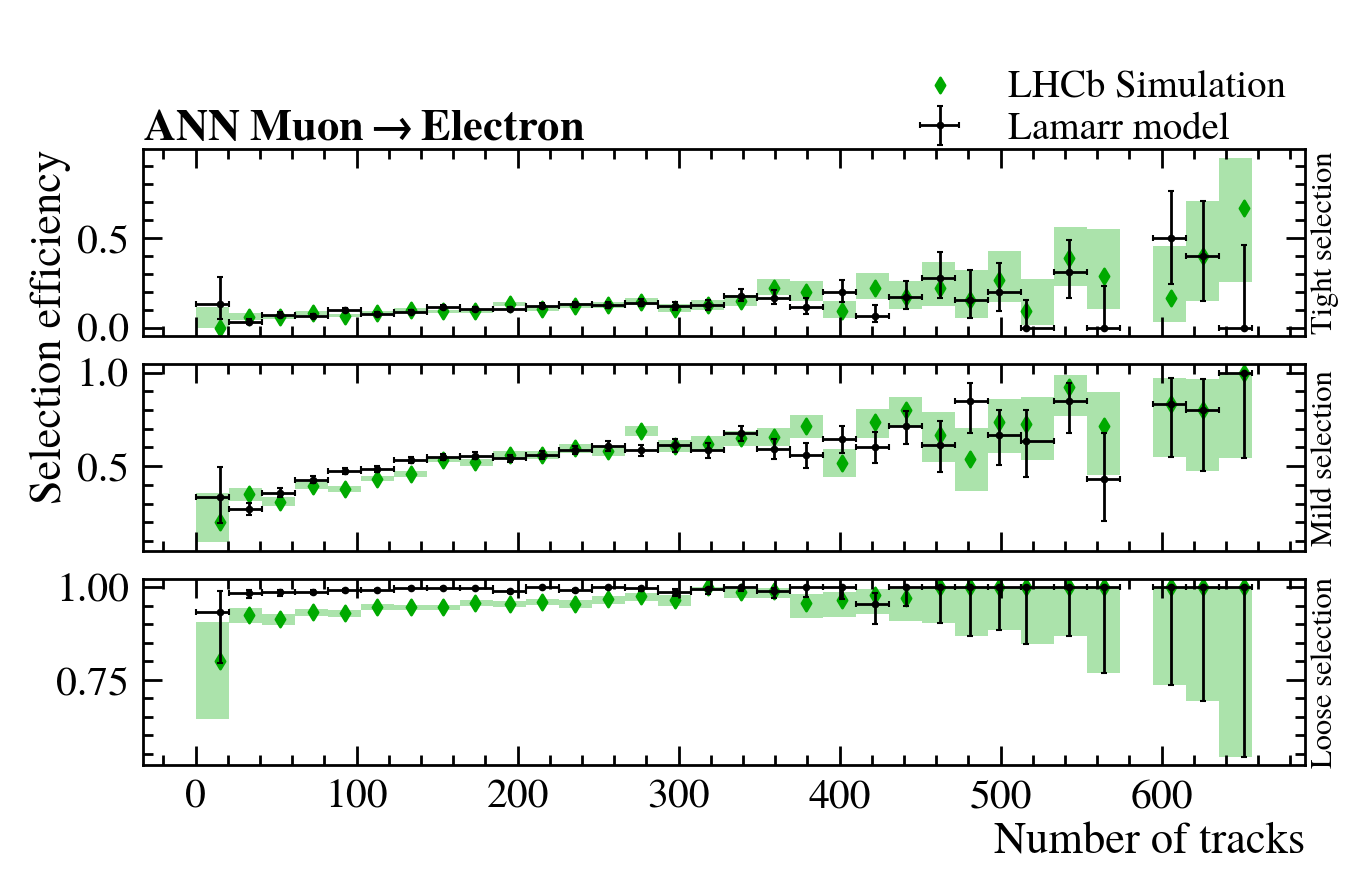

In [13]:
for x_var_title, x_var in x_vars.items():
    bins = x_var['bins']
    for cfg in configs:
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 8), constrained_layout=False, gridspec_kw=dict(hspace=0.15),)
    
        brunel_df = df if 'brunel_presel' not in cfg else df.query(cfg['brunel_presel'])
        lamarr_df = df if 'lamarr_presel' not in cfg else df.query(cfg['lamarr_presel'])
        brunel_x = brunel_df.eval(x_var['formula'])
        lamarr_x = lamarr_df.eval(x_var['formula'])
        brunel_var = brunel_df.eval(cfg['brunel_var'])
        lamarr_var = lamarr_df.eval(cfg['lamarr_var'])
        
        for title, ax, threshold in zip(cfg['thresholds'].keys(), axs, np.quantile(brunel_var.values, [1-t for t in cfg['thresholds'].values()])):
            plt.text(1.005, 0.5, title, transform=ax.transAxes, ha='left', va='center', fontsize=22, rotation=90)
            plt.sca(ax)
            plot_efficiency(brunel_x, brunel_var > threshold, bins=bins, plot_type='boxes', label="LHCb Simulation")
            plot_efficiency(lamarr_x, lamarr_var > threshold, bins=bins, plot_type='errorbars', label='Lamarr model')
        
        plt.sca(axs[0])
        plt.xscale(x_var['scale'])
        plt.ylabel(rf"Selection efficiency")
        plt.text(0, 1, rf"$\mathbf {{{cfg['title']}}}$", transform=plt.gca().transAxes, ha='left', va='bottom', fontsize=32)
        leg = plt.legend(ncols=1, loc='upper right', bbox_to_anchor=(0, 0, 1.05, 1.85), 
                   edgecolor='k', fancybox=True, borderpad=1, framealpha=1)
        plt.sca(axs[-1])
        plt.xlabel(x_var_title)
    
        plt.show()

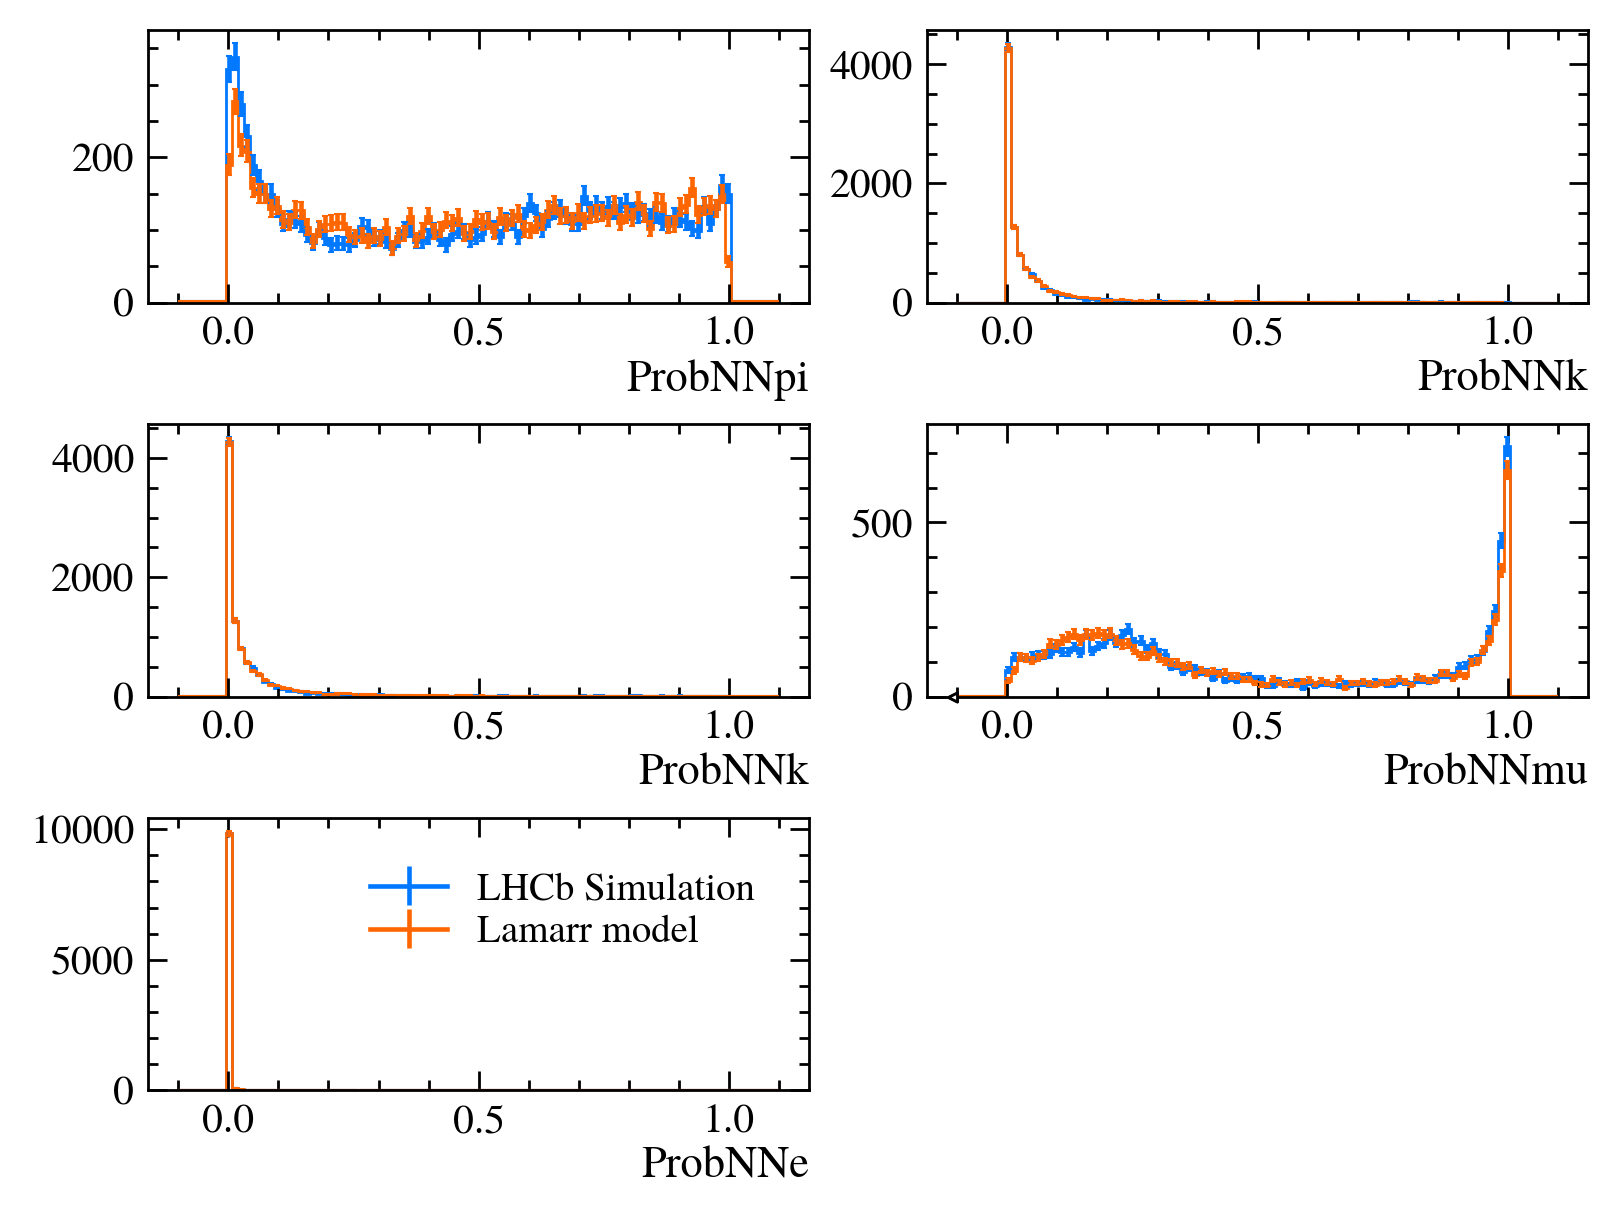

In [14]:
import hist
plt.figure(figsize=(16, 12))
for i_plot, probnn in enumerate(['ProbNNpi', 'ProbNNk', 'ProbNNk', 'ProbNNmu', 'ProbNNe'], 1):
    plt.subplot(3, 2, i_plot)
    ax = hist.axis.Regular(100, -0.1, 1.1, name=probnn)
    h_brunel, h_lamarr = hist.Hist(ax), hist.Hist(ax)
    h_brunel.fill(df[f'probe_Brunel_MC15TuneV1_{ax.name}'])
    h_lamarr.fill(df[f'Lamarr_{ax.name}'])
    h_brunel.plot(label="LHCb Simulation")
    h_lamarr.plot(label="Lamarr model")
    if i_plot == 5:
        plt.legend()

In [15]:
# _, bins, _ = plt.hist(df[df.probe_Brunel_P > 20000].Lamarr_RichDLLk.astype(np.float64), bins=100, density=True)
# _, bins, _ = plt.hist(df.Lamarr_RichDLLk.astype(np.float64), bins=100,histtype='step', density=True)
# plt.hist(df[df.probe_Brunel_P > 20000].probe_Brunel_RichDLLk.astype(np.float64), bins=bins, histtype='step', density=True)
# plt.show()

In [16]:
# import tensorflow as tf
# import pickle
                                   
# model = tf.keras.models.load_model("/tmp/s3models/lamarr-train/models/GlobalPID-nm/pion/model.keras")
# with open("/tmp/s3models/lamarr-train/models/GlobalPID-nm/pion/tX.pkl", 'rb') as f:
#     tX_pkl = pickle.load(f)
# with open("/tmp/s3models/lamarr-train/models/GlobalPID-nm/pion/tY.pkl", 'rb') as f:
#     tY_pkl = pickle.load(f)

# dfX = load_dataset(selections)

# X = np.zeros((10, 8)) #np.c_[get_X(dfX), np.ones(len(dfX))]
# tX = MLFunction(SHARED_OBJECT, 'GlobalPIDh_pion_tX', n_inputs=8, n_outputs=8)
# dnn = MLFunction(SHARED_OBJECT, 'GlobalPIDh_pion_dnn', n_inputs=8+64, n_outputs=8)
# tY_inverse = MLFunction(SHARED_OBJECT, 'GlobalPIDh_pion_tY_inverse', n_inputs=8, n_outputs=8)
# #first_layer = MLFunction(SHARED_OBJECT, 'Rich_pion_dnn_dropout_8', n_inputs=128, n_outputs=128)

# for x in X[:3]:
#     print (x, '->', pipe(x)[:4])
#     print ("Validating tX")
#     print (np.c_[tX(x), tX_pkl.transform([x]).flatten()])
    
#     #x_dnn = np.concatenate([tX(x[:4]), np.full(64, 0)])
#     x_dnn = np.zeros(8+64) #_like(np.random.normal(0, 1, 68))
#     y_dnn = dnn(x_dnn)
#     print ("Validating DNN")
#     print (np.c_[y_dnn, model.predict(np.array([x_dnn])).flatten()])
#     #print (model.layers[3](np.array([x_dnn])))
#     #print (first_layer(np.array([x_dnn])))
    
    
#     y = tY_inverse(y_dnn)
#     print ("Validating tY")
    
#     #print (np.c_[y, tY_pkl.inverse_transform([y_dnn]).flatten()])
#     from pidgan.utils.preprocessing import invertColumnTransformer
#     print (np.c_[y, invertColumnTransformer(tY_pkl, np.array([y_dnn])).flatten()])

#     print (y)
#     print ('---')

# plt.hist(tX(X[:, :4])[:, 1], bins=100)
# plt.show()

In [17]:
model.layers

NameError: name 'model' is not defined